## **<h1 style="color: white; background-color: royalblue; text-align: center;">THE IBM'S OPEN PRIZE 2021 SOLUTION**
<div style="text-align: center; margin: 25px"></div>
Members: Rabah Hacene BENAISSA & Imene OUADAH

Our proposed solution is simply to mitigate errors. We will use a technique known in the field of High Energy Physics as  "*The Iterative Bayesian Unfolding (IBU)*". first proposed to the QIS community by Benjamin Nachman in his article published in 2020 [1]. But the IBU is not powerful enough to perform significant error-mitigation to the proposed problem. 
Because of this, it will be applied in a new way that will greatly increase its error-mitigating capabilities. Our solution is short, simple and fast.

[1] B. Nachman, M. Urbanek, Wibe A. de Jong, Christian W. Bauer. Unfolding Quantum Computer Readout Noise. [arXiv:1910.01969](https://arxiv.org/abs/1910.01969) (2020).

## Solution Steps:

1. [Importing Packages](#1)
2. [Needed Objects and Functions](#2)
3. [Decomposition of $U_{\text{Heis3}}(t)$ into Quantum Gates](#3)
4. [Trotterization](#4)
5. [Execution](#5)
6. [Error Mitigation using IBU](#6)
7. [Compute the State Tomography Fidelity](#7)
8. [Maximum State Tomography Fidelity](#8)
9. [Other Results](#9)

   9.1.  [Variation of State Tomography Fidelity in terms of p for several Trotter Steps](#9.1)
   
   9.2.  [Variation of State Tomography Fidelity in terms of p for several Number of Iterations](#9.2)
   
   9.3.  [The Least Squares Generator](#9.3)

<a id='1'></a>
# 1. Importing Packages
<a></a>

In [1]:
# Loading your IBM Quantum account(s)
from qiskit import IBMQ
IBMQ.save_account('YOUR API TOKEN')
provider = IBMQ.load_account()

In [2]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
properties = jakarta.properties()

In [6]:
jakarta.status()

In [4]:
# importing numpy for computations and matplotlib for ploting
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, execute, transpile
#from qiskit.providers.aer import QasmSimulator ***
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-6f4ddcc7d720>:16: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


### 1.3. Other needed Packages

In [6]:
from copy import deepcopy 
from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter
from qiskit.visualization import array_to_latex as tex
from tqdm.notebook import tqdm

<a id='2'></a>
# 2. Needed Objects and Functions

In our solution, we need to construct *The Response Matrix* for the ibmq_jakarta device and define two principal functions which are IBU, the IBU generator (IBUG). and a secondary function called to_list(). 

### 2.1. Constructing the Response Matrix $\mathcal{R}$

In [8]:
qr = QuantumRegister(7)
qubit_list = [1,3,5]  # q_1, q_3, q_5

meas_calibs, state_labels = complete_meas_cal(qubit_list, qr, circlabel='mcal')

jobr = execute(meas_calibs, backend=jakarta, shots = 100000)
print('JOB ID:', jobr.job_id())

JOB ID:632867a95ccea778be9446fb


In [4]:
jobr = jakarta.retrieve_job('632867a95ccea778be9446fb') # 19 sept 2022 
job_monitor(jobr)

Job Status: job has successfully run


In [9]:
# To load local data use this code (1*/2*)
# import json
# jb=open('FILE1/632867a95ccea778be9446fb-output.json')
# data = json.loads(jb.read())
# from qiskit.result import Result
# cal_res = Result.from_dict(data)

In [10]:
cal_res = jobr.result() # if you are using local data, uncomment this line (2*/2*)

meas_fitter = CompleteMeasFitter(cal_res, state_labels, circlabel = 'mcal')
R = meas_fitter.cal_matrix
tex(R)

<IPython.core.display.Latex object>

### 2.2. The Iterative Bayessian Unfolding

We will use IBU to Mitigate errors. This method is defined as follows:

$$\large{
\begin{equation}
t^{\:n+1}_{i}=\,\sum_{j}\,\left(\dfrac{\mathcal{R}_{ji}\;t^{\,n}_{i}}{\sum_{k}\,\mathcal{R}_{jk}\:t^{\,n}_{k}}\right) m_j.
\end{equation}}
$$
where $\bf{n}$  : is the number of iterations. 

$\bf{t}$ : is a vector representing the true  distribution. $\bf{m}$ is the measured  distribution.

$\bf{t_0}$ : is a prior truth distribution which is often chosen as a *uniform distribution*.

$\mathcal{R}$ : is the response matrix.

**For more information, see the attached pdf.**

In [11]:
def IBU(m,t0,Rin,n):
    """ this is the implementation of IBU.
    args:
        m (list): the measured distribution (count values)
        t0 (list): the prior truth spectrum often chosen as a uniform distribution.
        Rin (numpy.ndarray): the response matrix.
        n (int): number of iterations.
    Returns: 
        returns a list representing the approximate true distribution (noise mitigated counts).
    """
    tn = t0
    for i in range(n):
        Rjitni = [np.array(Rin[:][i])*tn[i] for i in range(len(tn))]
        Pm_given_t = Rjitni / np.matmul(Rin,tn)
        tn = np.dot(Pm_given_t,m)
        pass
    return tn

### 2.3. Our winning card: (IBUG) 

IBU corrects noisy counts and gives us corrected counts, our idea is to correct corrected counts over and over again.

In [12]:
# to implement IBUG we need a generator 
def IBU_generator(c,t0,Rin,n):
    """ iterate the IBU function """
    c0 = to_list(c)
    c1 = IBU(c0,t0,Rin,n)
    while(True):
        c2 = IBU(c1,t0,Rin,n)
        yield c2
        c0,c1=c1,c2
        
# the IBUG applies recursions to IBU
def IBUG(counts,t0,Rin,n,p):
    """ returns the p-th corrected counts (as a list) via IBU  """
    g = IBU_generator(counts,t0,Rin,n)
    k = [next(g) for x in range(p)]
    return k[-1]

### 2.4. The Count to list Conversion Function: 

IBU handles with a list form, so we need to define a function that sorts the dictionary (counts) compared to its **keys** and then gives us a list of elements that are the dictionary values.

In [13]:
def to_list(mycounts):
    d = dict(sorted(mycounts.items(),key=lambda x:x[0]))
    return list(d.values())

<a id='3'></a>
# 3. Decomposition of $U_{\text{Heis3}}(t)$ into Quantum Gates

Here we use the same decomposition of $U_{\text{Heis3}}(t)$ given by the [Jupyter Notebook](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb) of the open prize. i.e.


$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$

In [14]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

# Build a subcircuit for XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')
XX_qc.ry(np.pi/2,[0,1])
XX_qc.cnot(0,1)
XX_qc.rz(2 * t, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2,[0,1])
# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

# Build a subcircuit for YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')
YY_qc.rx(np.pi/2,[0,1])
YY_qc.cnot(0,1)
YY_qc.rz(2 * t, 1)
YY_qc.cnot(0,1)
YY_qc.rx(-np.pi/2,[0,1])
# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

# Build a subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)
# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

Combine subcircuits into single gate representing one ($n=1$) trotter step.

In [15]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()
print(Trot_qc)

      ┌────────┐┌────────┐┌────────┐                              
q7_0: ┤0       ├┤0       ├┤0       ├──────────────────────────────
      │  ZZ(t) ││  YY(t) ││  XX(t) │┌────────┐┌────────┐┌────────┐
q7_1: ┤1       ├┤1       ├┤1       ├┤0       ├┤0       ├┤0       ├
      └────────┘└────────┘└────────┘│  ZZ(t) ││  YY(t) ││  XX(t) │
q7_2: ──────────────────────────────┤1       ├┤1       ├┤1       ├
                                    └────────┘└────────┘└────────┘


<a id='4'></a>
# 4. Trotterized Time Evolution

This part is also used from the provided [Jupyter Notebook](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb). But we will use **11 trotter_steps**.

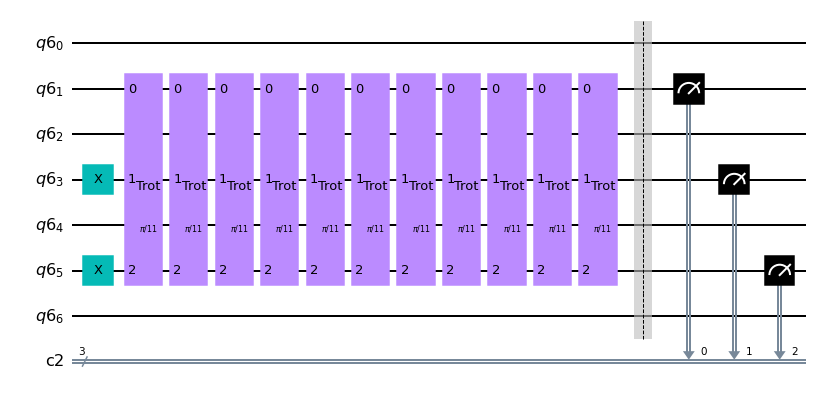

In [24]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 11 ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
#st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw('mpl')  # only view trotter gates

<a id='5'></a>
# 5. Execution

For the execution, we add just an **optimization_level = 3**.

In [20]:
shots = 8192
reps = 8
backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots, optimization_level=3)
    print(str("jakarta.retrieve_job('{}'),".format(job.job_id())))
    jobs.append(job)

The next nine cells contain jobs for several trotter steps (from 4 to 13 trotter steps).

In [22]:
# job 19sept + 4trot
jobs19_4=[jakarta.retrieve_job('632877893543abb8e8b456f6'),
jakarta.retrieve_job('632877a0fcf0f3333aeaabb4'),
jakarta.retrieve_job('632877b70cfeef54f47dc4b2'),
jakarta.retrieve_job('632877c905c8fd2c008fe730'),
jakarta.retrieve_job('632877f595ea077007483669'),
jakarta.retrieve_job('632878070cfeef08e67dc4b3'),
jakarta.retrieve_job('63287819542f50f5d61e421b'),
jakarta.retrieve_job('6328782b0cfeefdd907dc4b4')]

In [23]:
# job 19sept + 5trot
jobs19_5=[jakarta.retrieve_job('632876833543ab056bb456f2'),
jakarta.retrieve_job('6328769ee150f18d669dead8'),
jakarta.retrieve_job('632876b50cfeef3a8e7dc4ad'),
jakarta.retrieve_job('632876ccfcf0f324d2eaabaf'),
jakarta.retrieve_job('632876e2fcf0f37d69eaabb0'),
jakarta.retrieve_job('632876f8542f5011e41e421a'),
jakarta.retrieve_job('6328770f6b619a4f880d4b54'),
jakarta.retrieve_job('6328772695ea07490c483663')]

In [24]:
# job 19sept + 6trot
jobs19_6=[jakarta.retrieve_job('63287553fcf0f34e75eaabaa'),
jakarta.retrieve_job('6328757105c8fd2a428fe728'),
jakarta.retrieve_job('632875993543ab6960b456ef'),
jakarta.retrieve_job('632875b8542f50635b1e4215'),
jakarta.retrieve_job('632875d6fcf0f3e8f0eaabac'),
jakarta.retrieve_job('632875f70cfeef4c3a7dc4ac'),
jakarta.retrieve_job('63287614542f50dc6f1e4216'),
jakarta.retrieve_job('63287634fcf0f31ab3eaabad')]

In [25]:
# job 19sept + 7trot
jobs19_7=[jakarta.retrieve_job('63286b690cfeef85e17dc48b'),
jakarta.retrieve_job('63286b8b542f5054ad1e41fb'),
jakarta.retrieve_job('63286bab2fdf8525c469ec93'),
jakarta.retrieve_job('63286bcf542f50a0641e41fd'),
jakarta.retrieve_job('63286bf105c8fda2008fe6ff'),
jakarta.retrieve_job('63286c0f05c8fd35aa8fe700'),
jakarta.retrieve_job('63286c3a95ea07d7a9483637'),
jakarta.retrieve_job('63286c5b95ea07c695483639')]

In [26]:
# job 19sept + 8trot
jobs19_8=[jakarta.retrieve_job('632869dc542f504c5a1e41f3'),
jakarta.retrieve_job('632869fee150f15b039deaa9'),
jakarta.retrieve_job('63286a22fcf0f35353eaab83'),
jakarta.retrieve_job('63286a5295ea07a19b483630'),
jakarta.retrieve_job('63286a7c542f50d8341e41f6'),
jakarta.retrieve_job('63286aa795ea072a68483631'),
jakarta.retrieve_job('63286ac9fcf0f3c3feeaab85'),
jakarta.retrieve_job('63286af92fdf85385569ec91')]

In [27]:
# job 19sept + 9trot
jobs19_9=[jakarta.retrieve_job('63286cfb2fdf8525bb69ec95'),
jakarta.retrieve_job('63286d422fdf8569eb69ec96'),
jakarta.retrieve_job('63286d726b619a1ab00d4b31'),
jakarta.retrieve_job('63286da42fdf858b8869ec97'),
jakarta.retrieve_job('63286dd62fdf852e9469ec98'),
jakarta.retrieve_job('63286e0d3543ab22adb456c6'),
jakarta.retrieve_job('63286e3b2fdf85012169ec9a'),
jakarta.retrieve_job('63286e683543ab39a9b456c7')]

In [28]:
# job 19sept + 10trot
jobs19_10=[jakarta.retrieve_job('632878f2542f505fb11e421c'),
jakarta.retrieve_job('6328792995ea07838648366b'),
jakarta.retrieve_job('632879520cfeefcfa47dc4b6'),
jakarta.retrieve_job('632879883543ab6438b456fa'),
jakarta.retrieve_job('632879d30cfeef02537dc4b9'),
jakarta.retrieve_job('632879fd6b619a54e90d4b5b'),
jakarta.retrieve_job('63287a5505c8fde4028fe737'),
jakarta.retrieve_job('63287a8a2fdf85adea69ecd5')]

In [29]:
# job 19sept + 11trot
jobs19_11=[
jakarta.retrieve_job('63287b37e150f1cb209deae6'),
jakarta.retrieve_job('63287b642fdf85f85e69ecd6'),
jakarta.retrieve_job('63287b8f6b619a7a8f0d4b5f'),
jakarta.retrieve_job('63287bc45ccea78039944738'),
jakarta.retrieve_job('63287bf15ccea73a84944739'),
jakarta.retrieve_job('63287cbe05c8fd12cc8fe73d'),
jakarta.retrieve_job('63287cf66b619a2d5c0d4b64'),
jakarta.retrieve_job('63287d2c5ccea7ef2894473c')]

In [30]:
# job 9sept + 12trot
jobs19_12=[jakarta.retrieve_job('63287dcd2fdf85408369ecda'),
jakarta.retrieve_job('63287e0efcf0f3d8eaeaabc3'),
jakarta.retrieve_job('63287e47e150f1d8399deaec'),
jakarta.retrieve_job('63287e78fcf0f3c25ceaabc5'),
jakarta.retrieve_job('63287eb1fcf0f367bfeaabc6'),
jakarta.retrieve_job('63287ee0e150f12fff9deaf0'),
jakarta.retrieve_job('63287f1195ea077ed548367d'),
jakarta.retrieve_job('63287f43fcf0f367cdeaabca')]

In [31]:
# job 19sept + 13trot
jobs19_13=[jakarta.retrieve_job('63288017fcf0f34b7feaabcf'),
jakarta.retrieve_job('6328804b6b619a9cc60d4b73'),
jakarta.retrieve_job('6328807fe150f15c8b9deafa'),
jakarta.retrieve_job('632880bde150f124c79deafd'),
jakarta.retrieve_job('632880fc3543ab57c7b45712'),
jakarta.retrieve_job('632881375ccea72546944759'),
jakarta.retrieve_job('6328816f95ea0725fc48368e'),
jakarta.retrieve_job('632881ac3543ab5afdb45716')]

In [35]:
for job in jobs19_13:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


<a id='6'></a>
# 6. Error Mitgation using IBU

We first extract out all the counts (named *old_counts*), then we correct them using IBUG. Finally, we push them back into the new result.

For the **IBUG** parameters, we take:

1. Two iterations: **n = 2** 
2. A uniform prior truth: **t0 = np.ones(2^3)**
3. The response matrix from the ibmq_jakarta device: **R**
4. Apply 36 times IBU: **p = 36**

In [20]:
# RES is a list that contains all new unfolded results.
RES = []
for job in jobs19_11:
    my_result = job.result() 
    new_result = deepcopy(my_result)
    
    for resultidx, _ in enumerate(my_result.results):
        # extract counts from my_result
        old_counts = my_result.get_counts(resultidx)  
        # start unfolding (error mitigation)
        tp = IBUG(counts=old_counts, t0=np.ones(len(R)), Rin=R, n=2, p=36)
        # the new corrected counts
        new_counts = dict(zip(state_labels,tp))
        # push the new_counts back into the new result
        new_result.results[resultidx].data.counts = new_counts
        
    RES.append(new_result)                             

<a id='7'></a>
# 7. Results Analysis (Compute the State Tomography Fidelity)
We use the same provided code to compute the *state tomography fidelity*.

In [52]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those circuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [39]:
# Compute tomography fidelities for each repetition
fids = []
for job in jobs19_11:
# for re in res:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
print('state tomography fidelity  = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

fids = []
for res in RES:
    fid = state_tomo(res, st_qcs)
    fids.append(fid)
print('\nmitigated state tomo. fid. = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity  = 0.2459 ± 0.0054

mitigated state tomo. fid. = 0.6297 ± 0.0299


<a id='8'></a>
# 8. Maximum State Tomography Fidelity

We are now trying to see the state tomography fidelity variation in terms of number of IBUG recurrences (i.e. in terms of p). 

In [44]:
# load the 8 jobs of job19_11 locally
jb1=open('jobs/63287b37e150f1cb209deae6-output.json')
jb2=open('jobs/63287b642fdf85f85e69ecd6-output.json')
jb3=open('jobs/63287b8f6b619a7a8f0d4b5f-output.json')
jb4=open('jobs/63287bc45ccea78039944738-output.json')
jb5=open('jobs/63287bf15ccea73a84944739-output.json')
jb6=open('jobs/63287cbe05c8fd12cc8fe73d-output.json')
jb7=open('jobs/63287cf66b619a2d5c0d4b64-output.json')
jb8=open('jobs/63287d2c5ccea7ef2894473c-output.json')

In [45]:
# jbs is just a new name of job19_11
jbs=[jb1,jb2,jb3,jb4,jb5,jb6,jb7,jb8]
res=[]
for j in jbs:
    d=json.load(j)
    res.append(Result.from_dict(d))

In [40]:
def xxx_model(jobs, iter_num, gener_num):
    RES = []
    for job in jobs:                # or write: for my_result in res: (if you use job19_11 locally (i.e. jbs)) 
        my_result = job.result()
        new_result = deepcopy(my_result)
        for resultidx, _ in enumerate(my_result.results):
            old_counts = my_result.get_counts(resultidx)
            tp = IBUG(counts=old_counts, t0=np.ones(len(R)), Rin=R, n=iter_num, p=gener_num)
            new_counts = dict(zip(state_labels,tp))
            new_result.results[resultidx].data.counts = new_counts
        RES.append(new_result)  
    fids = []
    for res in RES:
        fid = state_tomo(res, st_qcs)
        fids.append(fid)
    print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    return fids

In [47]:
H=xxx_model(res=res, iter_num=2 ,gener_num=36)

state tomography fidelity = 0.6297 ± 0.0299


In [67]:
# this code takes exactly around 4 minutes to complete (when n=2)
v=[]
for e in tqdm(range(1,101)):
    H=xxx_model(res=res, iter_num=2,gener_num=e)
    v.append(H)

state tomography fidelity = 0.2626 ± 0.0061
state tomography fidelity = 0.2717 ± 0.0065
state tomography fidelity = 0.2813 ± 0.0069
state tomography fidelity = 0.2912 ± 0.0073
state tomography fidelity = 0.3016 ± 0.0077
state tomography fidelity = 0.3123 ± 0.0082
state tomography fidelity = 0.3232 ± 0.0086
state tomography fidelity = 0.3343 ± 0.0090
state tomography fidelity = 0.3455 ± 0.0095
state tomography fidelity = 0.3565 ± 0.0099
state tomography fidelity = 0.3673 ± 0.0105
state tomography fidelity = 0.3778 ± 0.0112
state tomography fidelity = 0.3883 ± 0.0118
state tomography fidelity = 0.3990 ± 0.0125
state tomography fidelity = 0.4097 ± 0.0130
state tomography fidelity = 0.4204 ± 0.0135
state tomography fidelity = 0.4318 ± 0.0141
state tomography fidelity = 0.4435 ± 0.0147
state tomography fidelity = 0.4557 ± 0.0155
state tomography fidelity = 0.4680 ± 0.0163
state tomography fidelity = 0.4801 ± 0.0167
state tomography fidelity = 0.4925 ± 0.0173
state tomography fidelity = 0.50

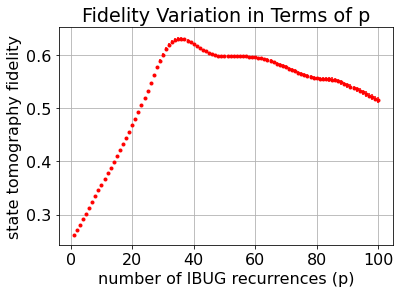

In [69]:
# plotting the 100 state tomography fidelity value
xvals  = list(range(1,101))
fids_mean = [round(np.mean(fids),4) for fids in v]
fids_std  = [round(np.std(fids),4) for fids in v]

fig=plt.figure()
plt.xlabel('number of IBUG recurrences (p)')
plt.ylabel('state tomography fidelity')
plt.title('Fidelity Variation in Terms of p')
plt.grid()

plt.errorbar(xvals,fids_mean,fids_std/np.sqrt(len(fids_std)),linestyle='none',marker='.',color='red')

fig.savefig('ibug_11trt.pdf',bbox_inches='tight')
plt.show()

In [56]:
# finding the maximum state tomography fidelity value
fids_mean = [round(np.mean(fids),4) for fids in v]
fids_std  = [round(np.std(fids),4) for fids in v]
a = fids_mean
b = fids_std
for index, value in enumerate(a):
    if value == max(a):
        print('max is {} \u00B1 {} for ( p = {}, trotter_steps = {} )'.format(value,b[index], index+1,trotter_steps))
        break
    else:
        continue

max is 0.6297 ± 0.0299 for ( p = 36, trotter_steps = 11 )


<a id='9'></a>
## 9. Other Results

<a id='9.1'></a>
### 9.1. Variation of State Tomography Fidelity in terms of $p$ for several Trotter steps
<a></a>

In [94]:
JOBS=[jobs19_4,jobs19_5,jobs19_6,jobs19_7,jobs19_8,jobs19_9,jobs19_10,jobs19_11,jobs19_12,jobs19_13]

In [95]:
def xxx_model(job_idx, iter_num, gener_num):
    RES = []
    for job in JOBS[job_idx]:
        my_result = job.result()
        new_result = deepcopy(my_result)
        for resultidx, _ in enumerate(my_result.results):
            old_counts = my_result.get_counts(resultidx)
            tp = IBUG(counts=old_counts, t0=np.ones(len(R)), Rin=R, n=iter_num, p=gener_num)
            new_counts = dict(zip(state_labels,tp))
            new_result.results[resultidx].data.counts = new_counts
        RES.append(new_result)  
    fids = []
    for res in RES:
        fid = state_tomo(res, st_qcs)
        fids.append(fid)
    return fids

In [100]:
# this code takes around 3 minutes in mean to complete one element (i.e. 27 min in total)
V=[]
for jobs in range(len(JOBS)): 
    v=[]
    for e in tqdm(range(1,101)):
        H=xxx_model(jobs,iter_num=2,gener_num=e)
        v.append(H)
    V.append(v)

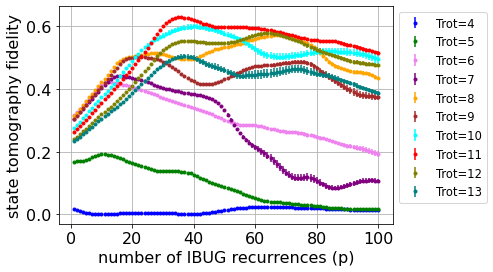

In [126]:
# varying the number of recurrences (with 4-13 trotter steps) 
xvals  = list(range(1,101))
fids_means=[]
fids_stds=[]
for d in range(len(V)):
    fids_means.append([round(np.mean(fids),4) for fids in V[d]])
    fids_stds.append([round(np.std(fids),4) for fids in V[d]])

fig = plt.figure()
colorit=['blue','green','violet','purple','orange','brown', 'cyan','red','olive','teal']
plt.xlabel('number of IBUG recurrences (p)')
plt.ylabel('state tomography fidelity')
plt.grid()

for k in range(len(JOBS)):
     plt.errorbar(xvals,fids_means[k],fids_stds[k]/np.sqrt(len(fids_stds[k])),
                  linestyle='none',marker='.',color=colorit[k],label=str('Trot={}'.format(k+4)))

plt.legend(bbox_to_anchor=(1,1),fontsize=11.5)
plt.show()
fig.savefig('4-13trot.pdf',bbox_inches='tight')

In [24]:
# maximum state tomography fidelity values from 4 to 13 trotter steps 
for e in range(len(JOBS)):
    a =fids_means[e]
    b =fids_stds[e]
    for index, value in enumerate(a):
        if value == max(a):
            print('max  {} \u00B1 {}  ( p = {}, trotter_steps = {} )'.format(value,b[index], index+1,e+4))
            break
        else:
            continue


max  0.0244 ± 0.0047  ( p = 64, trotter_steps = 4 )
max  0.1920 ± 0.0024  ( p = 10, trotter_steps = 5 )
max  0.4237 ± 0.0040  ( p = 12, trotter_steps = 6 )
max  0.4423 ± 0.0084  ( p = 16, trotter_steps = 7 )
max  0.5730 ± 0.0099  ( p = 68, trotter_steps = 8 )
max  0.5014 ± 0.0113  ( p = 22, trotter_steps = 9 )
max  0.6000 ± 0.0943  ( p = 40, trotter_steps = 10 )
max  0.6297 ± 0.0299  ( p = 36, trotter_steps = 11 )
max  0.5783 ± 0.0436  ( p = 64, trotter_steps = 12 )
max  0.5042 ± 0.0817  ( p = 37, trotter_steps = 13 )



<a id='9.2'></a>
### 9.2.  Variation of State Tomography Fidelity in terms of $p$ for several Number of Iterations
<a></a>

In [87]:
# Varying the number of iterations (from 1 to 9)
Vs=[]
for N in tqdm(range(1,10)):
    vs=[]
    for e in range(1,101):
        H=xxx_model(res=res,iter_num=N,gener_num=e)
        vs.append(H)
    Vs.append(vs)

state tomography fidelity = 0.2171 ± 0.0038
state tomography fidelity = 0.2061 ± 0.0033
state tomography fidelity = 0.1967 ± 0.0028
state tomography fidelity = 0.1887 ± 0.0025
state tomography fidelity = 0.1818 ± 0.0022
state tomography fidelity = 0.1758 ± 0.0019
state tomography fidelity = 0.1706 ± 0.0017
state tomography fidelity = 0.1661 ± 0.0016
state tomography fidelity = 0.1621 ± 0.0014
state tomography fidelity = 0.1586 ± 0.0013
state tomography fidelity = 0.1555 ± 0.0011
state tomography fidelity = 0.1528 ± 0.0010
state tomography fidelity = 0.1503 ± 0.0009
state tomography fidelity = 0.1481 ± 0.0008
state tomography fidelity = 0.1461 ± 0.0007
state tomography fidelity = 0.1443 ± 0.0007
state tomography fidelity = 0.1427 ± 0.0006
state tomography fidelity = 0.1412 ± 0.0005
state tomography fidelity = 0.1399 ± 0.0005
state tomography fidelity = 0.1387 ± 0.0005
state tomography fidelity = 0.1376 ± 0.0004
state tomography fidelity = 0.1365 ± 0.0004
state tomography fidelity = 0.13

state tomography fidelity = 0.5480 ± 0.0410
state tomography fidelity = 0.5451 ± 0.0415
state tomography fidelity = 0.5424 ± 0.0423
state tomography fidelity = 0.5399 ± 0.0434
state tomography fidelity = 0.5376 ± 0.0450
state tomography fidelity = 0.5352 ± 0.0469
state tomography fidelity = 0.5325 ± 0.0489
state tomography fidelity = 0.5295 ± 0.0507
state tomography fidelity = 0.5264 ± 0.0521
state tomography fidelity = 0.5233 ± 0.0530
state tomography fidelity = 0.5204 ± 0.0536
state tomography fidelity = 0.5178 ± 0.0539
state tomography fidelity = 0.5154 ± 0.0542
state tomography fidelity = 0.2770 ± 0.0071
state tomography fidelity = 0.2955 ± 0.0080
state tomography fidelity = 0.3154 ± 0.0088
state tomography fidelity = 0.3343 ± 0.0092
state tomography fidelity = 0.3508 ± 0.0099
state tomography fidelity = 0.3653 ± 0.0111
state tomography fidelity = 0.3785 ± 0.0122
state tomography fidelity = 0.3926 ± 0.0127
state tomography fidelity = 0.4079 ± 0.0130
state tomography fidelity = 0.42

state tomography fidelity = 0.5832 ± 0.0384
state tomography fidelity = 0.5823 ± 0.0381
state tomography fidelity = 0.5814 ± 0.0382
state tomography fidelity = 0.5812 ± 0.0385
state tomography fidelity = 0.5810 ± 0.0391
state tomography fidelity = 0.5809 ± 0.0394
state tomography fidelity = 0.5807 ± 0.0395
state tomography fidelity = 0.5797 ± 0.0394
state tomography fidelity = 0.5794 ± 0.0395
state tomography fidelity = 0.5778 ± 0.0385
state tomography fidelity = 0.5774 ± 0.0386
state tomography fidelity = 0.5771 ± 0.0389
state tomography fidelity = 0.5761 ± 0.0388
state tomography fidelity = 0.5715 ± 0.0396
state tomography fidelity = 0.5633 ± 0.0436
state tomography fidelity = 0.5624 ± 0.0445
state tomography fidelity = 0.5617 ± 0.0455
state tomography fidelity = 0.5546 ± 0.0609
state tomography fidelity = 0.5538 ± 0.0626
state tomography fidelity = 0.5544 ± 0.0624
state tomography fidelity = 0.5552 ± 0.0622
state tomography fidelity = 0.5552 ± 0.0617
state tomography fidelity = 0.55

state tomography fidelity = 0.5613 ± 0.0317
state tomography fidelity = 0.5618 ± 0.0312
state tomography fidelity = 0.5633 ± 0.0304
state tomography fidelity = 0.5620 ± 0.0296
state tomography fidelity = 0.5646 ± 0.0312
state tomography fidelity = 0.5654 ± 0.0325
state tomography fidelity = 0.5651 ± 0.0372
state tomography fidelity = 0.5658 ± 0.0376
state tomography fidelity = 0.5651 ± 0.0405
state tomography fidelity = 0.5653 ± 0.0405
state tomography fidelity = 0.5653 ± 0.0404
state tomography fidelity = 0.5653 ± 0.0402
state tomography fidelity = 0.5615 ± 0.0378
state tomography fidelity = 0.5599 ± 0.0368
state tomography fidelity = 0.5596 ± 0.0365
state tomography fidelity = 0.5590 ± 0.0362
state tomography fidelity = 0.5596 ± 0.0362
state tomography fidelity = 0.5600 ± 0.0354
state tomography fidelity = 0.5599 ± 0.0351
state tomography fidelity = 0.5582 ± 0.0342
state tomography fidelity = 0.5575 ± 0.0342
state tomography fidelity = 0.5578 ± 0.0342
state tomography fidelity = 0.55

state tomography fidelity = 0.5037 ± 0.0451
state tomography fidelity = 0.5089 ± 0.0473
state tomography fidelity = 0.5204 ± 0.0554
state tomography fidelity = 0.5236 ± 0.0529
state tomography fidelity = 0.5428 ± 0.0520
state tomography fidelity = 0.5445 ± 0.0527
state tomography fidelity = 0.5529 ± 0.0431
state tomography fidelity = 0.5558 ± 0.0421
state tomography fidelity = 0.5571 ± 0.0417
state tomography fidelity = 0.5604 ± 0.0348
state tomography fidelity = 0.5608 ± 0.0352
state tomography fidelity = 0.5631 ± 0.0341
state tomography fidelity = 0.5624 ± 0.0332
state tomography fidelity = 0.5620 ± 0.0325
state tomography fidelity = 0.5622 ± 0.0314
state tomography fidelity = 0.5634 ± 0.0309
state tomography fidelity = 0.5627 ± 0.0303
state tomography fidelity = 0.5650 ± 0.0319
state tomography fidelity = 0.5660 ± 0.0335
state tomography fidelity = 0.5648 ± 0.0378
state tomography fidelity = 0.5652 ± 0.0379
state tomography fidelity = 0.5645 ± 0.0409
state tomography fidelity = 0.56

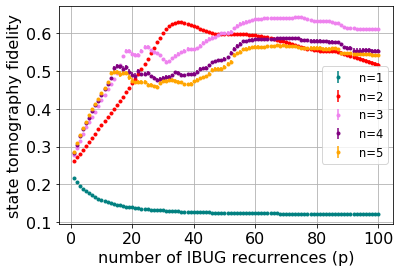

In [21]:
# ploting the variation of stf in terms of p for several number of iterations (1-5)
xvals  = list(range(1,101))
fids_means=[]
fids_stds=[]
for d in range(len(Vs[0:5])):
    fids_means.append([round(np.mean(fids),4) for fids in Vs[0:5][d]])
    fids_stds.append([round(np.std(fids),4) for fids in Vs[0:5][d]])

fig = plt.figure()
colorit=['teal','red','violet','purple','orange']
plt.xlabel('number of IBUG recurrences (p)')
plt.ylabel('state tomography fidelity')
plt.grid()

for k in range(len(Vs[0:5])):
     plt.errorbar(xvals,fids_means[k],fids_stds[k]/np.sqrt(len(fids_stds[k])),
                  linestyle='none',marker='.',color=colorit[k],
                  label=str('n={}'.format(k+1)))

plt.legend(#bbox_to_anchor=(1,1),
    fontsize=11.5)
plt.show()
fig.savefig('ibug_n_var.png',bbox_inches='tight')

In [16]:
# this is the data resulting from the two previous cells of section (variation of STF in terms p for several num. of iterations)
Vs=[[[0.21288851464748182, 0.22063108721916289, 0.21692757310004604, 0.21704419979065354, 0.21761809900898973, 0.20984725627485742, 0.21984890518786213, 0.2220984272751882], [0.20274756220680762, 0.20926443157707084, 0.20621390348479512, 0.2057416356691292, 0.20662696761640054, 0.19956391572598348, 0.20835829072804393, 0.2100869571181773], [0.19405867229112805, 0.19958504369772948, 0.19706601157754186, 0.1961882702082784, 0.19728133179628468, 0.19086167662340717, 0.19863145297406076, 0.19995052475235084], [0.18656986663264855, 0.19128837974029506, 0.1892031396958365, 0.1880565244111868, 0.18927867721724068, 0.18344655817480623, 0.19033997154699628, 0.1913351959549747], [0.18008036461538035, 0.18413503740791906, 0.18240439630859082, 0.18109141943395776, 0.18238302735638587, 0.17708866777341842, 0.1832273783601473, 0.18396562823912227], [0.17442854198283816, 0.17793425577204203, 0.17649373539808075, 0.175091390227196, 0.17640743586635838, 0.17160578850476121, 0.17709067188454083, 0.17762459852335905], [0.16948313437429957, 0.17253236140020614, 0.17132931176307095, 0.1698951546190554, 0.17120198610101128, 0.166851907597769, 0.17176736217329144, 0.17213873725020734], [0.16513670506319614, 0.16780442517093727, 0.1667957690596014, 0.16537239798964343, 0.16664525375508454, 0.16270896235777121, 0.16712615960662253, 0.16736832474249574], [0.16130071822001354, 0.16364809531353067, 0.16279853991626395, 0.1614169762336701, 0.16263806495744473, 0.15908076067566482, 0.16306013501354863, 0.16319982918604337], [0.15790177027310356, 0.15997895208892232, 0.15925955767390848, 0.15794184273189182, 0.15909883385150506, 0.1558884155915436, 0.1594815994205591, 0.15954034354688482], [0.15487867074896902, 0.15672695299357792, 0.15611397955850917, 0.1548751917273666, 0.1559600187737303, 0.15306686083374282, 0.15631820829394108, 0.1563133685676679], [0.15218015606951896, 0.15383367586257654, 0.15330764874660843, 0.15215748192975945, 0.15316538937432952, 0.15056215499517284, 0.15350995599729667, 0.1534555700889731], [0.14976308175283468, 0.15125015625628227, 0.1507951057547131, 0.14973911075295607, 0.15066789325620908, 0.14832937188640452, 0.15100682946997845, 0.15091425490247226], [0.14759098084496056, 0.1489351743628767, 0.14853801461284033, 0.14757857812885591, 0.14842797325664916, 0.14633093360423327, 0.14876695800401704, 0.14864538529911564], [0.14563290589347683, 0.14685388650475184, 0.14650390652957104, 0.14564102425972697, 0.14641222832081355, 0.1445352825694989, 0.14675514161654002, 0.14661200333462937], [0.14386249263480486, 0.144976723915928, 0.14466516947729008, 0.14389705659683422, 0.14459233957456374, 0.14291581614811755, 0.14494167185011408, 0.14478297062224427], [0.14225719856941488, 0.14327850091868466, 0.14299823023260458, 0.14232180290685673, 0.1429442032678059, 0.14145002672251364, 0.14330138080231758, 0.1431319537450472], [0.1407976805531764, 0.14173768860770394, 0.1414828883842555, 0.1408941426661504, 0.1414472265778756, 0.14011880389263173, 0.1418128698821833, 0.1416366026544527], [0.1394672836439819, 0.14033582035771686, 0.14010177127752124, 0.13959608019604317, 0.14008375265694983, 0.1389058655671673, 0.14045788120057018, 0.14027788192563242], [0.1382516195253259, 0.13905700303451263, 0.13883988585990684, 0.13841223120661825, 0.13883858896973142, 0.13779729217822484, 0.13922078292418769, 0.13903952393620042], [0.13713821744259574, 0.1378875134688268, 0.13768424863859519, 0.13732940060365453, 0.13769861869345906, 0.136781143867179, 0.13808814622704488, 0.1379075798928194], [0.13611623412419066, 0.1368154640682961, 0.13662357894139476, 0.13633623411017698, 0.13665247928336263, 0.13584714475861112, 0.13704839624933782, 0.13687004981031464], [0.13517621189503912, 0.13583052475682617, 0.13564804372694114, 0.1354229298587189, 0.13569029561838616, 0.13498642171935543, 0.13609152313167536, 0.13591657650388683], [0.13430987632351377, 0.13492369099972557, 0.13474904455507025, 0.134580998903414, 0.13480345769871857, 0.13419128754316095, 0.13520884202059488, 0.13503819170607273], [0.13350996641896987, 0.13408708968111813, 0.13391903917529083, 0.13380306578319132, 0.1339844348574811, 0.13345506048949604, 0.1343927931462507, 0.13422710479374636], [0.13277009172286125, 0.13331381618149188, 0.13315139164450931, 0.13308270198468283, 0.13322662001093383, 0.1327719136699949, 0.13363677480488834, 0.13347652647125857], [0.13208461169113753, 0.1325977972567818, 0.1324402460360586, 0.1324142865136707, 0.13252419870552012, 0.13213674901555242, 0.13293500344791248, 0.13278052122456158], [0.13144853360931397, 0.13193367531989528, 0.1317804197189724, 0.13179288886736215, 0.13187203870080033, 0.13154509154433613, 0.13228239616807438, 0.13213388352744174], [0.13085742595972122, 0.13131671052678326, 0.1311673129207677, 0.13121417056713036, 0.13126559661109372, 0.1309930004411431, 0.13167447174368388, 0.13153203371212674], [0.13030734470791316, 0.13074269771443195, 0.13059683187788534, 0.1306743021088996, 0.1307008387581059, 0.13047699409378502, 0.1311072671007485, 0.1309709301635282], [0.12979477041896118, 0.13020789576007077, 0.13006532335548446, 0.1301698927515356, 0.13017417389460886, 0.12999398674494536, 0.13057726661672503, 0.13044699509828148], [0.12931655447541837, 0.12970896735469853, 0.12956951870572106, 0.12969793102009164, 0.1296823958705684, 0.12954123483329455, 0.13008134214607703, 0.12995705167666285], [0.12886987296346844, 0.12924292752940042, 0.1291064859491256, 0.12925573417190322, 0.12922263464754952, 0.12911629143530762, 0.1296167020187126, 0.12949827059075955], [0.12845218703516978, 0.12880709955528866, 0.12867358862143474, 0.1288409051763415, 0.1287923143400589, 0.12871696749447584, 0.12918084756476456, 0.12906812459430542], [0.1280612087529719, 0.12839907706946768, 0.12826845033942447, 0.12845129600668978, 0.12838911718581517, 0.12834129874966516, 0.12877153596634802, 0.12866434970266316], [0.1276948715860057, 0.12801669146984837, 0.12788892421289885, 0.12808497624580642, 0.12801095253025663, 0.12798751745889253, 0.1283867484396392, 0.12828491200705405], [0.127351304862523, 0.12765798377868282, 0.12753306637302267, 0.1277402061742865, 0.1276559300614776, 0.12765402816643084, 0.12802466291722361, 0.1279279792242003], [0.1270288115945108, 0.12732118030447195, 0.12719911300537168, 0.127415413647546, 0.127322336656366, 0.12733938688606153, 0.12768363053795734, 0.12759189624844203], [0.12672584918319216, 0.1270046715394725, 0.126885460373956, 0.12710917418199968, 0.12700861630173405, 0.12704228317644742, 0.12736215536498993, 0.12727516409377995], [0.1264410125911848, 0.1267069938193413, 0.1265906474037407, 0.12682019376468434, 0.12671335263972008, 0.1267615246699064, 0.12705887684645306, 0.12697642171289705], [0.12617301963133992, 0.12642681334577677, 0.12631334045678472, 0.12654729397877196, 0.1264352537577495, 0.12649602368662458, 0.126772554611211, 0.12669443026284136], [0.12592069807595213, 0.12616291223503143, 0.12605231999349076, 0.1262893991023647, 0.12617313890255746, 0.126244785625114, 0.12650205525675404, 0.1264280594555931], [0.12568297433494768, 0.12591417630695081, 0.12580646885758118, 0.12604552489198856, 0.1259259268471427, 0.12600689886860586, 0.12624634084024872, 0.1261762756889036], [0.12545886348935778, 0.12567958437257423, 0.12557476196283293, 0.12581476880732378, 0.1256926256808329, 0.12578152598787115, 0.12600445882869982, 0.12593813170037507], [0.12524746049800625, 0.1254581988147101, 0.12535625719273677, 0.1255963014713652, 0.12547232382733245, 0.12556789605498667, 0.12577553330178634, 0.12571275752753058], [0.12504793242203693, 0.12524915728648198, 0.1251500873520066, 0.12538935919177113, 0.1252641821246175, 0.1253652979110806, 0.12555875723239945, 0.12549935258992884], [0.12485951153438242, 0.12505166537857001, 0.12495545303236792, 0.12519323739558694, 0.12506742682509017, 0.12517307425496055, 0.12535338569633125, 0.1252971787372764], [0.124681489200272, 0.12486499012759056, 0.12477161627479003, 0.12500728485174686, 0.12488134339496473, 0.124990616439572, 0.1251587298847245, 0.12510555413091567], [0.12451321043099015, 0.12468845425639868, 0.12459789492705564, 0.1248308985744476, 0.12470527100932288, 0.12481735988009109, 0.12497415181158636, 0.12492384784580259], [0.12435406902672969, 0.12452143105263722, 0.12443365760974902, 0.1246635193162263, 0.12453859765397408, 0.12465277999166746, 0.12479905962441465, 0.12475147509667227], [0.12420350323600657, 0.12436333980499097, 0.12427831921576295, 0.12450462757285743, 0.12438075575775993, 0.12449638858677649, 0.12463290343926749, 0.1245878930061214], [0.12406099186895311, 0.12421364172783332, 0.12413133687864032, 0.12435374003343032, 0.12423121828954399, 0.1243477306722953, 0.12447517163288149, 0.1244325968441754], [0.12392605081026718, 0.12407183631442387, 0.12399220635381808, 0.12421040641845078, 0.1240894952631545, 0.12420638159495853, 0.1243253875339353, 0.12428511667896029], [0.1237982298847588, 0.12393745806693292, 0.12386045876424606, 0.12407420665691143, 0.12395513060119177, 0.12407194449110678, 0.12418310646370084, 0.12414501438655699], [0.12367711003463869, 0.1238100735585473, 0.12373565766823152, 0.12394474836006372, 0.12382769931526166, 0.12394404800282788, 0.12404791308314432, 0.12401188097541296], [0.12356230077293094, 0.123689278788733, 0.12361739641285341, 0.12382166455554436, 0.12370680496568369, 0.12382234422779387, 0.1239194190094324, 0.12388533418676212], [0.12345343788198207, 0.12357469679790167, 0.12350529574087517, 0.12370461165034498, 0.12359207736864755, 0.12370650687458686, 0.12379726066980581, 0.123765016337799], [0.12335018132991085, 0.12346597551202285, 0.12339900162325289, 0.12359326759547237, 0.1234831705228391, 0.12359622959912332, 0.12368109736497869, 0.12365059237878892], [0.12325221338124409, 0.1233627857915028, 0.1232981832926759, 0.12348733022869167, 0.12337976073113567, 0.12349122450099223, 0.12357060951799573, 0.1235417481391436], [0.12315923688087593, 0.12326481966184481, 0.12320253145666958, 0.1233865157748656, 0.12328154489602851, 0.12339122076137067, 0.12346549708748425, 0.12343818874073972], [0.12307097369300161, 0.12317178870641472, 0.12311175667132966, 0.1232905574860695, 0.12318823897003636, 0.12329596340651235, 0.12336547812702668, 0.12333963715960018], [0.12298716327890545, 0.12308342260403321, 0.12302558785904515, 0.12319920440592085, 0.12309957654470996, 0.12320521218288069, 0.12327028747462475, 0.12324583291944291], [0.12290756139932461, 0.12299946779618462, 0.12294377095549273, 0.12311222024456496, 0.12301530756372925, 0.12311874053177353, 0.12317967555828407, 0.12315653090269699], [0.12283193892880401, 0.12291968627046611, 0.12286606767289221, 0.12302938235241165, 0.12293519714737171, 0.12303633465276595, 0.12309340730538341, 0.1230715002663611], [0.12276008077088033, 0.12284385444844172, 0.12279225436801255, 0.12295048078220568, 0.12285902451707889, 0.12295779264664461, 0.12301126114509403, 0.12299052345165264], [0.12269178486419306, 0.12277176216745257, 0.12272212100468516, 0.1228753174302657, 0.1227865820101659, 0.12288292372962403, 0.1229330280942938, 0.12291339527769933], [0.12262686127073057, 0.122703211747122, 0.12265547020173688, 0.12280370524882654, 0.12271767417583047, 0.12281154751162375, 0.12285851091861287, 0.1228399221107175], [0.12256513133836895, 0.12263801713232032, 0.12259211635823172, 0.12273546752236915, 0.1226521169446249, 0.12274349333222136, 0.12278752336119195, 0.12276992110110885], [0.12250642693071727, 0.12257600310529455, 0.12253188484879814, 0.12267043720164403, 0.12258973686441146, 0.12267859964866282, 0.12271988943258323, 0.12270321948178849], [0.12245058971803797, 0.12251700456043522, 0.12247461128256897, 0.1226084562898234, 0.12253037039657155, 0.1226167134709248, 0.12265544275597401, 0.1226396539218219], [0.1223974705236429, 0.12246086583587701, 0.12242014081995561, 0.12254937527583257, 0.12247386326692539, 0.12255768983941358, 0.12259402596253798, 0.12257906993011436], [0.12234692872076781, 0.12240744009673338, 0.12236832754205904, 0.1224930526104651, 0.12242006986638382, 0.12250139134135171, 0.12253549013232072, 0.12252132130447362], [0.12229883167543665, 0.12235658876531649, 0.12231903386806307, 0.12243935422137775, 0.1223688526968905, 0.12244768766235532, 0.12247969427651546, 0.12246626962188699], [0.12225305423126336, 0.1223081809941714, 0.12227213001641672, 0.12238815306344814, 0.12232008185865738, 0.12239645517006008, 0.1224265048574657, 0.12241378376628247], [0.12220947823257489, 0.12226209317817995, 0.12222749350601625, 0.1223393287014031, 0.122273634575097, 0.1223475765270049, 0.12237579534308551, 0.12236373949046689], [0.12216799208255513, 0.12221820850235401, 0.12218500869400203, 0.12229276692188294, 0.12222939475223725, 0.12230094033025318, 0.12232744579274224, 0.12231601900924781], [0.12212849033346863, 0.12217641652229815, 0.12214456634706913, 0.12224835937246042, 0.12218725256968724, 0.12225644077551241, 0.12228134247193544, 0.12227051062107136], [0.12209087330627628, 0.12213661277458092, 0.12210606324352209, 0.1222060032253395, 0.12214710410053489, 0.122213977343705, 0.12223737749338554, 0.12222710835577023], [0.12205504673723097, 0.12209869841455936, 0.12206940180353884, 0.12216560086370463, 0.12210885095779335, 0.12217345450819331, 0.1221954484823554, 0.12218571164626939], [0.12202092144924115, 0.12206257987939094, 0.12203448974537007, 0.12212705958888223, 0.1220723999652479, 0.12213478146097757, 0.12215545826427246, 0.12214622502227933], [0.12198841304603074, 0.12202816857423551, 0.12200123976538002, 0.12209029134666809, 0.1220376628507396, 0.12209787185640485, 0.12211731457286074, 0.12210855782422038], [0.12195744162726063, 0.12199538057974436, 0.12196956924004992, 0.12205521247129887, 0.12200455596012225, 0.1220626435710221, 0.12208092977720209, 0.12207262393579335], [0.12192793152298859, 0.12196413637926487, 0.12193939994822235, 0.12202174344572682, 0.12197299999027854, 0.12202901847835107, 0.12204622062625745, 0.12203834153372102], [0.12189981104594311, 0.12193436060410003, 0.1219106578120176, 0.121989808676945, 0.12194291973971698, 0.12199692223747827, 0.12201310800953369, 0.12200563285337648], [0.1218730122602597, 0.1219059817955506, 0.1218832726549746, 0.12195933628525264, 0.1219142438754293, 0.12196628409443432, 0.12198151673268658, 0.12197442396908197], [0.12184747076541642, 0.12187893218241641, 0.12185717797616483, 0.12193025790642031, 0.12188690471476846, 0.12193703669545955, 0.12195137530696197, 0.12194464458799527], [0.12182312549424074, 0.12185314747281156, 0.1218323107389926, 0.12190250850582454, 0.12186083802124831, 0.12190911591127136, 0.12192261575148701, 0.12191622785659754], [0.12179991852393189, 0.12182856665923586, 0.12180861117369496, 0.12187602620372634, 0.12183598281322551, 0.12188246067161673, 0.12189517340745398, 0.12188911017885956], [0.12177779489914141, 0.12180513183593338, 0.12178602259244879, 0.12185075211084416, 0.12181228118454387, 0.12185701280935649, 0.12186898676341884, 0.12186323104527949], [0.12175670246624797, 0.12178278802765537, 0.12176449121621909, 0.12182663017357717, 0.12178967813628214, 0.12183271691344576, 0.1218439972908765, 0.12183853287200412], [0.12173659171799923, 0.12176148302900737, 0.12174396601248935, 0.12180360702817503, 0.12176812141880626, 0.12180952019023361, 0.12182014928945774, 0.1218149608493625], [0.12171741564780592, 0.1217411672536349, 0.12172439854309457, 0.12178163186327048, 0.12174756138341492, 0.12178737233250175, 0.12179738974107333, 0.121792462799156], [0.12169912961298907, 0.12172179359256514, 0.1217057428214542, 0.12176065629020838, 0.1217279508429135, 0.12176622539575915, 0.12177566817240619, 0.12177098904011843], [0.12168169120636464, 0.12170331728106544, 0.12168795517853967, 0.12174063422066268, 0.121709244940493, 0.12174603368132746, 0.12175493652521177, 0.12175049226100858], [0.12166506013559004, 0.12168569577343757, 0.12167099413698051, 0.12172152175106968, 0.12169140102636448, 0.12172675362576903, 0.12173514903390482, 0.12173092740083498], [0.12164919810973078, 0.12166888862521728, 0.12165482029274462, 0.12170327705344218, 0.12167437854161792, 0.1217083436962792, 0.12171626210997451, 0.1217122515357417], [0.12163406873257862, 0.12165285738227755, 0.12163939620388346, 0.12168586027215253, 0.12165813890882705, 0.12169076429166303, 0.12169823423278159, 0.12169442377214448], [0.12161963740224098, 0.12163756547637236, 0.12162468628586821, 0.12166923342632295, 0.12164264542896266, 0.12167397764856064, 0.12168102584634712, 0.12167740514571089], [0.12160587121661069, 0.12162297812671341, 0.12161065671306821, 0.12165336031746833, 0.12162786318419364, 0.12165794775260341, 0.12166459926174969, 0.12166115852582764], [0.1215927388843101, 0.12160906224717524, 0.12159727532598259, 0.12163820644207574, 0.12161375894620326, 0.12164264025420075, 0.12164891856479113, 0.12164564852520737]], [[0.2547315796636223, 0.26758339014797805, 0.2613463171455683, 0.26367975930958015, 0.26301023634278864, 0.2520265909063846, 0.2672375420209, 0.2713861395332103], [0.2633960207234916, 0.2770887290376271, 0.2705039742903855, 0.2728479020405878, 0.27210965917038776, 0.2602519588692877, 0.27659889553640465, 0.28088018890321004], [0.2725587957850782, 0.28710050207933724, 0.2801891846284499, 0.28246100984392075, 0.281670742714696, 0.268860404513313, 0.2864193021553662, 0.2907822767450566], [0.2822067457208966, 0.2975927488183534, 0.29038728908766814, 0.2924796423668167, 0.29166072846785096, 0.2778137567965977, 0.29666134778983444, 0.3010414925411556], [0.2923134915343392, 0.30852559448964456, 0.30106929630378454, 0.3028499028313647, 0.3020323763095508, 0.2870609332859176, 0.30727300772479904, 0.3115938163369901], [0.3028377528075022, 0.31984592184810656, 0.31219004601818495, 0.31350556531004187, 0.31272525614925917, 0.29654014877972135, 0.3181891802301139, 0.3223660758516225], [0.3137229617972673, 0.33149052276877455, 0.32368776180902215, 0.32437317011414635, 0.32366985552166794, 0.30618392588067184, 0.3293359228324368, 0.33328264861402634], [0.32489908280681556, 0.3433921418393475, 0.335485955078117, 0.3353801638686431, 0.3347947355001508, 0.31592694427417195, 0.3406375968891993, 0.3442740621882919], [0.33612307595210605, 0.3554879023019733, 0.3474985776665613, 0.34646507809873794, 0.34537865354209923, 0.3257156818162694, 0.3520261972193474, 0.35528565331219125], [0.3469657181490467, 0.3673079931693673, 0.35943735969802415, 0.35758769476705066, 0.3558941196611459, 0.33551776749541895, 0.3633244293065846, 0.3658143554172836], [0.35790993362295953, 0.37927670206234515, 0.37101971591048455, 0.368096527353552, 0.3664846311780324, 0.34481882874107145, 0.374295468462207, 0.3761455714810084], [0.3689278285039533, 0.3914336941747246, 0.3826867875964701, 0.37860850691649534, 0.37649721078549225, 0.35351085271627813, 0.38525472390225246, 0.38585537820563254], [0.379607561518803, 0.4031908273459098, 0.3943214577089708, 0.3884153775769097, 0.3864984190460458, 0.3626141450084001, 0.3960970075526539, 0.3958855875927002], [0.3899829839863211, 0.4153653793853247, 0.4056532866841204, 0.3983411970400946, 0.396761551504511, 0.37204377385652904, 0.4075219997196206, 0.40649308231851006], [0.3998917435853221, 0.42695197876724555, 0.41686210392082634, 0.4081459392224952, 0.40699906306740175, 0.3824323400981729, 0.41927305178845886, 0.4170113013679975], [0.4097569544942976, 0.43793369328964915, 0.42808314834945604, 0.4182457035570566, 0.41689869305337557, 0.3924160143185636, 0.4315946490399625, 0.42832920536769764], [0.42017094443232506, 0.44936763643659083, 0.4399205603056675, 0.4290692554450798, 0.42757416532196035, 0.4032899912435601, 0.44515711380551054, 0.439754414234316], [0.43045630733215, 0.461721098797389, 0.4508737789065155, 0.43961191914184294, 0.4388010226134459, 0.41499738345609066, 0.45922852595323177, 0.4519531982095614], [0.44068110256305193, 0.47502157173845677, 0.4624229402468131, 0.45083296396031186, 0.44986537767290546, 0.4274760752004358, 0.47397985897527634, 0.46516133932327086], [0.4490861731883178, 0.487657541798963, 0.4748491485631727, 0.4625962538844203, 0.4619182269944095, 0.4407078252060777, 0.4880712198515328, 0.47933923954267954], [0.4587353179995682, 0.49963887499542037, 0.48519503560580535, 0.474761172798093, 0.47449187825536365, 0.4540188954598556, 0.5016098645202846, 0.49252913313846297], [0.4698232673631545, 0.5127051030262796, 0.4967264034247821, 0.4864612109335955, 0.48697727767825166, 0.4662859996804708, 0.5154662963338623, 0.5055696399141878], [0.48250741207144265, 0.5268217731621473, 0.5099475407350662, 0.49724197108511736, 0.5011885459019916, 0.479162381650088, 0.5268551821306982, 0.5191779097836188], [0.4968453207395973, 0.5400589281981771, 0.5250558616731118, 0.5079358289614658, 0.5171928857427697, 0.4924767077369043, 0.5385424158828658, 0.5333284615040883], [0.5127334606685645, 0.5537364004089292, 0.54214490313838, 0.516732022228031, 0.5329318969527417, 0.5048408082187427, 0.5503042151022313, 0.5479624037645372], [0.5298765583457534, 0.5685907247026665, 0.5611436352217489, 0.52608658569457, 0.5490919339994866, 0.5175800613784032, 0.561918124524011, 0.5620370518268353], [0.5471115333062454, 0.5845176022073298, 0.5815586175328101, 0.5360615486433701, 0.5665629843686655, 0.5304357725272678, 0.5732110607124606, 0.5766457273752292], [0.562954372433654, 0.6011643204554228, 0.6001577233947125, 0.5467157297785707, 0.5848388656543261, 0.5430341297154485, 0.5775873007213502, 0.5916491046352423], [0.5790043827154867, 0.6178068782965369, 0.6192313354093034, 0.5548981224411543, 0.6032137154603071, 0.55435148548779, 0.5819177587145501, 0.6005370200575942], [0.5947144257142021, 0.6334584355719045, 0.6374843604262038, 0.5621650882470752, 0.6208185951157597, 0.5587597594140126, 0.5863672194254709, 0.6087994276558617], [0.609553220803669, 0.6454353917216263, 0.6535741227244463, 0.570349617267468, 0.6366967039011833, 0.5624938954485351, 0.5908572712082111, 0.6167389444381873], [0.6229845829394128, 0.6482835699229604, 0.6665955950852449, 0.579139343856916, 0.6480712684594948, 0.5654200612393583, 0.5952097969553889, 0.6238519249206985], [0.6344279489437284, 0.6499863128296276, 0.6752694307191243, 0.5881845430203316, 0.6493573173421457, 0.5675675748179163, 0.5990980329520443, 0.6297337502307423], [0.643288340785139, 0.6505693211781548, 0.6750876047082522, 0.5970421560181349, 0.6483874660971894, 0.5691004623454936, 0.6020957010147671, 0.6341426262171345], [0.6491434375915195, 0.650017903732679, 0.6736823660460876, 0.6050242132941737, 0.6453755262374038, 0.5702712840399411, 0.6038316642763087, 0.6370035520272928], [0.6520070639123315, 0.6482199083902715, 0.6710876701608898, 0.6112967869876323, 0.6407277926513334, 0.5713763149412607, 0.6042066099274669, 0.6383811244519428], [0.6506988589572832, 0.6450075099175517, 0.6672924562955511, 0.6151834510830748, 0.6350427155271253, 0.5726888359329954, 0.6035520669217811, 0.638439382055722], [0.6463486938651809, 0.6403005951643729, 0.6623210826748476, 0.6164058359336189, 0.6290297340458948, 0.5743594134500299, 0.6025763460115762, 0.6374125258227605], [0.641595714094322, 0.6343085939745929, 0.6563084234439795, 0.6151661834391433, 0.6232768505704069, 0.5763153574376083, 0.602069951358224, 0.6355951212098342], [0.6363272810007504, 0.6275892915899842, 0.6495220240208514, 0.6120809715214461, 0.6180676585599931, 0.5782602646685102, 0.6025429857058945, 0.6333343446776821], [0.6305760649022398, 0.6208176615626887, 0.6423293738994291, 0.6079797787777691, 0.6135537273172791, 0.5797316183190975, 0.6040254043625813, 0.6309930719248397], [0.6246001169565986, 0.614430448025688, 0.6351502242742725, 0.6036193936197257, 0.609869272808488, 0.5801837687512807, 0.6061037874001792, 0.6288370191495252], [0.6186910060116573, 0.6085657944456637, 0.6284300693776067, 0.5994583813269263, 0.6070340383704078, 0.5792048776459654, 0.6081225336143572, 0.6268885357061758], [0.6130985104383259, 0.603458939994663, 0.622639894141879, 0.5955988991016721, 0.6049586364222661, 0.57673784942091, 0.6094668564521709, 0.6249101863812574], [0.6080335396924773, 0.5995684759793476, 0.6182593011555929, 0.5920030781119324, 0.6035275776512223, 0.5731513478770237, 0.6098108074180293, 0.6226031869461341], [0.6036175084699384, 0.5972285978236245, 0.6156861601781183, 0.5889652802835186, 0.6026110238036625, 0.5691376566387293, 0.6092040216681287, 0.619879690239119], [0.5997850776125546, 0.5964877332632866, 0.6150829422900058, 0.5871420200963126, 0.6019233019485855, 0.5654809036876814, 0.6080061082710496, 0.6169917867617781], [0.5962282603956182, 0.5971553170244883, 0.6162158065055108, 0.5870582130273744, 0.6010713356163233, 0.562835305887032, 0.6067113379163687, 0.6142804695545935], [0.5925007160150384, 0.598872923543112, 0.6183876689311083, 0.5888043447993596, 0.5999419530961934, 0.5616363078338988, 0.6057183583826449, 0.6117469142384535], [0.588292961145185, 0.601200566326724, 0.6206033296773084, 0.5920917900971562, 0.5987661166955277, 0.5620604423029428, 0.6051820011138581, 0.6091451525260507], [0.583761275304195, 0.6037264425084288, 0.6219691068858824, 0.5962781755111054, 0.5977471336202469, 0.5639242749211909, 0.6049687776570255, 0.6064198170409256], [0.579698685354248, 0.6061435554221862, 0.6221247121250048, 0.6002342258034111, 0.5969141255907877, 0.5666692715694953, 0.6047274416227401, 0.6039194018770089], [0.5770984260665, 0.6082632968750572, 0.6212813143031316, 0.6028555439105605, 0.596205029663881, 0.5695617903342508, 0.6041356279537418, 0.6021444413919496], [0.5763367689858915, 0.6099990779152117, 0.6197820994341032, 0.6039768479260278, 0.5955756527670912, 0.5719377589811068, 0.6031452413112859, 0.6013409010286429], [0.5769065083849368, 0.6113618332764954, 0.6177161838137415, 0.6041104155425502, 0.5950060235252541, 0.5733073604937853, 0.6020041998202362, 0.6015397764435133], [0.5776872878616911, 0.6124876766306183, 0.6149748798560217, 0.6038353441231625, 0.5944098934382285, 0.5733639254052372, 0.601106565479635, 0.6026610116536518], [0.5775871240908708, 0.6136723612962339, 0.6114838096629035, 0.6035553180316655, 0.5935647174893579, 0.5720239006745972, 0.6008473265156024, 0.6044736135950622], [0.5762257347895074, 0.615329307878807, 0.6073660836467517, 0.60344237944062, 0.5921546948728424, 0.5694699838731239, 0.6015434777120051, 0.6066385525960057], [0.5736091716575112, 0.617727514699247, 0.6029989491684706, 0.6035066996703239, 0.5899496490888819, 0.5660486186849806, 0.6033558502645447, 0.608846376866619], [0.5697822784798171, 0.620716975937232, 0.5989330441740984, 0.6037260062283083, 0.5869920078881422, 0.5620514860233361, 0.6061418852774885, 0.6108603328443207], [0.5651992502825727, 0.6239047056648599, 0.5956901143586452, 0.6041649566261237, 0.5835741531944724, 0.5575906894948248, 0.6092914970455799, 0.6124333562604721], [0.56056684370564, 0.6267937840125453, 0.5935684673052529, 0.6050501997332408, 0.5800434514239794, 0.5526407162559424, 0.6117455235248351, 0.613293037265592], [0.5564168944144999, 0.6286881021167511, 0.5926172097363541, 0.6067020341068791, 0.5766498342024897, 0.5471487437067292, 0.6123290526245363, 0.6132698235043795], [0.5529538377519211, 0.6287425140539835, 0.5927706933331666, 0.6092900958340611, 0.5734712830134424, 0.5411149088776497, 0.610258872726024, 0.6124261085493138], [0.5501143318052909, 0.6264322746182062, 0.5940213405346711, 0.6126336202991627, 0.570466803632395, 0.5346210637507884, 0.6055861136073932, 0.6110617795394369], [0.5476405681959707, 0.6218624837391995, 0.5963851562096854, 0.6162084762123369, 0.5676737932962954, 0.5278569689837236, 0.5993152367636783, 0.6095678864858712], [0.54514215684424, 0.6153734455414409, 0.5996858686804316, 0.6193317001099585, 0.5653019955881314, 0.5211533762238154, 0.592935481368361, 0.6082175034371308], [0.5421813564628305, 0.6074006660872008, 0.6035762616541188, 0.6214119020100324, 0.5635654310854807, 0.514942585620906, 0.5876082062342309, 0.6070867012513829], [0.5383782417258562, 0.5986476721361533, 0.6075787325342998, 0.6220791073414634, 0.5624866245229562, 0.5096103389418157, 0.5837157022599115, 0.6061333853702363], [0.5336015224486399, 0.590098737480252, 0.6110258784332311, 0.6211542542467869, 0.5619119309967687, 0.5053488881783142, 0.5810374642379238, 0.6052922780639289], [0.5282593342380617, 0.5826617828876492, 0.6131781539011071, 0.6185728637916925, 0.561638678914639, 0.5021088488174197, 0.5791545849854595, 0.6045077278981776], [0.5233211374572078, 0.5766850082814488, 0.6135979513678186, 0.6143301088260701, 0.5615039543795536, 0.4996409831935189, 0.577694262555982, 0.6037237787328942], [0.5197678171097176, 0.5719038793482542, 0.6124234457985693, 0.6084955909300029, 0.561416627795629, 0.4976099060027593, 0.5763824976727778, 0.6028678595864083], [0.5179081617371339, 0.5678136522349917, 0.6103483428345253, 0.6013120376907697, 0.5613520460763513, 0.4957416317771403, 0.5750194092499197, 0.601842839705183], [0.5173403046721382, 0.5639866671436063, 0.6083408099928369, 0.593226501533313, 0.5613267774320982, 0.4939797000759841, 0.5734606383432913, 0.6005361984437205], [0.5174726268134849, 0.5601226875265615, 0.6072105807330244, 0.5847535199014958, 0.5613803092637897, 0.49259623739174235, 0.571638474589254, 0.5988551311197284], [0.5179657204499121, 0.5560791452578748, 0.6073801416543397, 0.5763724362487982, 0.561571676538865, 0.49196566848308615, 0.5696205726483868, 0.5967652817030373], [0.5188157774089166, 0.5520003936850556, 0.6089024340876981, 0.5685025774120439, 0.5619762908402199, 0.4915796648569046, 0.5676937550397276, 0.5942810167692752], [0.5201941586239907, 0.5482518534063178, 0.6114664053817619, 0.5614284908602728, 0.562674153657962, 0.49017446795581204, 0.5664114524156373, 0.5914136327438594], [0.5222159800173147, 0.5450971780601509, 0.6144332144954794, 0.5552991612999512, 0.5637328211093058, 0.48761705278894585, 0.5663902427971325, 0.5881537532775356], [0.5247591936227582, 0.5425363213504458, 0.6170809049032389, 0.5501860521647205, 0.5651941493095031, 0.4844262879242052, 0.567989602281239, 0.58451328733444], [0.527450731801242, 0.54042693004763, 0.6189253973752313, 0.546109946226922, 0.5670696990898553, 0.48098958515442775, 0.5713105580533246, 0.5805958481328902], [0.529873329570479, 0.5386317449961294, 0.6198356455891817, 0.5431648746232001, 0.5693213394632793, 0.47763813597200344, 0.5758466340735864, 0.5766465057316413], [0.5317506533241003, 0.5370584597828468, 0.6199245830790262, 0.5416121582603997, 0.5717854766221501, 0.4746976913568823, 0.5795625593211408, 0.5730031935944744], [0.5328827240458378, 0.5356419493700949, 0.6193856570469944, 0.5409347014811092, 0.5740907374496613, 0.47246375536864604, 0.5806358935916024, 0.5699320922394381], [0.5331537670106338, 0.534331732557875, 0.6183888379499616, 0.538416159228911, 0.5757203349325251, 0.47113052852235654, 0.5793992071633401, 0.5674832586329669], [0.5325766542271302, 0.5330920581571874, 0.617055720963255, 0.5317866028895428, 0.5762510875960554, 0.4706162156557672, 0.57683318154585, 0.5655149018948912], [0.5313116578683429, 0.5319031022367526, 0.6154783203342562, 0.5215258346190534, 0.575600563768454, 0.4704411816795472, 0.5735961402782235, 0.563883541670366], [0.5297714125217533, 0.5307610797651963, 0.6137401033633215, 0.5101936844510202, 0.5740788763664035, 0.46993539165114123, 0.5699807128945672, 0.5626976140646678], [0.5283894423488583, 0.5296809457181152, 0.6119401240438721, 0.4997567144114019, 0.5721963210434372, 0.4686801825911046, 0.5660070663546873, 0.5624852355953054], [0.5272942806285912, 0.5286980747202719, 0.6102190987455458, 0.48996489896341805, 0.5704610163757764, 0.46670049079109566, 0.5615177452791628, 0.5640457523386354], [0.5265685756522341, 0.5278295497301524, 0.6087231330646037, 0.4802220941934835, 0.5694151160333173, 0.4642086135449046, 0.5562595703524519, 0.5671813945454829], [0.5261769581521012, 0.5270054084035855, 0.6075175355969931, 0.47043323713123436, 0.5696530050056882, 0.4613364869508039, 0.5499948251278183, 0.5693612269735633], [0.5259635133969891, 0.5261545891071231, 0.6065687922928236, 0.460921832607461, 0.5708321269077371, 0.458118358597428, 0.5427357962433951, 0.5689834393199416], [0.5258592354648054, 0.5252841054515941, 0.6057995478053673, 0.452317499769447, 0.5707223354436202, 0.4544827289925413, 0.5350377761414015, 0.5668331483194916], [0.5259372035149749, 0.524424623979534, 0.6051368563543744, 0.4453762054329277, 0.5680747422629091, 0.45028243766319404, 0.5279096953403682, 0.5637157003167365], [0.5263956529825299, 0.5235991364874067, 0.6045272896008714, 0.4405298466923711, 0.5635986777694694, 0.44544914335244484, 0.5221744631663467, 0.5598802805010306], [0.5274385190422735, 0.5228215667489666, 0.6039337434826185, 0.4377649504003904, 0.5580457477461136, 0.44008527437754313, 0.5179958788643485, 0.5553972960441128], [0.5290604395005214, 0.5220989173028173, 0.6033275546434754, 0.4368715960223042, 0.5517489222249571, 0.43413208461834785, 0.5150389454819332, 0.5504805730473626], [0.5309837088661296, 0.521431845087813, 0.6026804888621855, 0.43753649941825157, 0.5448848542310855, 0.4273267910099914, 0.5128524933773086, 0.5455869793058794]], [[0.2672189582894339, 0.2821314188053306, 0.27488605798488236, 0.2788861479450388, 0.2773146872679035, 0.26577626605351445, 0.28251963978340633, 0.28758305241842147], [0.28415307589629824, 0.3011515861092179, 0.29309207003249166, 0.297921650492507, 0.29576840768027546, 0.2828496994209245, 0.30179004359280087, 0.3072699697675671], [0.3028834425273478, 0.32178662257626817, 0.31330557519714325, 0.3183057813120145, 0.3156445944380936, 0.301026447063921, 0.32248844228034496, 0.32774786566872677], [0.3218016525433538, 0.3418740884029837, 0.3345895335352588, 0.3378034841223516, 0.33299780939404267, 0.3179130123771745, 0.3424573653396287, 0.34514831280242314], [0.3394427660465284, 0.35964476971668896, 0.35368810397434225, 0.353735952942641, 0.34848632373005917, 0.33140377025382634, 0.35946398084002606, 0.3606353257323393], [0.3553033439645738, 0.3761540166966522, 0.3708234051702347, 0.3676266982121515, 0.3612767427472937, 0.34217141000083, 0.3741991580178251, 0.375218589644728], [0.36776153296780845, 0.39115385658582164, 0.3849107199054565, 0.378077699746769, 0.37311146803844353, 0.35383220538850557, 0.3897801659336341, 0.38929187445341057], [0.37894467530902626, 0.4050446165006378, 0.39906752306277116, 0.3898178941281398, 0.3861260666010983, 0.37004662480585104, 0.4073724481479397, 0.40414519270177035], [0.3913447143295467, 0.4192536806395846, 0.41378824476920656, 0.40425552251122365, 0.39941305445398123, 0.3894000209553097, 0.4270617267513221, 0.4184645724087944], [0.40352973396117214, 0.4335798357801308, 0.4247164527183705, 0.4209649164746858, 0.41194056466987466, 0.40920610401307406, 0.445784708335804, 0.4342057339330009], [0.4147392057133438, 0.4468807556032098, 0.4353624310475359, 0.43493473462273885, 0.42451457635959433, 0.42759687273793584, 0.4633481371984144, 0.4505327506686685], [0.42275087282253127, 0.4612055980994916, 0.44834294662387414, 0.447961831768551, 0.4344748677282955, 0.4472969123329204, 0.48462247502323796, 0.4647111066715319], [0.43377393241225226, 0.477879275105826, 0.46542064883880996, 0.4611183506457985, 0.44124284362599586, 0.46777251071674264, 0.5048626416886662, 0.47770753501181035], [0.44573068193398546, 0.49903597786928944, 0.4809801409665546, 0.47254397687443567, 0.45104486848286446, 0.48135583123910614, 0.5169946677557867, 0.4859030229677234], [0.47003399894474307, 0.5243044878299731, 0.5060078052335771, 0.48124544225675264, 0.46981611496336595, 0.4927354265455627, 0.5226400377687884, 0.4899015436254218], [0.5132674013215264, 0.5494543787986158, 0.551909806110213, 0.4864257472381528, 0.49693242982143104, 0.50792679734965, 0.5279245730441144, 0.49327412986036706], [0.568048671410692, 0.5725885349331572, 0.6077941972186814, 0.486301015935739, 0.5312912085774599, 0.5269153981222242, 0.5257455326542667, 0.49980713625528117], [0.6040294265478664, 0.5622099075140219, 0.6315448978013093, 0.4825175533153449, 0.569900499737815, 0.5447479300305346, 0.5178949810270757, 0.5102069805953539], [0.5813412239461775, 0.5584522592574465, 0.6319573567705681, 0.465365627898089, 0.5834392562413994, 0.5674594642380443, 0.49844510082402893, 0.5362364584110064], [0.5596653028960215, 0.552319884848134, 0.6193649035785874, 0.4489456967816931, 0.5486518271882455, 0.5850026416863782, 0.46377906098783966, 0.589158539685009], [0.5550224005861638, 0.5492532466235824, 0.5954002572203834, 0.46412646331432594, 0.5466547968681665, 0.5682435338445279, 0.43671642662379667, 0.626955415314915], [0.558223514422881, 0.5654334200481148, 0.572876496196418, 0.49234019754178676, 0.5556995996300877, 0.5128278240287271, 0.44577040232829007, 0.6399618028944941], [0.5590955971124056, 0.5776025961485989, 0.570255558246258, 0.5409681109417841, 0.544518482983763, 0.47763611278223606, 0.5107996816866803, 0.6513163046284374], [0.5612497239977505, 0.5808205886999277, 0.5900126648764868, 0.581483200860895, 0.5271546037591939, 0.4590186562221251, 0.5625745659193024, 0.6570395710374076], [0.5785031370059823, 0.580301578697743, 0.6094820426110047, 0.5805933971100936, 0.5173482250264541, 0.455651448557732, 0.565003145270606, 0.6242539576003802], [0.5904075415917032, 0.5611667234327211, 0.6093989687103751, 0.5787304239350743, 0.5215118595299335, 0.4725751224462192, 0.5466058527011395, 0.5594808746578042], [0.5895651710477929, 0.5488185522199543, 0.6077571654150568, 0.5693026942538484, 0.5252768323453741, 0.5129035622633642, 0.5299264346606661, 0.521331520613108], [0.5885554535397616, 0.5413717508452112, 0.6092625935835884, 0.552709616035216, 0.5230539709916047, 0.528060951127404, 0.5376708704212607, 0.5086157567814175], [0.579489294109886, 0.5340908050597098, 0.6036508139291351, 0.536635767773577, 0.5194084828809872, 0.5251684988952475, 0.5348970284610562, 0.49965170179356516], [0.5563530774161325, 0.5319607569134913, 0.5964940427066655, 0.5260904616127084, 0.5136714088074713, 0.5105908011407408, 0.5177386023023174, 0.4955302018600968], [0.5478352003724513, 0.5372740211771752, 0.5955462378130278, 0.5114012054247139, 0.5012717900397786, 0.4968476768926885, 0.5111631073735576, 0.49951198902374155], [0.5598114779980368, 0.5491189794267191, 0.5901699863795383, 0.5019331116668062, 0.49878416320331553, 0.5019793611537153, 0.5075905437745243, 0.5024501539236422], [0.5697846776500559, 0.5579942783936281, 0.5927659234325875, 0.4976808005249387, 0.5229115553977912, 0.5252827058717527, 0.4943730049706531, 0.5127540991124514], [0.5671938551512827, 0.5588871618560455, 0.6004720331558422, 0.4911514165751293, 0.5466041794629165, 0.5428435762975152, 0.4722526474905923, 0.5468830265939114], [0.5661157894398824, 0.561832435258754, 0.6045586909249638, 0.48202390499719494, 0.5599725935579426, 0.5475160882818412, 0.46216191129350986, 0.5766056160874382], [0.5661101983738905, 0.5699352123574029, 0.6058217500897509, 0.47671978365511014, 0.5841011579362466, 0.5485167188305581, 0.46127708496898484, 0.5854258451484056], [0.5687121697419776, 0.5724279215674655, 0.6079773924021687, 0.4760536191584646, 0.604041380012735, 0.5427771274180814, 0.4689907573078372, 0.5886691663781379], [0.5868890519303976, 0.5743421386702156, 0.6095334515540286, 0.4770518603278602, 0.609586163907275, 0.5324901333026226, 0.49208825488156716, 0.584626252889511], [0.5921642791099473, 0.5756267013918873, 0.6053461534526281, 0.4777217646190596, 0.6069527663625354, 0.5301370127197542, 0.49562595750145605, 0.5790869655481599], [0.5990815578508075, 0.5743047633917977, 0.5987791514335075, 0.4794603167456158, 0.6058298820625214, 0.5320830842838733, 0.4940150014416604, 0.577009238656766], [0.6088529913587869, 0.5694208777255482, 0.5996664675599096, 0.48210921200356666, 0.610091633870573, 0.5434700138609624, 0.4940940468335784, 0.5757833828789949], [0.6228408696197553, 0.5650384721920866, 0.6054977324403444, 0.4875920709419789, 0.6172696678731059, 0.5676926990328046, 0.49422699505526924, 0.579604726520046], [0.628658507042384, 0.5649119901322701, 0.614986414123994, 0.502452940343983, 0.6302521534161584, 0.5774776941911728, 0.4936557158731713, 0.5896748173116813], [0.6288482830632979, 0.5718305360784939, 0.6231534383789331, 0.5092928501684336, 0.6433296152688369, 0.5772941697652159, 0.4946947730385809, 0.5930609152838463], [0.6294538131834722, 0.5809006392949477, 0.6353206978304758, 0.510104950419313, 0.6490900807403258, 0.5755125975129537, 0.4977786278058419, 0.5940157294000468], [0.6312024197278446, 0.5860564533919319, 0.6486846342928716, 0.5110892119104776, 0.6503624816376639, 0.5752935075323193, 0.5027477221413886, 0.5949586085765931], [0.6359393434159218, 0.6001359149716593, 0.6478524461295601, 0.5125992441758683, 0.6526990762348426, 0.5757772981197413, 0.5114077915877956, 0.5960347306704521], [0.6434842910971086, 0.6099190532325272, 0.6474447383452913, 0.5141748636563769, 0.6533620856162147, 0.5763910104873289, 0.529550387211031, 0.5972783109386892], [0.6375422495439388, 0.6206776253750517, 0.647786101094035, 0.5161825417215612, 0.6532035377830172, 0.5770688693985553, 0.5510815010066278, 0.5983246103054458], [0.629875779523338, 0.6245463483907584, 0.6487412950797009, 0.5178271461180578, 0.6519984556691502, 0.5778271550627956, 0.5538965306736148, 0.5986149221485142], [0.6293375801992964, 0.6273072197975581, 0.649712787243745, 0.5201869359219248, 0.650141227318821, 0.5787104389027443, 0.5536210070634459, 0.603565997943846], [0.6284290551002969, 0.6320688024218457, 0.6501873841102066, 0.5226503053024365, 0.6515922685745752, 0.5798176538652197, 0.5546046849939508, 0.6216187788364025], [0.6289294931191374, 0.6497737843418332, 0.6510800692084294, 0.5243538124349222, 0.6563772715754066, 0.5814034429158708, 0.5591507767520301, 0.655155224504917], [0.629761397012985, 0.6556600236922132, 0.6504995257442476, 0.5258624423017801, 0.6582116802887272, 0.5842949269168513, 0.5864357375460961, 0.6618339266803136], [0.6302907298195363, 0.6556373335711466, 0.6463283487487642, 0.5268878519387429, 0.6601917374371199, 0.5920153803767836, 0.6277473392515432, 0.6617429535585866], [0.629873348344227, 0.6554584453176078, 0.6451420640028943, 0.5294528690795879, 0.6621541220067103, 0.6148426972316424, 0.6308944658979818, 0.6599990127293484], [0.6297633891049086, 0.6542110684999896, 0.6442779276156153, 0.5357889197358634, 0.6631977107586956, 0.6259374204481772, 0.6311050467340413, 0.660253844768284], [0.6296095874110005, 0.6526768699729121, 0.6440454116518807, 0.5589900870891956, 0.663804035153045, 0.6238943383125223, 0.6316579373325785, 0.66159253534111], [0.6289509583666938, 0.6504194412586233, 0.6441291132252577, 0.5808838736113093, 0.6640974054882199, 0.6229928373795127, 0.63254190316865, 0.6634861011275798], [0.6297748413082103, 0.6485497027440691, 0.6442428383790402, 0.5860191363928904, 0.6643118648918872, 0.6242850802504157, 0.6351104499020108, 0.6647150547378774], [0.6308052607507485, 0.6455907876308757, 0.643971574940235, 0.5896616491162507, 0.6630073951802732, 0.6260404827260314, 0.6435139219244778, 0.665506459505581], [0.6320821825568375, 0.6446474264054856, 0.6436388804894174, 0.5919151035249812, 0.6600793323731162, 0.6286720234467529, 0.6479328282968732, 0.6662883592842708], [0.6335498695534476, 0.6436079487329898, 0.6437537104296862, 0.5958229951749529, 0.6604143063801932, 0.6306157562042327, 0.6491229791702819, 0.6671268301914611], [0.6322861737904744, 0.640131564823264, 0.6451757441198037, 0.6012930424759385, 0.660723174318943, 0.6327763944379495, 0.6477224510250059, 0.6681002214055879], [0.6322175851449632, 0.6323439988850738, 0.6503575641983765, 0.6029246999560581, 0.6610798972087363, 0.6366461144799884, 0.6476025547147747, 0.6694543240137594], [0.6322572147315031, 0.6240524531813544, 0.6530787966393672, 0.6035201186301851, 0.6612711927023536, 0.6376734058855236, 0.6468764014780908, 0.6722771171883208], [0.6322902261340906, 0.6234182490202237, 0.6507512909536736, 0.6046205519687786, 0.660267740408217, 0.6378961928759941, 0.6470506598826437, 0.6778545186066598], [0.6323119612431719, 0.6232261682025833, 0.6403996573177662, 0.6089753409913287, 0.6551841764058717, 0.6385740940518839, 0.6489685453224793, 0.6809882749212212], [0.6323146846716273, 0.623010467641368, 0.6390141985021217, 0.6116800063974714, 0.65316643959455, 0.6383877239768629, 0.6507836783754168, 0.6829286922405742], [0.6322931298426695, 0.6227592471785189, 0.6394893407395753, 0.6075123652755323, 0.6537410834982907, 0.6378984478250266, 0.6527355673162866, 0.6832917040064735], [0.6322929008560051, 0.622494728453393, 0.6395405500719935, 0.6050309212195983, 0.6547149600081031, 0.639380520547918, 0.6544841520419087, 0.6811924102526491], [0.6326098751392581, 0.6222233314746751, 0.6395820612219758, 0.6060847317825667, 0.6560815837412153, 0.6422001326125121, 0.6560861768756933, 0.6793126373239106], [0.6330140211366645, 0.621945228122549, 0.6396003932106127, 0.6071852966919109, 0.6589945231129706, 0.6465293087970047, 0.6568399366069128, 0.6795772122162272], [0.6329911395476079, 0.6216616697506746, 0.6386571903093919, 0.608751369334189, 0.6620360789582863, 0.6483360951897065, 0.6550726931942508, 0.6799348423511548], [0.6331366474093805, 0.6213744442180777, 0.6346079463052056, 0.6083248334233389, 0.6635394875922824, 0.6484614363360551, 0.6526041224280846, 0.6802045280602597], [0.6332988760049807, 0.6210859837143744, 0.6280562028933844, 0.6096176880984505, 0.6648592258892763, 0.6484711024869786, 0.6439181587618847, 0.6794721688135531], [0.6334635796991132, 0.620799686650513, 0.6239635416676172, 0.6122886328467024, 0.6656903453814086, 0.6484809824810421, 0.6269522326481956, 0.6763870093947081], [0.6336180965580173, 0.6205205485951885, 0.6228920078702423, 0.6160094234777118, 0.6655443323373701, 0.6484301150998383, 0.615904016653945, 0.6618784702697299], [0.633709340432649, 0.620256535494443, 0.6215938926823805, 0.6198485900845299, 0.6636929954351193, 0.6480642754798861, 0.6157762366354844, 0.6459815258287256], [0.6334386192391837, 0.6200220755208052, 0.6212009262167316, 0.6231555384933495, 0.662257426348767, 0.6473955867698442, 0.6160468589254391, 0.6452365714426477], [0.6310647396374738, 0.6198490005121808, 0.6208735845462487, 0.6270504957931985, 0.661869499878479, 0.6472122490748274, 0.6164044870469271, 0.6452391146857754], [0.6279780996777925, 0.619831726920217, 0.6205529459705654, 0.6306131494889894, 0.6614643316337375, 0.6468761449358047, 0.6167691752268398, 0.6451587376231646], [0.6269726010152943, 0.6203432452062623, 0.6202351442340466, 0.6330582742475298, 0.6605797450230568, 0.6463834166893426, 0.616341986350986, 0.6446787457169246], [0.6222338066390649, 0.6214602350286894, 0.6199038557155522, 0.633021175636364, 0.6570171913307602, 0.6445954654460366, 0.6158789862058999, 0.6421741099738092], [0.6164625977615876, 0.6213251183768955, 0.6194831633546287, 0.6331639776311914, 0.6462864586348983, 0.643225071652119, 0.6161337785570761, 0.63904475275544], [0.6130448866809237, 0.6212819394300274, 0.618548182463785, 0.6327226333301775, 0.6430914406416898, 0.643806354054842, 0.6163154813708599, 0.6387934524685879], [0.6133874542460482, 0.6214638024327824, 0.6139970235748117, 0.6324203053707149, 0.6384942963338058, 0.6433171329085146, 0.6162430740661787, 0.6387709858399063], [0.6140830489594218, 0.6219683990440781, 0.591784980524547, 0.6319393089466361, 0.6371195372409607, 0.6328438209555168, 0.6161565681859121, 0.6387606562156717], [0.6154020734759588, 0.6230651219968268, 0.5765767038343855, 0.6258091493699933, 0.6363810069170679, 0.6031102752283105, 0.616066809792345, 0.6387440046563725], [0.6174601994024648, 0.6253058470646197, 0.5767055349916449, 0.6174634319639906, 0.6321254872693309, 0.5995185773779651, 0.6159728463897349, 0.6385690162829909], [0.6187390841427227, 0.6290446823985109, 0.5772466251987282, 0.6158578209314347, 0.6260926383901779, 0.6000497719298754, 0.6158744336323762, 0.6375605996700022], [0.6189657389430196, 0.624964397322855, 0.5778080079310169, 0.61331689698408, 0.6218643915269843, 0.6014832697125103, 0.6157714244558856, 0.6372926332180212], [0.6189965033668429, 0.6121653805096587, 0.578385191088167, 0.6006118771880294, 0.6210277975615459, 0.6034957711014667, 0.6156637738408278, 0.6373983233055902], [0.6190336235908614, 0.6145490994705097, 0.5789766699935174, 0.5979680365796228, 0.6206091004306634, 0.6038444683916804, 0.6155515939447164, 0.6375669395414073], [0.6191321407870471, 0.6145233414360746, 0.5795797094168348, 0.5976269933414324, 0.6202106213314723, 0.6036005835858026, 0.6154352375105246, 0.6379564789426523], [0.6194869168286716, 0.6143486678111316, 0.5801886984242739, 0.5972460061905654, 0.6198057445117536, 0.6034650587880476, 0.6153154201123405, 0.6390324059747435], [0.621346741594886, 0.6139287680617902, 0.5807907350970906, 0.5967565780035708, 0.6193949576331412, 0.6020898260815232, 0.6151933940828775, 0.6424352533199973], [0.628524896492572, 0.6127061064666799, 0.5813528430082752, 0.5960996810880137, 0.6189819651223452, 0.6007994113687753, 0.6150711730086087, 0.6395898308422919], [0.6320682227143097, 0.6120287705403988, 0.5817876485005655, 0.5951678556105127, 0.6185730551370179, 0.6009217311470426, 0.6149517255025213, 0.6312217288395408], [0.632423830801298, 0.6119098310145533, 0.5818599003708073, 0.5937482188651984, 0.6181789460640345, 0.6008783054247944, 0.6148387110685584, 0.6309664189593075]], [[0.27144122343224014, 0.28734098513339285, 0.2795852714392391, 0.2845722090022978, 0.2825663584996187, 0.2709160568710351, 0.28816552937355, 0.29372023124515967], [0.29177030830957573, 0.31050018031993104, 0.30164708433205006, 0.3080239122472515, 0.3052195695669926, 0.29191478790233805, 0.3117875644643017, 0.31772338593243993], [0.3139703032927302, 0.33441194803141777, 0.3265721314003239, 0.33140451434194074, 0.32652153480519674, 0.312412911867654, 0.33565890751033906, 0.3386161948212664], [0.33421518975364467, 0.35359480033694357, 0.34856770496483414, 0.34844387253565956, 0.34311610849078317, 0.32673195033340086, 0.3540844406370657, 0.3556393730137928], [0.3507858131501129, 0.370942714910662, 0.36623134528943685, 0.36255358457342773, 0.35642040659382385, 0.3379958176201757, 0.3714568913262239, 0.3737480889710124], [0.36382144899400004, 0.3884489520453686, 0.38335490317884907, 0.3748678706564742, 0.3698752955344789, 0.3515733174044944, 0.39099788498709576, 0.3915174903422454], [0.3776418534574069, 0.40578768766703593, 0.40224894499603553, 0.3899604465601197, 0.38591232818721866, 0.3733017913856593, 0.40986428809398684, 0.40422042476090075], [0.3931695388966272, 0.4187850128413277, 0.41370451676066977, 0.4056799126654869, 0.3998522274024231, 0.39675332004589176, 0.42757320447610137, 0.4178626950679149], [0.401629287829089, 0.43019207935341536, 0.42048805241857284, 0.42065770040963, 0.4108200523187039, 0.41400048907811837, 0.4458966605990724, 0.43361334026700665], [0.4093038860958771, 0.442343314605425, 0.4308454435991457, 0.433739170779615, 0.4198504782469527, 0.43607388473769276, 0.47078015977201143, 0.4478479955148002], [0.41627182064486334, 0.46204115885155084, 0.4463158384384489, 0.4464917881264271, 0.42472457175770334, 0.4604070659265187, 0.49908669480176215, 0.465212111929602], [0.42693718590713853, 0.4867240207982806, 0.4644718660713174, 0.4592955046448021, 0.43814519027686377, 0.4720545514081029, 0.5057855182500869, 0.47405081063357524], [0.463846309261812, 0.5113022881658289, 0.5011517312641418, 0.46724252534370486, 0.4714878368356969, 0.47907803913735647, 0.4997233030303616, 0.47121806368899494], [0.55655224442286, 0.5202779236985359, 0.5757817530811746, 0.4681555795995437, 0.5021351803814202, 0.49129814824581286, 0.49342138300701854, 0.46451015932013134], [0.6066759756503616, 0.46963711307699074, 0.5677325500848553, 0.4634479442431696, 0.5360203457853656, 0.5148411440644098, 0.5015346919719144, 0.4588621764722031], [0.5633673513004682, 0.4689215050616131, 0.5764888041204049, 0.4257259480957488, 0.566126016516599, 0.5548272906581397, 0.4813723906000597, 0.46251711868886536], [0.5183101801871719, 0.5151035065586577, 0.5753674700097173, 0.3920888701605045, 0.5119075706815952, 0.6355366280760449, 0.4094390450676362, 0.4866415444441838], [0.5235534589001514, 0.5299833832970917, 0.5428808334978845, 0.447147783460499, 0.5284857723626971, 0.5853133252797379, 0.3648387914202936, 0.5631361544465977], [0.5377497117573711, 0.5051634621273389, 0.5347814790100357, 0.45276139098595, 0.5394733510588634, 0.49680707038590943, 0.35197802894101665, 0.5719032979230164], [0.53743230003428, 0.492652498150158, 0.5351540320646032, 0.4417946483514997, 0.532779622423086, 0.46066980043937217, 0.3430715019019178, 0.5781974267311758], [0.5293904143413368, 0.4768776523268472, 0.5495042704844338, 0.47423178380432446, 0.5046463719115022, 0.43759478613093034, 0.36471586733344025, 0.5661877660046107], [0.5401107001695675, 0.47920992738481377, 0.5727844362377952, 0.49446241590312334, 0.4765895656368834, 0.4327773746520422, 0.4850075172348296, 0.52408139562699], [0.5427379081332511, 0.4821238685387839, 0.5851127003677592, 0.45948829268207303, 0.47963560033166375, 0.432746587536304, 0.4793780000666099, 0.4714851548901495], [0.5533881805950996, 0.49644436576134887, 0.5856603592953167, 0.44179950308208094, 0.4791309294632293, 0.4535939435744146, 0.47262585124018863, 0.4629303792024625], [0.5600051494816786, 0.4912044412669541, 0.5748369473249065, 0.4740207779325899, 0.47637564536913224, 0.4552619526602723, 0.47181176431734084, 0.4560240557008247], [0.5280772715908401, 0.4750597872086024, 0.5699306197221691, 0.4667269820474948, 0.47646314971007164, 0.4549062028371374, 0.4684879002576026, 0.44825801810671845], [0.5158550801101872, 0.4737803562271705, 0.5658790910442363, 0.45646251361779316, 0.4660818338099427, 0.4554430273567865, 0.476112827974805, 0.44956816585237486], [0.5119693273334802, 0.4780527481155772, 0.5611978164189082, 0.451642405058196, 0.43911463381853305, 0.4532233519522843, 0.47907041559652863, 0.4435200347496902], [0.514914766046397, 0.49217299020651745, 0.5588626043379613, 0.4526726689425838, 0.4390157108464207, 0.45098998813803415, 0.47994354242309056, 0.4472741894618018], [0.536398903145025, 0.4945789697366102, 0.5754495632452845, 0.45286874241752006, 0.44683037946379484, 0.4394610895007475, 0.4653850231390682, 0.446736662429107], [0.5432762237984653, 0.4967718429673887, 0.5783917582982953, 0.44811002322820126, 0.4746654983853563, 0.43569148902824295, 0.46244281135603577, 0.44700392591211185], [0.5445644440249028, 0.49828362083433314, 0.5785644058956226, 0.43310056938244895, 0.47610924697197937, 0.4372115558312899, 0.45979547376538127, 0.4517670364230062], [0.5525973453981925, 0.502547389069412, 0.5757788655886503, 0.4327448003291237, 0.47772237910261356, 0.44681979180090176, 0.45250537877071156, 0.4679212000088998], [0.5753424800072205, 0.5075326890234362, 0.5771415156724201, 0.43161197599371404, 0.4790107183997859, 0.4841271470247911, 0.449591729999046, 0.46771179478691927], [0.5762648419255902, 0.505655692771663, 0.5765713883009183, 0.4261652699042423, 0.4763848541718761, 0.4877206574870958, 0.4372687034258617, 0.4685624072593816], [0.5601695831885498, 0.5064460751692975, 0.564049128619909, 0.4268713294740293, 0.4654298604709449, 0.48553219390164454, 0.4433424143108289, 0.4677592748521273], [0.5593729588819658, 0.506191440287017, 0.5576232105609089, 0.4288478362733815, 0.4671964810795621, 0.4718629808188165, 0.4503499580271332, 0.47133664449327856], [0.5619291176329115, 0.5008122209966691, 0.5390058365140291, 0.43085569073038155, 0.4702429380816937, 0.4770998205484253, 0.4524696964469308, 0.4989288165560564], [0.5619299825935374, 0.4919677369587639, 0.5382915766306414, 0.4330516157986425, 0.4747735893061352, 0.47950090547830576, 0.4533977332985706, 0.5006371694711051], [0.5532297200110716, 0.492464188234739, 0.545053684117492, 0.4350068464257549, 0.4831863711552915, 0.48012049202377893, 0.45194017690774446, 0.5029471844880945], [0.5526358778964764, 0.49087306135992076, 0.5557706800616903, 0.43664652806655546, 0.5056668475652343, 0.4824666884722645, 0.4492473662238859, 0.5159297633081338], [0.5483116095829741, 0.4915307779030676, 0.5613388307447076, 0.4387759114448292, 0.5437516207992209, 0.4995728235304053, 0.4512019434769009, 0.5164779871960345], [0.5488471392319287, 0.4930045213035928, 0.5574705585157013, 0.44252091057500575, 0.5470066210531742, 0.49839085819662876, 0.45394696999162226, 0.5164199997953426], [0.5527497224599498, 0.5009606119191677, 0.558807817173864, 0.4441084509790558, 0.5467871277830697, 0.4968740786404045, 0.4582497540435004, 0.5163692279483155], [0.5599887448339818, 0.5328645439778882, 0.5645035193344007, 0.4457962762031597, 0.5466434999693821, 0.4914772059695174, 0.46697902203959896, 0.5163297975085857], [0.5665662885161489, 0.5342673679748792, 0.5963303804465405, 0.44768558379532225, 0.5466223116026997, 0.48768922633465367, 0.4912340351292446, 0.5163027409586124], [0.5611001447384055, 0.534616286426602, 0.5985119711237882, 0.44668383129919464, 0.546552888323505, 0.4877243261519721, 0.5197986477947989, 0.516227981332669], [0.576447081501382, 0.535850717116234, 0.6005753071959882, 0.4484515237311733, 0.5456446675828113, 0.48774439467588515, 0.5175442597595449, 0.5145876524111821], [0.5749605091841922, 0.5400918908689031, 0.6018307803497986, 0.4500411162915189, 0.5450949120153222, 0.4852359066851438, 0.51692309606269, 0.5138802713091009], [0.575220303643434, 0.5675470495140874, 0.6018970547793931, 0.45243937946683904, 0.5465493664021542, 0.48459383146349744, 0.5165294623743518, 0.5144916403704807], [0.575823375766029, 0.578002288062875, 0.6042644558637603, 0.4552524951081933, 0.5595684784153265, 0.48486436880428163, 0.51739326138392, 0.5165871771707253], [0.5775295294355752, 0.6104047309299154, 0.5998286135506988, 0.45782137216749896, 0.6034873027234873, 0.48528959021172213, 0.5194284900788899, 0.5339727790793096], [0.5790317809015956, 0.6129276304440633, 0.5994037748383994, 0.45812086088630394, 0.6046084549835401, 0.4862743815547726, 0.5395886586613157, 0.5969839733920296], [0.5793585049931695, 0.6131090104719655, 0.5995800296049983, 0.46674658993748347, 0.6051652680832033, 0.48953237663245897, 0.5805393066582565, 0.6011737054754109], [0.5796680723573158, 0.6131242880279599, 0.5983444746821595, 0.47536988291196275, 0.6058204819616361, 0.5209612883303428, 0.5810226872639846, 0.6013639537114135], [0.5794090445327996, 0.6131746964513599, 0.5982966813043771, 0.4762983917543653, 0.6075602511058352, 0.5725383637492937, 0.5813206137252008, 0.6012781591907975], [0.5753201744515013, 0.613351657387324, 0.5982668396818676, 0.4782810241950003, 0.6107390849412313, 0.5769049414881018, 0.5816494169591107, 0.6015698176737371], [0.5756752898476818, 0.6139037755941305, 0.59805391072485, 0.4971880810294987, 0.6128731404242059, 0.5780092911129239, 0.5819034767717643, 0.6020084269493884], [0.5761192181911365, 0.6149489621706469, 0.5974688229521955, 0.5038382491327419, 0.6148838767565002, 0.5783521707624837, 0.5797778569273593, 0.6024584153335417], [0.5765840498464079, 0.6143647452306604, 0.5966600422157214, 0.5032747366620168, 0.6150192349374481, 0.5787097250817425, 0.5906278552292678, 0.6029160559162724], [0.5770651275795662, 0.6089246766280336, 0.5954832366614, 0.5036739520442318, 0.6148455602284254, 0.5792307690358759, 0.5973580224260786, 0.6033852463295546], [0.5774177949565967, 0.6047531204985017, 0.5956839359711112, 0.5046078899248453, 0.6154391804698246, 0.5805345044495064, 0.5981567212786428, 0.6038764840642236], [0.5769459306502034, 0.5990454827447198, 0.5986739113601477, 0.5064643164445023, 0.6162789435859927, 0.5813497495659847, 0.5984660069023952, 0.6044212787400647], [0.5775275314220771, 0.6001750645532454, 0.5988700779614738, 0.5082465280513719, 0.6171455504785647, 0.5867930957917668, 0.5982903959536774, 0.6051487822642407], [0.5781570959864154, 0.5929934291911778, 0.5989370812392568, 0.5099899760585102, 0.6133204343194899, 0.5874211656886043, 0.5989539737228311, 0.6070242307268212], [0.5791598380448592, 0.5926836835381252, 0.599018858023079, 0.5100071992625475, 0.6053654632377427, 0.5871439076159565, 0.5991612865828678, 0.6173776625699564], [0.5809237096072905, 0.5924695707924198, 0.5991586537761816, 0.509287360185018, 0.6057226872164567, 0.58717573709027, 0.6039468868880067, 0.6222133047765572], [0.5816244634655495, 0.592286304809178, 0.5992797342970021, 0.502576650525194, 0.6062637774091831, 0.5900461468131533, 0.6055185332697935, 0.6222747299108146], [0.5827506737240327, 0.5921736913459102, 0.59936322753403, 0.4953636973998078, 0.6068441442156083, 0.5907782481305069, 0.607723352152321, 0.6233963786715161], [0.5833965080318462, 0.5915953622767838, 0.5994398952565823, 0.4903640618660103, 0.6080097919346741, 0.590750796776009, 0.6119103230562167, 0.6247861629208594], [0.5843963311162642, 0.5901936436154442, 0.5992948180773275, 0.4830542348576209, 0.6090460037052104, 0.5906966659765821, 0.6120075689853954, 0.6253281034192523], [0.5858824008792225, 0.5901020759373571, 0.5964819104164355, 0.4832308649246298, 0.6098437953422146, 0.590620036993041, 0.6120832400601526, 0.6254729705389931], [0.5882265193602012, 0.5898061270589157, 0.5962642468808802, 0.4834634935313038, 0.6104710751383948, 0.5905209539666496, 0.6121327644313731, 0.6255193170190182], [0.5913344325186694, 0.5894911892863206, 0.5966547292129915, 0.48374020711536786, 0.611075199818478, 0.5904007180363989, 0.6090545124700134, 0.6246953693558532], [0.5930107921568061, 0.5891560123518587, 0.5970793264604843, 0.4839377813985341, 0.611886691353362, 0.5902634478375677, 0.5909191594718004, 0.6089869249595559], [0.5932682184981543, 0.5887736448550431, 0.5971303576096922, 0.4834099268904571, 0.6132343977279624, 0.5901202015481445, 0.5902303314366641, 0.6020193086600877], [0.5934093635033277, 0.5881045554781502, 0.5936505261030743, 0.4824445125216007, 0.6138420945642509, 0.5900013367538854, 0.5902461931348769, 0.599106842608531], [0.5935270986138689, 0.5856543184429592, 0.5933638213891645, 0.48201389267263345, 0.6161333478043984, 0.589989649877055, 0.590260848991767, 0.5986813616608717], [0.5936322148869417, 0.5845742682099663, 0.5934660142838599, 0.4802105811273952, 0.6168541138051935, 0.5901572510213956, 0.5902768996039931, 0.598515824028306], [0.5936733781617466, 0.5842111142753813, 0.5935721135051265, 0.47956129368592143, 0.6169530327730415, 0.5898338738657402, 0.5903056854441646, 0.5987440274193113], [0.5931440878606349, 0.583860126313517, 0.5936825648644414, 0.4791736969158125, 0.6172696163264015, 0.5889454390069767, 0.5903976814101906, 0.5989922732950853], [0.5851938142774897, 0.583510377761247, 0.5937983100181649, 0.47879788287043723, 0.6171060621650836, 0.5896072083336367, 0.5904181772053083, 0.5992817179260896], [0.5832227322352026, 0.5831659394446307, 0.593922423452219, 0.4782579934900797, 0.6163513535272804, 0.590105349298126, 0.5901177609284716, 0.5996918614073344], [0.5832555791774017, 0.582833895804501, 0.5940720084786159, 0.47753135060848423, 0.6047447783203732, 0.5900541114249851, 0.5901804195004201, 0.5998276421490233], [0.5832477034409399, 0.5825266188359833, 0.594218713337646, 0.4766728350688611, 0.6026301822431263, 0.5900435574035916, 0.5900045037800283, 0.5995690534672634], [0.5832374688442573, 0.5822633450001401, 0.5940721790049314, 0.47570208615271986, 0.6021640400257733, 0.5897621766360974, 0.5899832069690714, 0.5997836530845208], [0.5832245562028847, 0.5819998547778201, 0.5942182108277847, 0.47467276949815373, 0.5987007748401936, 0.5863730392155404, 0.5898375049339359, 0.5999173193754065], [0.5832036842691841, 0.5789173866353443, 0.5943695313826619, 0.4733191822181954, 0.598537300136487, 0.5540734291004833, 0.5896756676661483, 0.6000000622768994], [0.5831148452998842, 0.5169528319336028, 0.5945293142281516, 0.4722389017117348, 0.5984745336182626, 0.5511826643449326, 0.589616077212126, 0.6000839388898872], [0.5825453459067028, 0.5109210169608704, 0.5946671219313684, 0.47208843152029806, 0.5983060011478819, 0.5511938530818213, 0.5894330908388682, 0.60017058830709], [0.5823166148082972, 0.5108367272229969, 0.5947290140248207, 0.46766098986893795, 0.5974481696232694, 0.5513318696210034, 0.5892533528805792, 0.6002601561602002], [0.5817439546871244, 0.5108701544795613, 0.5949362647758756, 0.41196577675026885, 0.596150128581487, 0.5513440726320445, 0.5890660196286753, 0.6003526430343525], [0.5817584046911671, 0.5109217395497431, 0.595111236910751, 0.4059662188234828, 0.5961214819789603, 0.5513552633732299, 0.5888702618644571, 0.6004476263017907], [0.5846433260345534, 0.510975872218937, 0.5952950938764398, 0.40742757373151706, 0.5960969233565677, 0.5513674348582023, 0.5886662437983237, 0.6005430858613596], [0.5899264892871091, 0.5110320941319492, 0.5954909496528414, 0.40894094094445377, 0.5954729335512713, 0.5513716752746641, 0.5884543557573761, 0.6006299774950483], [0.5900858403558623, 0.5110901323570828, 0.5956999580965566, 0.4105078145271546, 0.5943586620579917, 0.551256638921875, 0.5882353299285596, 0.6006554531345518], [0.5901713686670607, 0.5111492062119035, 0.595921454636566, 0.4121314986154773, 0.594396405783352, 0.5499372986339035, 0.5880104801622873, 0.5999469563857944], [0.5902541644619784, 0.5112075996948551, 0.5961466761872867, 0.4138157590782304, 0.5944541192209511, 0.5491774042808888, 0.5877822113147235, 0.5862313521477267], [0.5903296552519561, 0.5112799741799464, 0.5963043517790462, 0.41556545828950114, 0.5945317346887402, 0.5490229275779316, 0.5875552354943973, 0.5843462055426111], [0.590380521268928, 0.5115890135484449, 0.595605558621149, 0.41738953750616153, 0.5946338824808906, 0.5483487451208262, 0.5873396454783532, 0.5849273876882294]], [[0.273001287936969, 0.28942811781263805, 0.2813698258283558, 0.28693841521539876, 0.28472774475317386, 0.2730460787449695, 0.29047497723398463, 0.2963274945619188], [0.2948184133547805, 0.31464002411662534, 0.3051819594572603, 0.31260458602433056, 0.3095326585093112, 0.2960025772544118, 0.3162170061895371, 0.3223317060833661], [0.3181264752565251, 0.33896712926606143, 0.3314564371984231, 0.33546449878440765, 0.3306345803117722, 0.31609724938393546, 0.34009482676449565, 0.34197757045465327], [0.33821786985791796, 0.35679923358543125, 0.3530149061838763, 0.3516258488190949, 0.3458538819097615, 0.32854381590704335, 0.35749111367558384, 0.3608497009259575], [0.35343698498668363, 0.3753845580103162, 0.3710421332357632, 0.36484494385583216, 0.35941900013437145, 0.34067561025610554, 0.37885414802756034, 0.38186395854492605], [0.36757240386104467, 0.396271427192006, 0.3922362631853559, 0.3809658443644966, 0.37507358313731193, 0.35909234604765283, 0.3993561555926074, 0.39709563252543406], [0.38581928081903105, 0.4112300025735857, 0.4092779309915809, 0.39564272091895564, 0.3932065781416622, 0.38501235851836896, 0.41438340219471625, 0.40637929454740734], [0.3954724911854113, 0.4199470458385307, 0.41317964853613637, 0.40967385861901223, 0.4020934289189442, 0.4031219010908509, 0.4317227975112002, 0.42213044649528053], [0.4014851841121561, 0.43084952549268407, 0.42042586744391774, 0.4237114601334201, 0.41243517757869325, 0.4207681906361609, 0.4541020561397501, 0.4362007738705486], [0.40782382050601895, 0.44735759791631574, 0.433012868927253, 0.43553757380497243, 0.4181353375409578, 0.450277172627009, 0.48879898241649483, 0.45367895183003243], [0.41605577611689554, 0.4726723244890991, 0.44964453941257126, 0.4489851232339799, 0.42711714246960975, 0.4644635862704519, 0.5010667957840484, 0.4684304868000966], [0.4434756392644862, 0.5007713814570691, 0.4812778897916234, 0.4586415901071583, 0.46065934962596305, 0.469877631877917, 0.4938517292097888, 0.4670680790299292], [0.5435153272560045, 0.5068008388244456, 0.55180146168382, 0.46275930611992955, 0.48811499538739117, 0.47641277472428656, 0.48148505610490144, 0.4576378053754756], [0.6051579557726223, 0.44738042651712157, 0.5425786526707537, 0.45975822315104836, 0.5077882930156137, 0.49115073573917384, 0.4830234391521618, 0.4493996736703404], [0.5719619635292491, 0.4312782491842125, 0.5409177678688308, 0.4211413012010804, 0.5446011322406358, 0.5382969521513867, 0.4895779087499655, 0.4524033574748362], [0.5171729495185523, 0.45503797178851807, 0.5637682137811443, 0.3769837516719253, 0.5027258048959864, 0.6591266964632317, 0.4004429386673845, 0.4643623115754447], [0.513012729686546, 0.5249975183487181, 0.5267110225698244, 0.4690703037784745, 0.5245890626343729, 0.5649795923057817, 0.3562812091119831, 0.4908382531098176], [0.5309741419329483, 0.5013694583759553, 0.5274518058414251, 0.4609705478123978, 0.5386472291506286, 0.49293632346469524, 0.34794498559232867, 0.5613399867650362], [0.53479702944433, 0.4731077691018462, 0.5341076764964423, 0.4298293293999865, 0.5312581321149062, 0.4631955275872619, 0.3358921957942094, 0.5748083734994126], [0.5232681054487599, 0.45598650327152584, 0.5439417868222995, 0.44990502536977095, 0.4938279394181736, 0.43895226147393834, 0.3365303218955305, 0.5515828998265906], [0.5103608496888254, 0.43679181191359845, 0.5524327993237343, 0.47183607062893557, 0.4660930755661813, 0.4350267667993218, 0.384223678473833, 0.507263380083889], [0.5097821105074373, 0.44861237766871775, 0.5723994459434664, 0.44029370489793573, 0.465564124998617, 0.4330059266856897, 0.4561531219646164, 0.45370980669043515], [0.514408518325106, 0.47319721396153064, 0.5664508748690971, 0.4247472518631452, 0.46336575774440025, 0.43177059376885313, 0.4556235872120478, 0.44428543205124], [0.5286670662349491, 0.47002346000923284, 0.5593166108658226, 0.4244571582243055, 0.46067044682732994, 0.4348385415662864, 0.45434718007908337, 0.43790775792973263], [0.49714997281176226, 0.4530234314427032, 0.5559897994269751, 0.4446220483771579, 0.4600023493742625, 0.4377424851466392, 0.43267072831145675, 0.43522336248225885], [0.5039864768172935, 0.4543530378749086, 0.5461425458070476, 0.43739538427571195, 0.4437974400845876, 0.4370156859640495, 0.4562966384147044, 0.4332536954810003], [0.49686083400853914, 0.45721350505371827, 0.5302258595168096, 0.4360941773235857, 0.42260312691114993, 0.4387576562223737, 0.4629321373999701, 0.4316226741948152], [0.4899979058183628, 0.46910628120056075, 0.5303902985851241, 0.43761715916418986, 0.4244218809864459, 0.43567294114038624, 0.4583007122280396, 0.4256027265885137], [0.5351621587213286, 0.47054244956909785, 0.5647670175944466, 0.4383817120978653, 0.42938005686356784, 0.42530921578517744, 0.45443752278452987, 0.432044273475852], [0.5405153274995199, 0.4727005936614207, 0.5681031259126611, 0.4290344180653187, 0.45675796033210075, 0.42721462830148554, 0.4546471887086762, 0.43525859117654364], [0.5376225315889528, 0.4745596926729176, 0.5687292791386876, 0.4224205707540373, 0.46388168714202327, 0.42970777038404967, 0.453972810545527, 0.4362302024527957], [0.5491784156636565, 0.47415304444927575, 0.565006043812872, 0.4216105712348958, 0.46554960243115334, 0.4322767858148873, 0.4451106566833623, 0.4502590003093094], [0.5629327276461638, 0.4817421667443622, 0.5636675905774575, 0.4181775916752041, 0.46592831495298237, 0.43500859229251077, 0.4310232683035158, 0.4514305530971691], [0.5628268431964446, 0.4830875761047148, 0.5624747634681739, 0.4142271110409698, 0.45114658640999644, 0.44044467444005936, 0.42828873084805863, 0.45310691381852347], [0.5452261124421176, 0.48406510636223893, 0.5447020717626045, 0.41110018386875186, 0.4507176799521486, 0.4674513999065874, 0.42266966529330263, 0.4506309275530014], [0.5429180899273691, 0.48091992130185746, 0.5401964982282318, 0.41211305889420463, 0.4522155282894726, 0.4548290659591039, 0.43146546459506785, 0.4491892349802909], [0.5449457335150699, 0.47675491049142843, 0.5121958771550765, 0.413420320947231, 0.4541246389201526, 0.44844364828645095, 0.42923589371356535, 0.43910070854386735], [0.5452092622013496, 0.4698906754212706, 0.5150011139221412, 0.4147564327173912, 0.4569679686960811, 0.45407744134386235, 0.428113520619752, 0.4424014332771561], [0.5298713007416407, 0.4629137922589266, 0.5204705681248553, 0.41611766561146707, 0.4615310328052302, 0.4544158133302234, 0.42941764679290495, 0.45604989284910197], [0.5251270553637061, 0.46478482113811503, 0.5280343873763205, 0.4175761618134981, 0.47141847561137695, 0.45425012854589786, 0.4303428403949316, 0.49046412790884436], [0.5242418049240215, 0.4654963706297211, 0.538086831479314, 0.419104229753424, 0.5026539477792087, 0.4468665161029304, 0.43089869315699697, 0.4908229500373793], [0.5258662277447703, 0.46614752507453355, 0.5345113027128332, 0.4217006379114563, 0.5276350503780995, 0.4469924965256942, 0.4324332466288728, 0.490408313274812], [0.5286260146418013, 0.4673890776718158, 0.5344924506499478, 0.42691243768102755, 0.5273485968952574, 0.4604631433897016, 0.434736283762749, 0.4899562029009765], [0.5334375517744953, 0.4746486977697119, 0.5357373827268911, 0.42820186713513064, 0.5271108001727545, 0.46039220341537673, 0.43899320343173553, 0.4894576089008804], [0.5431595678491502, 0.5104052983150518, 0.5396804753731128, 0.42967189593351623, 0.526875447983657, 0.4609561991761621, 0.4487913461089026, 0.4888988020356054], [0.543678834935119, 0.5117091965294133, 0.5772593184745888, 0.4313540434478528, 0.5266425007227133, 0.4621079290408918, 0.480291625340698, 0.4882539547583814], [0.5560710549537398, 0.512516466973934, 0.5790783898456909, 0.4331964574480687, 0.5262648351852459, 0.4623491635052087, 0.4943806425040347, 0.4873141561628954], [0.556392109471865, 0.5129286835889538, 0.5796719792402321, 0.43521665517506936, 0.5239126364647311, 0.4625189177007932, 0.4939316254858229, 0.48467203515641166], [0.5562785531558394, 0.5152961252902946, 0.5822036848549024, 0.4373003809191306, 0.5240147968683351, 0.46271646808095773, 0.49371052401433946, 0.4835272554164234], [0.5568421215590432, 0.546956333592512, 0.5853055498295051, 0.4395700021943158, 0.5253284659555707, 0.4629551851963947, 0.49354969085600203, 0.48197675819226293], [0.5574367503387246, 0.5720865261565335, 0.5838975708165718, 0.4421131255881326, 0.5507256464113715, 0.46326073538862167, 0.49365543043451576, 0.47986917665632256], [0.5580789485834512, 0.5902742038078361, 0.5811719334994787, 0.44358369601198105, 0.5810458498516902, 0.46369531625244176, 0.49540104853948475, 0.4837688037017229], [0.5595468455082097, 0.5919242829685573, 0.5814601404336771, 0.4562002079702765, 0.5814141137902377, 0.4644676631986942, 0.5340369496681799, 0.5666935174786649], [0.5614347037219023, 0.5924846071853723, 0.5817758312235906, 0.45515957119919037, 0.5818226143492031, 0.4669192047224066, 0.5596719572218035, 0.5754421708685273], [0.561719812939086, 0.592378046027313, 0.5809561091213349, 0.45560510790022857, 0.5824065275965866, 0.5045660991157305, 0.5598352469838916, 0.5756946725756855], [0.5592802169565332, 0.592249256444647, 0.5811472110311184, 0.4563190431308795, 0.5864807030305867, 0.5530249548247523, 0.5600235802882122, 0.5759502965889604], [0.5565161582841457, 0.5920961854146235, 0.5812504473877667, 0.4578840879562279, 0.5878114717599601, 0.5603526377060936, 0.5602602952090954, 0.57620963726004], [0.5567521856070616, 0.5919340288140414, 0.581286723041547, 0.478415042724066, 0.5900369467075371, 0.5610002683946912, 0.5606387066982252, 0.5764729181163332], [0.5569976588938876, 0.592048871589747, 0.5813168569844475, 0.48359364288511975, 0.5920539445168442, 0.5615488519118413, 0.5620119666647547, 0.576740861152131], [0.5572532275578652, 0.5914507889105611, 0.581301231273206, 0.48420532867949795, 0.5923498179004966, 0.5621216652384146, 0.5763316762755242, 0.5770152026759147], [0.5575202904167981, 0.5856529707435363, 0.5802169667648369, 0.4847848561997003, 0.5925508772566908, 0.5629337497682664, 0.5783612641565331, 0.5772999628690526], [0.5578036273304007, 0.5777325289718813, 0.5813302761583531, 0.4858702096122464, 0.5924044928113494, 0.5646243817095847, 0.5789498999209516, 0.5776051634991984], [0.5581387605197985, 0.5769501168236906, 0.5817754792076067, 0.48762606294464933, 0.5927679622822247, 0.56610628233251, 0.5781794793117115, 0.5779610555828064], [0.5597678289925715, 0.5743717253904242, 0.5818387115341421, 0.49048500177991017, 0.5928100354487272, 0.5751616844268924, 0.5789704020095902, 0.578503984218983], [0.5615748132964069, 0.572372098485581, 0.5818959992025382, 0.4909814954797203, 0.583899796248418, 0.5755459836510393, 0.5798856381182523, 0.580766255631111], [0.5619329298351462, 0.5722753487611711, 0.5819415555651909, 0.49067747046077187, 0.5827161625898736, 0.5769142655752344, 0.5806431425319261, 0.5926896439129261], [0.5623857532426177, 0.5718521322867395, 0.581856994987528, 0.4901051225778063, 0.5828081947216797, 0.5798160894002308, 0.5862885603618194, 0.5972284279407263], [0.5626534267083222, 0.5716264821013248, 0.578568709506982, 0.47637753137519817, 0.582289264901177, 0.5802237572608109, 0.5908277364123612, 0.595802432667598], [0.5629164613506793, 0.5713221391221842, 0.578525964262255, 0.4764579954349443, 0.5827513467850941, 0.5806357161556736, 0.5944760237269318, 0.5971755796823655], [0.5631078478049507, 0.5710043151675426, 0.5786689798842383, 0.4692426506672159, 0.583221932980649, 0.5810477273926201, 0.5937519383405047, 0.5992764404413714], [0.5623046609423261, 0.5706939492310411, 0.5788116663631592, 0.46883252688541677, 0.5837029714243477, 0.5814588972457101, 0.5903821785751873, 0.5999493213549402], [0.5619862715369882, 0.570429447153907, 0.5789476833012542, 0.4691931330457946, 0.584210690559397, 0.5818682437495414, 0.5905349069726376, 0.6000220968174336], [0.5623179727321669, 0.5701561759566943, 0.5790543619695412, 0.4695546443175323, 0.5847342361584797, 0.5822747113889819, 0.5900754216528571, 0.5998831739582284], [0.5626695588654881, 0.5698744205949098, 0.5790161834230143, 0.46991725026014414, 0.585279912758115, 0.5826771431457155, 0.573400997213762, 0.5957052221658052], [0.5636864422090216, 0.5695846286806554, 0.5788202701762246, 0.4702819906860938, 0.586463841368662, 0.583074208210835, 0.5692819018605899, 0.5782592279874068], [0.5640645192385667, 0.5692873967510699, 0.5774292822967187, 0.4706531067989361, 0.5872723709863948, 0.5834641840557945, 0.5693199934436638, 0.5781062840260083], [0.564263732627365, 0.568983510651402, 0.57349835412569, 0.47105307309107514, 0.5875793764376682, 0.5838441356309364, 0.5694497009575405, 0.5746774304470564], [0.5644742362611791, 0.568674001662041, 0.5735583862854728, 0.47175335616896913, 0.5904818963655879, 0.5842055770530744, 0.5695782360199788, 0.5746641590370136], [0.5646814816562141, 0.5683602015240589, 0.5736210068441642, 0.47461385128809813, 0.5908410484311095, 0.5844931332940985, 0.5697054190161105, 0.574822834079343], [0.5647732378128406, 0.5680435915101143, 0.5736856036503201, 0.47517270086150837, 0.5906439947913193, 0.5835745473321802, 0.5698334060490763, 0.5749848776093803], [0.562094167669017, 0.5677232569666947, 0.5737517491882139, 0.4757096530762694, 0.5905164829121233, 0.5833682000919396, 0.5701528878578301, 0.5751531273962291], [0.5528537260617806, 0.5673541304527323, 0.5738142192664312, 0.4762581030882902, 0.5794987792046998, 0.5838315488671878, 0.5704951078115704, 0.5753465583463009], [0.5531706643478244, 0.5657693028869363, 0.5737745166317856, 0.47681818956798666, 0.5787928521275245, 0.5846723037746829, 0.5711720479501092, 0.5760719603874596], [0.5535853067333689, 0.5644808296830361, 0.5729284922610152, 0.4773898391620919, 0.5787807689650721, 0.5847389697024058, 0.5714730780942947, 0.5765553850627086], [0.5541402743496492, 0.5641819055888729, 0.5729999421740671, 0.4779725409600337, 0.5787822242764529, 0.584752772811918, 0.5715263412449685, 0.576662691307662], [0.5549104863318912, 0.5634721887792148, 0.5730604514218349, 0.4785648389444469, 0.578728153218994, 0.5845598967083188, 0.5715809550767339, 0.5767366725358647], [0.5558093743003992, 0.5610156706004378, 0.5731218655547587, 0.47916303765746826, 0.5763542581936657, 0.5823336781524835, 0.5716368451265378, 0.5768006978940503], [0.5574123465446206, 0.4881779077285096, 0.5731846327756791, 0.4797572856052811, 0.5759094653425604, 0.5573605717262685, 0.5716936481892122, 0.5767551711138726], [0.5604710647300402, 0.48392267239632136, 0.5732487453280801, 0.4803162190191673, 0.5761137414085664, 0.5566277865541054, 0.5717489121417567, 0.5759531277944503], [0.5631038178851864, 0.48397048712702034, 0.573314198034538, 0.4806939180459698, 0.5763602933589823, 0.5567021791584985, 0.5717784717743819, 0.5760326541187936], [0.5633269233847774, 0.48401345051145217, 0.5733809885938002, 0.4792754692140136, 0.5755888051998884, 0.5569799573255244, 0.5712864098246015, 0.5761292602156678], [0.5632775135359579, 0.48402817028499706, 0.5734491113211282, 0.45362441348646665, 0.5750782567500904, 0.5573544631805645, 0.5707329901681575, 0.5762051747957291], [0.5675792912512934, 0.4838587505107409, 0.5735185364177074, 0.452679299861096, 0.575567798773056, 0.5573725789738929, 0.5707666941842746, 0.575760266140229], [0.5677115813857864, 0.4839240512784782, 0.5735891388990872, 0.45312204696626873, 0.575894605602117, 0.5573878538655899, 0.5703772520115944, 0.5742866270650612], [0.5677477910618007, 0.4855775624974191, 0.5736603701523904, 0.4537172797258987, 0.5759824661367772, 0.5574027416151759, 0.5698247572976491, 0.5743810520086733], [0.567785047236704, 0.4855955662637316, 0.5737279499816491, 0.45443091099066485, 0.5760752551020142, 0.5573878606415444, 0.5699883904036487, 0.5743753964480007], [0.5678229988840717, 0.48564142856006237, 0.5736243432236963, 0.4554221102325305, 0.5761725528740618, 0.5567168772962882, 0.5701752767689386, 0.5739310052644854], [0.5678607384274099, 0.4856952843131761, 0.5733548972276309, 0.4552335504123665, 0.5762731390424042, 0.5559666523252089, 0.5702356598143934, 0.5617416119215795], [0.5678953912466184, 0.48578340794875025, 0.5733613839945404, 0.45574589599099563, 0.5763716143409764, 0.5553488535273373, 0.5702993234008501, 0.5554763103650069], [0.5679110354002697, 0.4864133061097719, 0.5722849701554088, 0.4563781364859491, 0.5764433921791731, 0.5544638218361113, 0.5703645393798892, 0.5554822088691695]], [[0.27360318341505147, 0.29031840765041084, 0.28207784929947605, 0.2879858418278084, 0.2856755843699204, 0.2739813349624257, 0.2914745040982243, 0.29751715880225876], [0.296101110699171, 0.3166738646769693, 0.30672133818114944, 0.3149089200214724, 0.3114018103242331, 0.2980421722140136, 0.3183698208877853, 0.3242048839652446], [0.3200318174376219, 0.3408052232763647, 0.3337209497347067, 0.33685556424202, 0.3321654036438766, 0.3174147570523202, 0.3417798406461669, 0.3432525329760752], [0.3395540706516217, 0.35821446009502356, 0.35459300863098064, 0.3531316853541548, 0.34721745870666515, 0.32956727050183054, 0.35959406839928304, 0.36401511803400405], [0.3548730187918187, 0.37809927509260627, 0.3740325889834833, 0.3665213904376137, 0.36103933220365236, 0.3422662659594312, 0.38371897876677763, 0.3868991132184086], [0.37048514887813955, 0.4011359995530246, 0.39800958941099823, 0.3853167985493969, 0.37864874624580214, 0.363814182499438, 0.4012295779322647, 0.39746307918137885], [0.3901748675804811, 0.41160703781024144, 0.4093536721467332, 0.3964545487717571, 0.39541554319889244, 0.38896516604074755, 0.4156944331296902, 0.40740418222116215], [0.3949327118581637, 0.419954486621978, 0.4125486636796436, 0.4111812115911039, 0.40243492421927973, 0.4042909130490304, 0.43298197764559876, 0.42338130551578174], [0.4012245191806574, 0.43123229165113347, 0.4202938036907228, 0.4245022884368778, 0.41220192875084355, 0.4265268171745656, 0.4593415349846072, 0.4370578948323228], [0.40661264264056324, 0.45051206794859544, 0.4340698483488677, 0.43532154313659077, 0.4164857290235125, 0.45121202909394953, 0.49244940656086833, 0.4564461768847757], [0.41658093414816527, 0.4782109357578163, 0.45132940828880974, 0.44991008880248556, 0.4341398910215297, 0.4650477133377486, 0.49858905952885335, 0.4688340737468471], [0.4654645965759159, 0.5066057548888779, 0.49502482184192215, 0.45794071142647924, 0.46640086546390686, 0.4678377494090961, 0.4859143890372118, 0.46247372776405715], [0.5746799643469219, 0.4874079462371034, 0.5621743418005979, 0.4594096521858658, 0.4880887815106791, 0.4751735352016942, 0.47526140062133115, 0.4495419931304024], [0.5945961202059149, 0.4360927545406936, 0.5231936424183092, 0.45555976308095086, 0.5213331887640642, 0.4874362590663919, 0.4821802651088411, 0.4475244348682442], [0.5546382819197196, 0.41522775401453765, 0.539857710430587, 0.37555337648174186, 0.4907743230675379, 0.5837314040356412, 0.4740197281381883, 0.4494365375595026], [0.5095970230824196, 0.47758671561664673, 0.5373084082981713, 0.4062516603761722, 0.5035499965870277, 0.6557543396047696, 0.36101123021035475, 0.4788536237307261], [0.5161771743303286, 0.5208379588497853, 0.5196739320474997, 0.4852836715289224, 0.5334901185771231, 0.5166208452360237, 0.35347273496870524, 0.49427125273651734], [0.5338190127813535, 0.48945504273076035, 0.5287147822830552, 0.4353133509645193, 0.5354422295536815, 0.47264774975076557, 0.34175980475249396, 0.5630086683240014], [0.5311872126058551, 0.46433310930907934, 0.5367936761821128, 0.4358050851286048, 0.5252391867027926, 0.4563653962064024, 0.33401695106882195, 0.5706043618837138], [0.5193648865215695, 0.4414813110996705, 0.5505896930068775, 0.44629601799331986, 0.4764384210846608, 0.4382218263279876, 0.33603671200676, 0.5180590644794871], [0.4811869893821104, 0.42757605816210775, 0.5556039136129879, 0.4589419381100141, 0.46623609312552283, 0.43470670976608083, 0.40268955784932803, 0.4797872456848765], [0.4888035499907086, 0.4497599218841004, 0.5703721755895673, 0.42443007031827845, 0.463826772160158, 0.43154980886583033, 0.4536850557360906, 0.44172050251210776], [0.505733638986936, 0.47274005622130805, 0.5564459760683926, 0.42249907537005177, 0.45941095209152355, 0.4323587844809591, 0.4533698884028819, 0.4372984433146309], [0.48917435516058416, 0.4518817650884948, 0.5552556486361384, 0.4153083875175777, 0.457492204711992, 0.4310393801485818, 0.4478686481172839, 0.4322037887746463], [0.4938215371057819, 0.44997145774617964, 0.5472307801140878, 0.44116830017193215, 0.4553931051154553, 0.43251846379198994, 0.42689790662635946, 0.4303913273357752], [0.5007182829250784, 0.45147619115440557, 0.528164106351962, 0.43272644381543746, 0.42085971428288144, 0.43453689878098706, 0.4573779601033354, 0.4266460165130688], [0.48446978551341857, 0.46048444064440697, 0.526732757721631, 0.4340594056416424, 0.4193497052495586, 0.43548709401431607, 0.4567270389255977, 0.4294208932294726], [0.500628044552682, 0.4660129254654485, 0.527289901276021, 0.43558261197770803, 0.42423303839030957, 0.4244574828080018, 0.4516407184010789, 0.42319634618831675], [0.5361652771831722, 0.46700118703183474, 0.5653009249697616, 0.4350568310757413, 0.42925687228332576, 0.42346389155976216, 0.45143402673244665, 0.4297609895170058], [0.5405614490355686, 0.46906403394232743, 0.5667308849581896, 0.4192794001311172, 0.46162537884242394, 0.4259152164032053, 0.4515524848539531, 0.432946449647277], [0.5372475739729564, 0.4685647233337757, 0.5672675341497272, 0.4183873044344365, 0.46378900706233456, 0.4283805086266417, 0.4512559475044777, 0.4349510512195539], [0.5594172595878458, 0.4742649122878328, 0.561287643880171, 0.4177455182184676, 0.4653456944080306, 0.43096288754215933, 0.4378342157393692, 0.4506148914987334], [0.5607975158130424, 0.478331595572781, 0.5626136375159803, 0.4110349803090199, 0.4568035652571404, 0.43355497697966483, 0.4275790775807634, 0.4506013352380655], [0.5594210471605706, 0.4795671063384266, 0.5492361269109451, 0.4111514791659788, 0.4468749362958666, 0.4355876138940725, 0.4283324275594416, 0.4515145608973599], [0.5399449852112327, 0.4790053124144202, 0.541446939006407, 0.4117658940557655, 0.448255858053569, 0.4451494798167601, 0.4217765335918076, 0.44875806594564327], [0.5411222279969762, 0.4731130083760431, 0.5268087470952468, 0.410373747940389, 0.44991024644730115, 0.4510579243767181, 0.42964101458960235, 0.43995102382453954], [0.5426353186859114, 0.469098448246278, 0.5091620783176002, 0.41128759142214677, 0.45198255377513646, 0.4496984919929806, 0.4277776199449763, 0.4371541135159207], [0.5393303491331197, 0.4648146814422523, 0.5121784228268812, 0.41259412976709453, 0.454595935846933, 0.4507596976500509, 0.4264374219784485, 0.44226385715782396], [0.5227242088952457, 0.4608860290325138, 0.5177647618113207, 0.413931974791781, 0.4592423099378755, 0.4499642834004454, 0.42804707090035066, 0.46275529809203625], [0.5202817378968344, 0.46208334911621013, 0.5260388028897071, 0.41536299417941247, 0.4700962314133049, 0.44344245325849935, 0.4296590550659344, 0.4900654478036709], [0.5207895358772779, 0.461889716270649, 0.5354905977597418, 0.4168734572022854, 0.5076826941755324, 0.44394300534981956, 0.43084370797922056, 0.48976002213239433], [0.5226443132216738, 0.46234361544301017, 0.5304198237812568, 0.419218370072249, 0.5250764269581241, 0.4425908473927482, 0.43214100175326586, 0.48943770478654974], [0.5254974839711452, 0.46358161122467767, 0.5312925009259805, 0.42445798996518386, 0.5248692228796589, 0.45485308439581595, 0.4344842724834037, 0.48910286828822436], [0.5306021225858198, 0.47123214641360434, 0.5324519831450283, 0.42571360434647443, 0.5246263256135715, 0.45772599978164175, 0.43827616049560997, 0.4887554268757011], [0.5412799461607555, 0.5073997279544, 0.536132381455687, 0.42707262039462246, 0.5243840745632309, 0.4568075962922193, 0.4453607376213189, 0.48839551549922894], [0.5394556012389174, 0.5083238939947937, 0.5755142906445389, 0.42868056934578014, 0.524139707725689, 0.4567763062597285, 0.4814746896789238, 0.4880176768257485], [0.553456469169945, 0.5091242120442908, 0.5763853510062784, 0.4304917138874474, 0.5235877982604353, 0.456968909348609, 0.4900885800360056, 0.4871918231040639], [0.5526276052746326, 0.5099574351725514, 0.5769141859605724, 0.4324985974798357, 0.5211889654070251, 0.4571191881264262, 0.48792111104750097, 0.4853555065353973], [0.5530681839362714, 0.5116175446371741, 0.5797576918518863, 0.43468187961207505, 0.521307699270736, 0.45730112445646204, 0.4873535691954292, 0.4850749934532581], [0.5534998990931959, 0.5456595303714824, 0.5829938641103528, 0.4370410843392913, 0.5227058754688846, 0.4575367611426051, 0.48694658858228274, 0.4849461628350032], [0.553957972301713, 0.5804459238252239, 0.5796912379007991, 0.4396732661996991, 0.5619174198634449, 0.45792877464027226, 0.48756172781510715, 0.4854563109557509], [0.5544517423817523, 0.5879212024332334, 0.578744110873036, 0.4478730209257528, 0.5774995243712684, 0.4590116516028199, 0.4915386092166263, 0.49316694967114316], [0.5551542580139573, 0.5894977786860979, 0.5790475235311503, 0.4526325102398567, 0.5778260427072407, 0.45973117488160387, 0.5457143053421866, 0.5761078487949226], [0.5577753169781025, 0.5901554253184803, 0.5791785751086926, 0.45148836432516826, 0.5781944200239637, 0.4619044101007801, 0.5569259582034678, 0.5854385624723805], [0.557934559130223, 0.5900467947362268, 0.5786763596607907, 0.451982484069678, 0.5787768004208703, 0.506964331052877, 0.5570703458712402, 0.5851869549815504], [0.5535453808602051, 0.589916474657969, 0.5788794960679977, 0.45267171206552564, 0.5834481858132541, 0.5491959645573493, 0.5572407724422351, 0.5846316329263275], [0.5527117645776328, 0.5897632502306401, 0.578982069279268, 0.4540733994057922, 0.5841748041983181, 0.5572379393263318, 0.5574588469121567, 0.5834164826394536], [0.5530745844423114, 0.5896072614962118, 0.5790249438601847, 0.47579504715024906, 0.58649652277261, 0.5577614594394488, 0.5578160471204431, 0.5803471235772941], [0.5534669091524015, 0.5897275997189857, 0.5790604644885111, 0.4772064099710972, 0.5883612546879743, 0.5582861420137212, 0.5593329928073761, 0.5710042676580965], [0.553872878886558, 0.5891645545545938, 0.5790653344395059, 0.4801373994082771, 0.5886264388151976, 0.5588329910380789, 0.5745585481557989, 0.5729857313498729], [0.5541662275874786, 0.5829271807269026, 0.5783373950228047, 0.48064521815654143, 0.588678233839152, 0.5596605540380352, 0.5754828259574666, 0.573331251256222], [0.5545683847745367, 0.5753112744981327, 0.5794497508426709, 0.48158632435943116, 0.5884719374034871, 0.5612009359713845, 0.5758981392250418, 0.5736193420762943], [0.555746219117045, 0.5748200059397076, 0.5795518498547881, 0.4831902472795886, 0.5888285332310541, 0.562918537582736, 0.5753463276554488, 0.5739591122566874], [0.5586478807951659, 0.5706227917301574, 0.5796205661851831, 0.4856079181949791, 0.5889177920759452, 0.5723884894547618, 0.5762232754533231, 0.5744929659534733], [0.5588413140279463, 0.5653236356912126, 0.5796751578010436, 0.4859414821260359, 0.578878221194534, 0.5727733399622168, 0.5772591841853799, 0.5774566806032756], [0.5590433042608635, 0.5700166287308164, 0.5795232286200362, 0.4850204515015433, 0.578613209029473, 0.5765359811417673, 0.5783722581380882, 0.5899843596357353], [0.5592540486558869, 0.5697411285578943, 0.575953263166704, 0.4831840485629431, 0.5791027926387854, 0.5769455599405009, 0.5848858737413929, 0.5938923310853909], [0.5594735575044228, 0.5694492579192876, 0.5760679107146249, 0.4708415095380357, 0.5795946428680052, 0.5773306575539948, 0.5953004689060911, 0.5925312441202389], [0.5597015816596352, 0.5691240865009419, 0.5761513384760061, 0.47120883136053454, 0.5800851430088981, 0.5777166093801956, 0.5983216608287512, 0.5939459447119287], [0.5599372524754589, 0.5684517036593661, 0.5762940824448822, 0.46278503879974014, 0.5805628689467749, 0.5781025604674962, 0.5980889047408638, 0.596351007808313], [0.5601779182674256, 0.568054191591603, 0.5764399019114859, 0.4629914001203733, 0.5809378643525996, 0.5784875952719444, 0.5983124963381602, 0.5967595995170881], [0.5604138817573934, 0.5677542564074373, 0.5765877419272473, 0.46332672136390785, 0.5800750853171491, 0.5788707306058414, 0.5984284360663494, 0.5967547766971999], [0.560583497098154, 0.5674790527081717, 0.5767349446085057, 0.4636620012967801, 0.580434204166386, 0.5792508972358851, 0.5974030765384732, 0.5965399381081861], [0.5596678338912828, 0.567195161616886, 0.5768716379505885, 0.4639973146517741, 0.5809170430316335, 0.5796268922665656, 0.5749423386120168, 0.5891320682519621], [0.5593464136272008, 0.566902957233983, 0.5769215985101084, 0.46433346568798783, 0.5822656922962611, 0.5799972343884886, 0.5743040817095055, 0.5749603093413921], [0.5596405002454049, 0.5666029357592607, 0.5738088274670005, 0.46467405448251997, 0.5826012116984054, 0.5803595650373286, 0.5742757405573449, 0.5748778674536494], [0.5599459926856107, 0.5662957437711006, 0.571530011634129, 0.46504008726901636, 0.5828412462269819, 0.5807055364521331, 0.5743345744799813, 0.5712573700699627], [0.5602598133942727, 0.565982222053408, 0.5716012941972644, 0.46578091958326645, 0.5862659742276262, 0.5808799020735355, 0.5743901506148795, 0.5713512359617092], [0.5605667572427081, 0.5656634766182047, 0.5716669005358157, 0.46860894645860357, 0.5864196612438118, 0.5810884797133586, 0.5744423827643531, 0.5716321611754718], [0.5608113345660648, 0.565341000663631, 0.5716473402794726, 0.4691039391501636, 0.5862296038242121, 0.5797100170497794, 0.5744940535490354, 0.5717818230697589], [0.5551183488281367, 0.5650168962242424, 0.5715470223163691, 0.46960707648652117, 0.577426453781457, 0.5798486366862098, 0.5747077795616776, 0.5719361329760627], [0.5494138400195137, 0.564694299580571, 0.571597738065965, 0.4701205233548461, 0.5767862290927693, 0.5806262237085109, 0.5748471709400466, 0.5721185321793842], [0.5495187327630335, 0.5643782300415868, 0.5716487343155826, 0.4706443726709377, 0.5768141766898266, 0.58150748356573, 0.5748748012442608, 0.5731752209445562], [0.5496440843032872, 0.5640771780984138, 0.5716952113326853, 0.47117852346520633, 0.576983694278433, 0.5815724701391126, 0.574906475689894, 0.5738047630388983], [0.5497952454133433, 0.5638031586961563, 0.5717226954875687, 0.4717224849901846, 0.5770597210566129, 0.581592044318009, 0.5749531141764451, 0.5738660834733218], [0.5499796052730311, 0.563489565580976, 0.5715673765965432, 0.47227494039480017, 0.576968330853729, 0.5814400331218548, 0.5751406803033501, 0.573845174948478], [0.5502076882102547, 0.5561213927436863, 0.57051125155078, 0.47283265285702003, 0.5744386698968227, 0.5795060230967777, 0.5757797787947647, 0.5734083390995156], [0.5504951108986755, 0.4802020316972536, 0.5705563465812161, 0.47338721261265687, 0.5735982873888004, 0.5535534141311563, 0.5758179677846742, 0.5734822691312612], [0.5508665687342484, 0.4803995608193262, 0.5706021362651217, 0.47391245466105014, 0.5732671768210855, 0.5532740928695175, 0.5758538758251183, 0.57355232134629], [0.5513672880523426, 0.480226229535612, 0.5706483863379725, 0.474287734455181, 0.5733464584154336, 0.553286418459906, 0.5758884655118199, 0.5736189885447118], [0.5521525200768002, 0.48028029378725917, 0.570695053662291, 0.4730470248667871, 0.5734376473062317, 0.5532992249475046, 0.575920223834468, 0.5736706771258134], [0.5599686337095914, 0.48033749500434936, 0.57074208804745, 0.44557883468709075, 0.5735020711388871, 0.5533137457628294, 0.575944506160595, 0.5735494197737087], [0.5618874590957297, 0.48039815004386716, 0.5707894371078477, 0.4455266346601947, 0.5735445013412568, 0.5533339201133892, 0.5759362486133898, 0.5727394259936175], [0.5641617748238684, 0.48046256704061413, 0.5708370346166791, 0.4459989164469153, 0.5729121049422627, 0.5533798057393599, 0.5754562489239298, 0.5727866702455922], [0.5665840253498525, 0.4805310406913565, 0.5708847666405731, 0.4464781176756372, 0.5720484458276796, 0.553685984006572, 0.574716985356197, 0.5727481274988311], [0.5648404331087234, 0.4806036096044926, 0.5709323648756521, 0.4469541291605751, 0.57204036693318, 0.5539444859483961, 0.5747108818901042, 0.5716639171391731], [0.5647338157111278, 0.4806772271354942, 0.570978989131017, 0.4472174219609653, 0.5721870070173679, 0.5539253149170406, 0.5743466431590932, 0.5699600185422145], [0.5647596247616112, 0.48064859643087965, 0.571020698489484, 0.4475905581256227, 0.572608973343557, 0.5538723886063631, 0.5734485727105384, 0.5594393928870236], [0.5647832968222121, 0.4806667318002443, 0.5710087528316948, 0.4481156627134629, 0.5725848359023616, 0.5532140207336866, 0.5734272540748265, 0.5509941107978331], [0.5647906976869485, 0.48147739257109795, 0.5698822566560358, 0.4488021141483021, 0.5725583951314375, 0.5519892661310166, 0.5734628665630802, 0.5509971787502694]], [[0.273840519537785, 0.2907122065635484, 0.2823651076603313, 0.28846719333744925, 0.2861070728140064, 0.274406279277289, 0.29192157867505725, 0.2980859575496474], [0.2966583220106985, 0.317759595040085, 0.3074156054547956, 0.3161800270306776, 0.3124074756553613, 0.2991526811442564, 0.3195031167637526, 0.3252241972015771], [0.3209902924900235, 0.34157197894550406, 0.3348814989640136, 0.3373661486672014, 0.3327430918128999, 0.3179078120688959, 0.342455172313821, 0.34388574976109965], [0.3401102005917681, 0.35893515147103755, 0.35501898543510874, 0.3537512513277836, 0.3477177461658769, 0.33021182569762053, 0.3609127311036855, 0.36595119182700864], [0.3556100561961485, 0.37972945012045756, 0.37584502380799756, 0.3676533756017257, 0.3618706549152034, 0.3431662350827606, 0.38685368415518323, 0.389845289883415], [0.37246709977276016, 0.4038319290818892, 0.4015460674883575, 0.38798741150611316, 0.38107614968104614, 0.3667716545631989, 0.4014652547248458, 0.39735001941799036], [0.3917469802640741, 0.41153340548003836, 0.40903074189830047, 0.39654286757387547, 0.39571220784775635, 0.39018446319577155, 0.41625334799247393, 0.4079742236155265], [0.39458831703429775, 0.41979643376427506, 0.41219796991568924, 0.4119512173620315, 0.402726198412212, 0.4046328029057514, 0.4335064764247275, 0.42370344855735026], [0.40110369784366234, 0.43160085809858934, 0.4201922731753438, 0.4246321426185924, 0.4119366958764496, 0.430315127207447, 0.46215428435421285, 0.4377641233570814], [0.4058885689257056, 0.4521664883354814, 0.43466227074540076, 0.4351946667014757, 0.41588578352267297, 0.45174916263900594, 0.4935960266892541, 0.45787213063810034], [0.417759980978384, 0.4813993608416466, 0.45233510891462325, 0.4496129180265618, 0.43939943599209264, 0.46443787842822626, 0.496701476681183, 0.46790481385534355], [0.48381428320819003, 0.5073140535390116, 0.5028452342910475, 0.45804670144105136, 0.4674643102940039, 0.4665646176094655, 0.48173060895071784, 0.4600637864391259], [0.5820974628475577, 0.4635177154091038, 0.5533834352739079, 0.45776951111055847, 0.48576361153452047, 0.4746893949936935, 0.4735862772843559, 0.44581141817463404], [0.5912165137089853, 0.4330139109371674, 0.5183978062101451, 0.4520312596777205, 0.5350325023186688, 0.4858430010072346, 0.4827666005370142, 0.4472046567784603], [0.5454864561628416, 0.4074272634509194, 0.5385890596223354, 0.36260047199437656, 0.47355656994244355, 0.6236508144066445, 0.4607880318052743, 0.448134783839799], [0.5082949706491399, 0.49143867389561185, 0.5254714911094348, 0.43913200541868286, 0.5055277935338303, 0.6117184132343683, 0.3554626936877786, 0.46563795282290893], [0.5183492178616788, 0.5175659651617742, 0.51773878315138, 0.4814527664559892, 0.5371611415854131, 0.5109015847611877, 0.352424885790492, 0.5031821974141443], [0.5344685608539059, 0.48633770513263147, 0.5300790679628564, 0.42755770356948813, 0.5345976927975956, 0.4694036370524192, 0.3386181498544146, 0.570442636735206], [0.5289614624344547, 0.46133711944213746, 0.5378955277523885, 0.44262030383852247, 0.5168177411159458, 0.4490782523031567, 0.33374273531511717, 0.5651724354574195], [0.515641931951281, 0.43320159834704175, 0.5517950664324095, 0.44495340811104245, 0.4719060822500113, 0.4383038208905594, 0.33593383034364965, 0.5132459385003095], [0.47543266727498984, 0.4209133675256367, 0.5575181325773109, 0.4553102772205291, 0.4677482051539231, 0.4347418034784085, 0.41936326775149435, 0.4654824558653715], [0.4796598361569857, 0.45031187992166694, 0.567056799103061, 0.42179465681049066, 0.46322120422747476, 0.428350815646584, 0.45372795447644115, 0.44191325550355437], [0.5007794810426681, 0.4717292610887129, 0.5559640542510205, 0.421255200581534, 0.45887818200775715, 0.43379210658472767, 0.4530681571882101, 0.43530708268999685], [0.47971186381584374, 0.4485597783077344, 0.5539773008273744, 0.4152433540930185, 0.4570532049867459, 0.4298922268343183, 0.4404760067523565, 0.43020747141785715], [0.49561699994070246, 0.44958463735741505, 0.542915390676401, 0.4375520945594924, 0.4518563333962645, 0.43229422753934893, 0.42703324045799607, 0.4282559416585923], [0.4968634369768882, 0.45113480021471747, 0.524618869447501, 0.4323496388961226, 0.41801094022981156, 0.4341375058876054, 0.4559506417193279, 0.4261771978375776], [0.4841813179403812, 0.4644198403945907, 0.525561909304307, 0.4339169222082008, 0.421320305834646, 0.4340356915685275, 0.45625346612264345, 0.42917013470676146], [0.5164903701970441, 0.4658984610464585, 0.5287542990230968, 0.43534819346592296, 0.423934982782096, 0.42128129171953793, 0.4510324415548943, 0.4220277816817119], [0.5358792120108434, 0.4664784271611421, 0.5635489611868568, 0.4312491732190493, 0.43018428922762986, 0.4232848374158182, 0.4511256460726484, 0.43018179338223445], [0.5394204798603214, 0.4674986813621113, 0.5665861337392454, 0.41707151068098863, 0.461585397848275, 0.4257235721458295, 0.4513487842070672, 0.4325996941018082], [0.538984100812811, 0.468141278278882, 0.5670502736292837, 0.4188032913977978, 0.4634667408392606, 0.428199216913156, 0.4508875117777233, 0.4354200009737079], [0.5595051461285161, 0.4758801128215205, 0.5610229898434738, 0.41965530270745266, 0.4651459182844343, 0.4308012059586575, 0.4298426792614536, 0.45013605122725225], [0.5603823281793101, 0.47781998610912785, 0.5625055316227071, 0.4102944231244153, 0.4467653810319053, 0.4334707256810141, 0.42768703120103585, 0.45043988527314005], [0.5558779753118986, 0.47896957263843243, 0.5420812953791281, 0.4110104779001818, 0.4464822046530244, 0.4343100921225634, 0.4283852899346306, 0.44993539628110896], [0.5395227852905047, 0.47487027492814093, 0.5391839293638926, 0.41197337583541394, 0.4478631197970429, 0.43442770015617643, 0.42060151978309984, 0.44818421565315564], [0.541173862060438, 0.46870827083844396, 0.5185187419396836, 0.41205178685781585, 0.4495181009794887, 0.4497723650748036, 0.42975209262820385, 0.43440472152446175], [0.5423956126393897, 0.4685348783327687, 0.5088047698515942, 0.4113706526020667, 0.4516055558128191, 0.4514811441164913, 0.4280638500368158, 0.43689277479152355], [0.5326914342070401, 0.46302309911424683, 0.5122311629051454, 0.41228033884157994, 0.4544661052483189, 0.45090636716119237, 0.42749969306472235, 0.44272463903566694], [0.5186397541506977, 0.460841359583531, 0.5175193183772054, 0.41361404155885867, 0.4589166480494347, 0.44393024080094895, 0.4275897658583951, 0.46854628173256024], [0.51961083339332, 0.46155170573870724, 0.5262439658930632, 0.4150416745875628, 0.4702393474069498, 0.4432870815340441, 0.4295968265650278, 0.49000617214307385], [0.5200945164578437, 0.46215336523604944, 0.5351955793781151, 0.41655635381206546, 0.5118824085548673, 0.4438220893425086, 0.43096714848238055, 0.4897264185032547], [0.5219769057917728, 0.4618026113437612, 0.5299740632172085, 0.4189469993594751, 0.5248224770059892, 0.4424023261836103, 0.43222736426887376, 0.4894295023443825], [0.5248505854081356, 0.4631162407636029, 0.5308560453283925, 0.4241634271084669, 0.5245852822729538, 0.4481262810623892, 0.4346123645635429, 0.48911727119934983], [0.5300436063904169, 0.47078969979048124, 0.5320035235610696, 0.42541241986394107, 0.5243420127237387, 0.45854756226026316, 0.43720483460592197, 0.4887901912094956], [0.5410838828205738, 0.5071400851606158, 0.535888236294865, 0.42671496887875204, 0.5240991452288671, 0.4575032900303806, 0.4454945262355572, 0.48845468511730283], [0.5395429804787764, 0.5078976679688897, 0.5758118723473152, 0.42834247993364866, 0.5238529540415556, 0.456508210791171, 0.48521646257813483, 0.48810464182997415], [0.5526555776927717, 0.5086922431113788, 0.5763095476734007, 0.43014692713616454, 0.5230967997228335, 0.45622046708040465, 0.4904947520880896, 0.486882643980993], [0.5519467773752892, 0.5096341633048108, 0.5768072897602254, 0.43215093236837654, 0.5208651423026398, 0.45647438633110055, 0.4887283135665759, 0.48552056909629676], [0.5523130020921786, 0.5111653320925382, 0.579936842505154, 0.4343400948184206, 0.5209833593573439, 0.45664018252834865, 0.4882217851381961, 0.4852917173650102], [0.5526865361042155, 0.5464206500591327, 0.5827280979129339, 0.43674157864139834, 0.5225102936217003, 0.45684415468248163, 0.4878350658454829, 0.48521738491954935], [0.5530820800421808, 0.58499536483768, 0.5785536541633679, 0.43947334207290256, 0.5709190220324617, 0.45710938256875144, 0.4877100357836023, 0.48573912113406065], [0.5535081517008446, 0.5877624882042515, 0.5784897574839772, 0.4511413241076446, 0.5770331370189908, 0.4574912200168433, 0.48965984117756584, 0.4929903749572427], [0.5540682496222054, 0.5894907406262218, 0.5787982145861297, 0.4520266674821721, 0.5773518154558764, 0.45817827958045054, 0.5529835306333732, 0.5766577309899515], [0.5568087474810623, 0.5900204418936845, 0.5785821759987464, 0.4509396555700275, 0.5777118103451705, 0.460658822421763, 0.5567868345203348, 0.5859091900388418], [0.5568829953780368, 0.5899146875821873, 0.5784435504353733, 0.45142055180367746, 0.5783140119708676, 0.5163719826508585, 0.5568752929375973, 0.5859557120254784], [0.5514740989048551, 0.5897874782082276, 0.5786527189797702, 0.452090266820742, 0.5830474706693517, 0.5488649512085285, 0.5569876056594122, 0.5859276889900404], [0.5513580782494877, 0.5896379136046457, 0.5787509164379717, 0.45344728995068745, 0.5836926482203282, 0.5568848614465814, 0.5571336384429977, 0.5857784530605632], [0.5516153109463058, 0.5894916355396331, 0.5787956346145836, 0.4760093762005012, 0.5861760969869003, 0.5573975522364222, 0.5574603645569349, 0.5854158639746839], [0.5519111443311101, 0.5896189704696193, 0.5788330216038742, 0.47589604326498663, 0.5878895532502526, 0.5579178339194839, 0.5591561627919219, 0.5846302087178923], [0.5523467539752456, 0.5890574410373295, 0.5788450081742957, 0.4795563228948559, 0.5881488111357079, 0.5584596313159965, 0.5745516745761493, 0.5828267259366563], [0.5527616816899888, 0.5823650944786875, 0.5782509908435581, 0.4800482830683628, 0.5880909308455302, 0.5593505055583656, 0.5752951417842164, 0.5776408924108416], [0.5532783602397381, 0.575232210504225, 0.5792025525126603, 0.48097594554810325, 0.5879670353866299, 0.5608177817194506, 0.5754180944268856, 0.5697326970070735], [0.557350998835415, 0.5747545707943597, 0.5792783002300461, 0.4827858427409688, 0.5883271186405653, 0.562792110455039, 0.5808949136244167, 0.5734900153031741], [0.558011563043649, 0.5691985048160337, 0.5793442508034116, 0.4850975190287204, 0.5884841381159166, 0.5721271057783032, 0.5825738617085713, 0.5740215701700992], [0.5580593515762318, 0.5643537681771578, 0.5793845498784129, 0.4854975568315881, 0.578104632106347, 0.572777192682816, 0.584746329760542, 0.5778095233124999], [0.5582353058168649, 0.569817462722892, 0.577407397485097, 0.48441599185904116, 0.5780683827086853, 0.5762838965456973, 0.5862253035388862, 0.5907659823883208], [0.5584196592273145, 0.5695749276863133, 0.5756935514873048, 0.48207409842454624, 0.5785562650730077, 0.5766583687472207, 0.59267386645761, 0.5935315454680768], [0.5586125628587262, 0.5692847083431716, 0.5758218877594047, 0.4698783223020192, 0.5790474169487715, 0.5770388029780883, 0.5976238655574687, 0.5922280088791333], [0.5588140596070422, 0.5689772186845727, 0.575971449853748, 0.4700872838781296, 0.5795399509367728, 0.5774200673785675, 0.5979451806686582, 0.5935888679747373], [0.5590239638959281, 0.5686408377584046, 0.5761244841356362, 0.46147784086919946, 0.5800301719215601, 0.5778013231254966, 0.5976907319279942, 0.5962188120787456], [0.5592415714382073, 0.5680456043779784, 0.5762496383051419, 0.4617899891462459, 0.5805059153468209, 0.5781816768176513, 0.5979169122702692, 0.5964539497498411], [0.5594647866671789, 0.5674814884585924, 0.5763544184333093, 0.4621178996950879, 0.5808570355452343, 0.5785601772685112, 0.5980321431780289, 0.5965242778690588], [0.5596865837143112, 0.5672063971520226, 0.5765000326999041, 0.4624455027399537, 0.5799129693641004, 0.5789358077351936, 0.5967443587271908, 0.5963553230276221], [0.559869712246306, 0.5669224727564185, 0.5766350638801884, 0.46277283399155034, 0.5803824857350782, 0.5793074670563706, 0.5741334173787561, 0.585528371304392], [0.5593575028807409, 0.5666303015854708, 0.5766707873527921, 0.46310060388277896, 0.5817853173390021, 0.5796739201879595, 0.5738676125889987, 0.5746733115037034], [0.5585631430389103, 0.566330397126039, 0.5721521212999923, 0.4634321092947881, 0.5820667736405427, 0.5800336452257217, 0.5738873492782944, 0.574603655485851], [0.558831607604069, 0.5660234313209507, 0.5712726631593209, 0.4637874829378848, 0.5823882513219647, 0.5803842019465221, 0.5739451929514034, 0.5708856579383499], [0.5591050665259915, 0.5657102838042628, 0.5713448893752163, 0.4646038744466845, 0.585827362958628, 0.5807179016010495, 0.5739997385700132, 0.5709927578073295], [0.5593647333071091, 0.5653921229104533, 0.5714180281159097, 0.46733375649404774, 0.5858330435499375, 0.580937569065353, 0.5740508711381079, 0.571134234041358], [0.559440275139801, 0.5650705471501134, 0.5714916363320294, 0.4678174864552299, 0.5852603981857473, 0.5794432098877255, 0.574101096447909, 0.5712782821809346], [0.5506171565625281, 0.5647478476799295, 0.5715643026724585, 0.46831096791082477, 0.5764134772949634, 0.5796234506637481, 0.5743339469116172, 0.5714288982704975], [0.5486661522290959, 0.5644275266795139, 0.5716231049327483, 0.4688144589358877, 0.5764386943854307, 0.5805170398846797, 0.5744476445288876, 0.5716211967580495], [0.5488729513902791, 0.5641153821005123, 0.5714798997177217, 0.4693280486499121, 0.5764643911889846, 0.5811644578335182, 0.5744721680695671, 0.5730941725274259], [0.5493763579931148, 0.5638217796683994, 0.5715236107570749, 0.4698516416322018, 0.5764670718384506, 0.5812302968808374, 0.5744977246643355, 0.573494363336411], [0.5492617708889033, 0.5635638524028339, 0.5715677397314232, 0.47038477337534934, 0.5765641640829314, 0.5812540856301245, 0.5745256816941404, 0.5735622715996009], [0.5493871046893755, 0.5632741725181777, 0.5715952751732695, 0.4709262022584447, 0.5767473463511317, 0.5811212572279774, 0.5745608542943567, 0.5736231822631065], [0.5495388492402752, 0.5491431221055988, 0.5714947110337072, 0.4714728960926905, 0.5747641434429636, 0.5792490100488371, 0.5746364596134661, 0.5736235714099089], [0.5497253697576353, 0.47978103547427275, 0.5703265169366901, 0.4720170516494379, 0.5740495224790346, 0.5529891539356582, 0.5752973198224521, 0.5731266382181479], [0.5499608738296358, 0.47993332780839854, 0.5703554630181371, 0.4725346911327556, 0.5739502943986237, 0.552921476822466, 0.5754226575834313, 0.573191754175715], [0.5502855669354639, 0.48006930754234883, 0.570397220250958, 0.4729159533773976, 0.5735507530716072, 0.552931141453401, 0.575457024790669, 0.5732620571028868], [0.5516727485113573, 0.47983194501235105, 0.5704391328749299, 0.47170181915383175, 0.5732156704741349, 0.5529404719669222, 0.5754899109967837, 0.5733300193487462], [0.5591186340819592, 0.479887108258551, 0.5704811365623387, 0.443642375130405, 0.5731212072837182, 0.5529497606326109, 0.5755199029743904, 0.5733906228645507], [0.5595975134423382, 0.47994568826066825, 0.5705231634611396, 0.44394630643760963, 0.5730857853460392, 0.5529597483661396, 0.5755431187325785, 0.573417328591751], [0.5602564509589901, 0.48000797208209534, 0.5705651343580246, 0.44440086859686495, 0.5730300281228856, 0.5529726420494493, 0.5755424646892142, 0.5727507263383436], [0.561728486659805, 0.48007432858950727, 0.5706069303215912, 0.44486346575412566, 0.5727450246467416, 0.5529977168255885, 0.5752726190160214, 0.5724534471731864], [0.5639054280079564, 0.4801452246047109, 0.5706483020419547, 0.44533366682012737, 0.5715428010434036, 0.553123921444624, 0.574278049784526, 0.5723811976355702], [0.5658402081577407, 0.48022140971603217, 0.5706885082956433, 0.4458090310273856, 0.571518218840835, 0.5535803199254937, 0.5742790651597678, 0.5711750142651952], [0.564450453558461, 0.4803050980644465, 0.57072402905234, 0.4462645196306672, 0.5715125137352758, 0.5535390239869141, 0.5740819448984501, 0.5588293704537437], [0.5644706204542103, 0.480433470510784, 0.5707034531008262, 0.4463870913033818, 0.5718080345989067, 0.5529506728074924, 0.5729590410062848, 0.5504623370681858], [0.5644774610343822, 0.48114022061175293, 0.5695532499764833, 0.44686978118410103, 0.5720648369346409, 0.552873137661347, 0.5729321403697482, 0.5504649882417838]], [[0.2739353022163419, 0.2908906119609938, 0.28248322004809695, 0.2886941670164726, 0.28630855324217164, 0.27460391748889673, 0.292126018676049, 0.2983672812407144], [0.2969063004008118, 0.3183805686486723, 0.3077374681239023, 0.31694048195533747, 0.3130120072532569, 0.29980504729393054, 0.3201434790053542, 0.32583495790297223], [0.32151644572088417, 0.34190594012616976, 0.3355333765309587, 0.33757654299292533, 0.3329725025239536, 0.31810685897499646, 0.3427452571987035, 0.34423702083403357], [0.3403969370797773, 0.3593144210843445, 0.3551705155195961, 0.3540871713781945, 0.34795621884371114, 0.33063433195861613, 0.3617357696795211, 0.3669783195518653], [0.3559691312188077, 0.38063358828502497, 0.3769286222711393, 0.36836018124512526, 0.362303715036407, 0.34367751938795155, 0.3888986545063386, 0.3915398919441398], [0.37375835698869253, 0.40535247163898885, 0.4036499358602482, 0.3895480556562564, 0.38272078472310955, 0.368658585136817, 0.4014855800312556, 0.39727008712344214], [0.39221583295335644, 0.41150260407064293, 0.4088565090319228, 0.39654767008802744, 0.39558371617965665, 0.3907037982840369, 0.4165356582076134, 0.4083119167794251], [0.39439416659332366, 0.41965082209815496, 0.4119990246609793, 0.41240156958474306, 0.40293484616356673, 0.40478421057827363, 0.43376229778416764, 0.4237890286061347], [0.40105043335435975, 0.4318658759960949, 0.4201155492617552, 0.42463939261915074, 0.4117590792479254, 0.4327327846308586, 0.46381148933538824, 0.43825385244066556], [0.40544929688982095, 0.4530854176974335, 0.4350148110216523, 0.43518433949470214, 0.4157932937952366, 0.4523392327396199, 0.49451306237751935, 0.45892614992889497], [0.41871939172895634, 0.4833432278020422, 0.4528803127940909, 0.4495213779816075, 0.4426196681970159, 0.4639831738634678, 0.4956769171809495, 0.46713059188638884], [0.4974034538459546, 0.5074486049799646, 0.5071071678400798, 0.4585535214976589, 0.46825244309325026, 0.4658361198539942, 0.47937641307984874, 0.45872645815835855], [0.587487848102797, 0.45132804636176593, 0.5463333812597858, 0.4570318689544479, 0.48412040279079743, 0.47443904089101446, 0.473045794514021, 0.444234567756369], [0.5897155707126197, 0.43143071224406904, 0.5169264748197568, 0.44930240166728413, 0.5456856110000269, 0.4857898294134228, 0.4834249328507101, 0.44708554602838146], [0.5405929633789174, 0.4038040706644251, 0.5375247586400634, 0.36029269239663925, 0.47312893910135356, 0.6517666361328142, 0.45045775383565795, 0.4476698540609989], [0.5078725478403167, 0.49988865814779676, 0.5205545387494053, 0.460472606612292, 0.5074419835932937, 0.5667310055657573, 0.35481411378484085, 0.4569390635312829], [0.5197834174657993, 0.5146390089994193, 0.5179324106511517, 0.4794528436515155, 0.5387988328117883, 0.5077812871328388, 0.35202063013959967, 0.5129194661520451], [0.5347520066194464, 0.4823725624314877, 0.5307917003076932, 0.4265122670222055, 0.5342053605190574, 0.4690749344967403, 0.33690547783270053, 0.5739522682034112], [0.5275271916623125, 0.4607533689539367, 0.5391482590273754, 0.4466110836380609, 0.5078550144090933, 0.44391295021679233, 0.3336160922811695, 0.5584915319120152], [0.511170826976016, 0.4286073971276196, 0.5518821742432519, 0.443770921009138, 0.4691293841639497, 0.4380529705782697, 0.33592049375678046, 0.5109431287864484], [0.4741936593320579, 0.42141771145819856, 0.5579215758981322, 0.4510028134124537, 0.4671568259374973, 0.43474600668587565, 0.4347151027711165, 0.4573414675271871], [0.47600034663748786, 0.4508439532987894, 0.5623924214061552, 0.421650632437289, 0.4623925867094732, 0.4249512624280593, 0.4538117042976791, 0.44255410902217973], [0.4963517016743267, 0.4709373941287073, 0.5558680067010443, 0.41907794668345544, 0.45865375543536807, 0.43279405637841534, 0.4530156569206857, 0.43388523988199484], [0.47709666396205724, 0.44832266727741743, 0.5536886075256169, 0.41555179743021864, 0.4569421725637322, 0.4299744179185152, 0.4336493935161513, 0.4299951438484898], [0.4981910370284096, 0.4495176695309288, 0.5393963686931332, 0.43424368706009037, 0.44813465703567784, 0.4323549441024544, 0.42687532993383215, 0.42614836235299813], [0.49272011827914985, 0.45106371623765523, 0.5245800287113677, 0.43234296447889314, 0.41665231046590573, 0.4340624412653783, 0.4560032371147086, 0.4260708390458142], [0.48470031146517545, 0.46534335061040105, 0.525343340351876, 0.4339381463726575, 0.421569588447428, 0.4330805194435164, 0.45590432287878174, 0.42900024982965124], [0.5279861884336797, 0.46604890599891524, 0.5313605458911357, 0.4352097202754201, 0.4237410679576792, 0.42098307755064224, 0.4510698862321182, 0.42151333234010324], [0.5356892126230453, 0.46637605943869814, 0.5623792102121887, 0.42466861090371744, 0.43163180357636516, 0.4232797024925163, 0.45104382255906394, 0.4308011597075824], [0.538141950900047, 0.46618739432624895, 0.5665946880244804, 0.41717954877152186, 0.46152200800264737, 0.4256878869486544, 0.45128420640358585, 0.432536986671146], [0.5415989199111737, 0.46810252724512946, 0.5668995096319698, 0.41937368067636743, 0.46340666555476606, 0.42816783602720226, 0.45066042445078586, 0.43632900420332177], [0.559462266426833, 0.4762605533593762, 0.5610128737335555, 0.420351649296077, 0.46508203887238403, 0.43084292442646693, 0.427120465918382, 0.4500103551267385], [0.560259553721704, 0.47771162465736855, 0.5624253199789258, 0.41017872632413627, 0.44531879567602894, 0.4334521189739617, 0.42780731477248857, 0.4507647805240395], [0.5515369659561177, 0.4787932328728562, 0.5410563950390026, 0.4110258866457757, 0.44639057493877016, 0.43292715713581403, 0.4284031654982842, 0.4494308075639991], [0.53950319777785, 0.4733727020722562, 0.536335321560442, 0.41200020158952827, 0.4477710139886227, 0.43229124486223414, 0.4184455389112894, 0.44788177236518495], [0.5410267469993048, 0.46818620719714577, 0.5119406369195458, 0.41287598091107514, 0.44942581816950883, 0.4491185956811396, 0.430141090122569, 0.43402369418025094], [0.5423890746107102, 0.4684068828759159, 0.5087491212280367, 0.41180698473641725, 0.4515145036647498, 0.4518521326387823, 0.4284905727318662, 0.4368488632588502], [0.5275718101269974, 0.4617019391925308, 0.5126633730850969, 0.41224069063134666, 0.454395776238061, 0.45114084327970666, 0.42794340042215584, 0.44289462139219965], [0.5183391825803159, 0.4608206967101676, 0.51751445982771, 0.41355659314160825, 0.4588960598981775, 0.44280390344691595, 0.427811763565857, 0.47245741039288236], [0.5193986179325808, 0.4614564224134864, 0.5265207826971866, 0.4149836285735419, 0.4703963067330401, 0.44332829399499246, 0.4303095121808974, 0.48999578074378913], [0.5198839479810352, 0.4621054756655172, 0.5351520454281475, 0.4165021717641835, 0.5148065010536172, 0.44385519814796637, 0.4310467142313914, 0.48972927097886365], [0.5217685401380712, 0.4621906792851243, 0.529915800297464, 0.41906498774533996, 0.5247793158033699, 0.4424583265418231, 0.4323172845457139, 0.4894500238598527], [0.5246470478565277, 0.4630520743134438, 0.5307944721998714, 0.4241321198536871, 0.5245376662652234, 0.44632497880949495, 0.434658613335742, 0.48914767466575265], [0.5298699797105146, 0.47088428983652186, 0.5319373978583486, 0.42537859103715875, 0.5242943627340029, 0.4590533771905031, 0.43564359701552374, 0.4888282742644426], [0.5410162873477379, 0.5071117929272334, 0.536083949252885, 0.42666675114203423, 0.5240514297798371, 0.45807065097596594, 0.44575278665925966, 0.4884999220522694], [0.5414672908955004, 0.5078344506197966, 0.5758364106492069, 0.42829608961794535, 0.5238046141592061, 0.45705120110637004, 0.48769044147260465, 0.48815694817143196], [0.5521817765879684, 0.5086271017439301, 0.5762642494222535, 0.43009767416166594, 0.5227873070109791, 0.4561385186879399, 0.4904736248777278, 0.4864675162438422], [0.5517187266457556, 0.5095771782770007, 0.5768015305105028, 0.43209985552111535, 0.5208092960422622, 0.4562957683245461, 0.4890808421266251, 0.48559513937000637], [0.5520521359959173, 0.5111417335712131, 0.580966062080188, 0.43427782651107877, 0.5209289539029723, 0.4564597087102455, 0.4887092576898104, 0.48537914630268697], [0.5524001525823431, 0.5467695272599143, 0.5826999496148453, 0.4367043425568843, 0.5225727795826361, 0.4566600104503069, 0.488373803318646, 0.48531595446980474], [0.552767897930609, 0.5866514735571426, 0.5782504683600568, 0.4394935773910348, 0.574741682188858, 0.4569197838702796, 0.48829520688578204, 0.485827549868667], [0.5531634857677438, 0.5877699103443962, 0.5784606108640639, 0.45176385980532335, 0.576959822510541, 0.4572912207786615, 0.4904279038315038, 0.4933243400066802], [0.5536752004243577, 0.589693592764863, 0.5787717911996623, 0.45182912280132637, 0.5772763742919266, 0.45794550289769526, 0.5556948765655533, 0.5771192441356001], [0.556462111323885, 0.5900395291723268, 0.5783313720201926, 0.4508332745282995, 0.5776339056959633, 0.4600783788911598, 0.5569037612537175, 0.5860674782590167], [0.5564892220483797, 0.5899354482906717, 0.5784175067841912, 0.4513055838452697, 0.5782588842773332, 0.5254996109809126, 0.5570254762634245, 0.5861657680117509], [0.5507337933148234, 0.5898100087569462, 0.5786306291391738, 0.45196443937367864, 0.5829773642918263, 0.548986849258405, 0.5571603371165287, 0.5862157686692384], [0.5508238540203041, 0.5896624730842441, 0.5787245728466577, 0.4533209957911206, 0.5836185566179046, 0.5568328094911732, 0.5573383572652804, 0.5861913251632985], [0.5510302673307277, 0.5895239899761042, 0.5787698554100441, 0.476293827312398, 0.5862767253839194, 0.5573439912381113, 0.5576515776728125, 0.5860460293271347], [0.5513335898221005, 0.5896509473976019, 0.5788080647431874, 0.47541840393996404, 0.5878202269815338, 0.5578629029757954, 0.5594759741931534, 0.5856886484242901], [0.5516573207264331, 0.5890831697185288, 0.57882317961566, 0.4794628696337763, 0.5880776970998581, 0.5584029976155706, 0.5746040592413652, 0.5849120553354316], [0.5520106147543916, 0.5820550576614711, 0.5782158826503753, 0.4799519802961026, 0.5879092750643259, 0.5593719339748806, 0.5766547093593971, 0.583131134620398], [0.5525131918884159, 0.5752766779068713, 0.5791656474326788, 0.48088107573906036, 0.5878919888594086, 0.5607612369812399, 0.5816678133326685, 0.5779983699948982], [0.5571262975191378, 0.5748007890634891, 0.5792387722953977, 0.48297002145674406, 0.588254477245818, 0.5630171547717006, 0.581867747822334, 0.570464317946297], [0.5574321524147681, 0.5679167887733173, 0.5793034099371971, 0.4851154731673024, 0.5884422861817833, 0.5721009462722069, 0.5825376480103567, 0.5739583731444657], [0.5577435820219067, 0.5642379148524682, 0.5793304030787688, 0.4855677568759112, 0.5778000861513676, 0.573291219417313, 0.5848642954717228, 0.5786472084919424], [0.5580145826112864, 0.5697370308128249, 0.5757951350752842, 0.4845216779588384, 0.5779866331388953, 0.5762516622142538, 0.5862406552999029, 0.5917639055249709], [0.5580639620414731, 0.5695681720199709, 0.5756660772901533, 0.4822922774805664, 0.5784738682339603, 0.5766279250040238, 0.5936942576977623, 0.5934907776936837], [0.5582427019080793, 0.5692793565178383, 0.5757917725344417, 0.46960295708477956, 0.5789644596876223, 0.5770072575436991, 0.5975705972454726, 0.5923131653284922], [0.5584298846253894, 0.5689745565506148, 0.5759406579787072, 0.46974026415012077, 0.5794566278805798, 0.5773874169187239, 0.5978924400879282, 0.5935553843062622], [0.5586254708025933, 0.5686491631254711, 0.5760939929498192, 0.46111656799559114, 0.5799470490348883, 0.5777675673598572, 0.5976313610739811, 0.5962737658147115], [0.5588290873894141, 0.5682653128039938, 0.5762496775403433, 0.46144032369449256, 0.5804256442897988, 0.5781468189930241, 0.597858018742525, 0.5964273202543465], [0.5590395557310021, 0.567452011989579, 0.5763806099454207, 0.461765530275332, 0.5808131357094531, 0.5785242248852005, 0.5979743281367474, 0.5964995641603532], [0.5592533052831362, 0.5671749683653707, 0.5764783098832788, 0.4620903366220231, 0.5798494254631563, 0.5788987737853747, 0.5964959630297775, 0.5963309848286257], [0.5594564972921522, 0.5668911494041194, 0.5766125946363797, 0.46241476390436603, 0.580310048164071, 0.5792693724266014, 0.5740281928013448, 0.5820339283908822], [0.5595316055452527, 0.5665991171523354, 0.5766384165088779, 0.46273948506167434, 0.581719164592407, 0.5796347991935946, 0.5737830605711074, 0.5746466893047597], [0.5581107249575912, 0.5662993928009233, 0.5714875572012162, 0.46306765711210435, 0.5819862140945687, 0.5799935616852765, 0.5738270216992531, 0.5745716645463927], [0.5583357484583215, 0.5659926588057174, 0.5712459739664332, 0.46341888888355287, 0.5823302232960972, 0.5803433107506835, 0.5738845411886714, 0.570827422820833], [0.5585909278414796, 0.5656798099192708, 0.5713176860161896, 0.46432399081479925, 0.5858725670042725, 0.5806766731283657, 0.5739387522688221, 0.5709596148528419], [0.5588313766135267, 0.5653620371175097, 0.5713904287221676, 0.4669538309864625, 0.5857410418454789, 0.5808764699734549, 0.5739895342440712, 0.5711007279867403], [0.558869473217718, 0.5650409743851081, 0.5714639745890747, 0.46743408158572003, 0.5843817687528897, 0.5793945016305612, 0.5740393504251414, 0.5712441008652469], [0.5488597142676092, 0.5647189713632305, 0.5715378818606531, 0.46792405597871384, 0.5763316437602171, 0.5795831820644116, 0.5742953842089467, 0.5713929196908666], [0.5483147232290672, 0.5643996324065139, 0.5716109216823415, 0.4684239375963682, 0.5763567320406203, 0.5806499657374511, 0.5743836674312844, 0.5715740491660604], [0.5485006906685932, 0.5640889457282771, 0.5716739823652061, 0.46893381601318357, 0.5763857766192909, 0.5810821538204178, 0.5744075014685299, 0.5729593270001643], [0.5486996623937959, 0.5637976489270663, 0.5715298628716665, 0.46945360063071245, 0.5764103820124026, 0.5811613347476129, 0.5744319478299893, 0.5732123533938429], [0.548919600671375, 0.5635434354186516, 0.5715692450130179, 0.4699828412198689, 0.5764148065723297, 0.5812048043574028, 0.5744577123336131, 0.5735278562391083], [0.5493619193258175, 0.5632467880929819, 0.5716069585120997, 0.4705203326552581, 0.5766247648144524, 0.581081202798563, 0.5744867929400368, 0.5735940377798463], [0.5493903111342242, 0.541686497736597, 0.57160519506312, 0.4710631382124792, 0.5744851924595161, 0.5791846775539651, 0.5745273845154492, 0.573641499121026], [0.5495501148204942, 0.4797163532256099, 0.5709025405086533, 0.4716037369216311, 0.5739717270723268, 0.5528819841997206, 0.5746694847065955, 0.5733547346601983], [0.5497520229348902, 0.47977308039738853, 0.5703405000684659, 0.47211919856478296, 0.5740656911006441, 0.5528748773278065, 0.5753526258753613, 0.5731499118139584], [0.5500483672152934, 0.48003192698725594, 0.5703808615282396, 0.47250511979839804, 0.5740718295365244, 0.5528839584041856, 0.575387688863339, 0.5732210026846325], [0.5541475629081853, 0.4797990448323328, 0.5704212720399345, 0.47126585882229083, 0.5735317326511405, 0.5528925785411166, 0.5754210327418833, 0.5732908013467846], [0.5586669320822806, 0.4798194242082132, 0.5704616739532004, 0.44306364241955043, 0.5730801443826637, 0.5529009095790014, 0.5754522863677312, 0.573356680012108], [0.55930584221464, 0.479877197249427, 0.5705019927571032, 0.4434709918933046, 0.5730270015936636, 0.552909374016347, 0.5754792173740544, 0.5734109033470791], [0.5595181639883641, 0.4799386186639106, 0.5705421427346348, 0.4439191036737793, 0.572981828366955, 0.5529191120115243, 0.5754945601457596, 0.5733974266314263], [0.5605371721147815, 0.48000405010786834, 0.5705819997381264, 0.4443752141878836, 0.572875989039437, 0.5529339653871632, 0.5754491520911863, 0.5724339395214517], [0.5620984151513918, 0.4800739561918695, 0.5706213141706021, 0.4448392498610948, 0.5715540025003905, 0.5529754553666216, 0.5743286265103688, 0.5723954701114292], [0.5643692676673342, 0.48014912055245845, 0.5706593639470411, 0.44531051285860823, 0.5714406726447719, 0.5533761284166081, 0.574225027589166, 0.5719118752275888], [0.5651783621710712, 0.4802320563498354, 0.5706927315318973, 0.44578514489610566, 0.5714159506471557, 0.553494300582363, 0.5741889639632805, 0.5578401194378264], [0.564438883142936, 0.4803679741992577, 0.5706650646835286, 0.4462047674615697, 0.5714189712243882, 0.5529207262472857, 0.5732465787932892, 0.5503933322385828], [0.5644461017939203, 0.48112579492655644, 0.5695122302467692, 0.44636006780536197, 0.5719054322264827, 0.5528888770343096, 0.5728825284251466, 0.5503958537733634]], [[0.2739734855938898, 0.2909729040054079, 0.2825322413674907, 0.2888033472831649, 0.28640450159508996, 0.27469752871924, 0.29222111120145416, 0.29851022284257656], [0.2970190327616827, 0.3187569894241907, 0.3078903693454215, 0.31742843459216935, 0.3133989883160849, 0.3002142341323108, 0.32052872941621396, 0.3262338625061853], [0.3218296923630039, 0.3420585978525577, 0.33593323348242965, 0.33767244786048833, 0.3330701043058179, 0.3181935793287388, 0.342877810640442, 0.3444419194650888], [0.3405637760138505, 0.35952241618962305, 0.3552209518997099, 0.35427327935078334, 0.3480939058039917, 0.33092668283261617, 0.36225807170218294, 0.3675438892460424], [0.35601767980868965, 0.38119360289477233, 0.37757377405299164, 0.3687922992439932, 0.36253624977615406, 0.3439691255316557, 0.3903066732793319, 0.39252588900699603], [0.37460866542073773, 0.4062211372752451, 0.4049238254680686, 0.39047136249348297, 0.3838612026985654, 0.36992427672269323, 0.40148509049745473, 0.3972223986461349], [0.39234108910568943, 0.41149932154813645, 0.40876812410785507, 0.3965348778959474, 0.39543729614264156, 0.39099213155078877, 0.4167004434818072, 0.4085268980134983], [0.39427504401618607, 0.4195396087782739, 0.41188086018353803, 0.412694228445368, 0.40307769891594447, 0.40486639011647774, 0.43389549108062764, 0.42381404868563693], [0.4010263866488329, 0.432047159989309, 0.420054634195269, 0.4246384345129988, 0.4116432619786915, 0.43425650490782125, 0.4649271332755279, 0.43856825042438147], [0.40516147437812255, 0.4536432882553365, 0.43523878660401505, 0.4352283227474296, 0.4158082281252608, 0.452888197256735, 0.49527597270917695, 0.45944218997180375], [0.41937910272447215, 0.48458347113491274, 0.45315986919514906, 0.4495312036621816, 0.44456089477587607, 0.46373485041751206, 0.49512932986854935, 0.46662523238771114], [0.5073909325060162, 0.5074845065102057, 0.5097627064861189, 0.45914240487285973, 0.46894552815455526, 0.46541174610345937, 0.4779044124049173, 0.4579544787527156], [0.5924286301021732, 0.4455698160193716, 0.5412251346115245, 0.456686348535716, 0.48318129272599014, 0.4743148394438729, 0.4728007622449984, 0.44354996056097434], [0.5888910480220032, 0.4305360984121286, 0.5163398769717037, 0.44718066393921363, 0.5461558977274377, 0.4862463607083169, 0.4840072774410393, 0.44703855956718547], [0.5376385033811021, 0.40207031390176556, 0.5369499609400618, 0.36022874050279285, 0.476181085497668, 0.6695355140922656, 0.44208724839664504, 0.4474767741812105], [0.5076364347163629, 0.5060952815818925, 0.5181457518911016, 0.472515873721276, 0.5089361402289211, 0.5363105704905525, 0.3546965682199642, 0.45341725676779715], [0.5207978512331332, 0.5120176084806589, 0.5184227096426278, 0.4782351292223821, 0.5394368355560067, 0.5051949172569812, 0.3518702226699108, 0.5227348599235904], [0.5348947322697144, 0.4794583024559064, 0.5311390281338321, 0.4264247552084268, 0.5339107435819089, 0.468932097734163, 0.33594366637660283, 0.574970616423748], [0.5265465269143538, 0.4611065073515973, 0.5404230769354773, 0.4481316808490953, 0.49999132037052024, 0.441335721576856, 0.3335547106090572, 0.5529558499989384], [0.506480024502072, 0.4267570285447948, 0.5518073459922012, 0.4425356947136219, 0.46725644611852873, 0.4376102661421676, 0.33593526947915553, 0.5088579905395446], [0.47371172603477885, 0.4244812138401766, 0.5582854670707541, 0.4469154804454748, 0.4663713307824192, 0.43491884597208624, 0.44417551131165384, 0.45106773312670584], [0.4744922423761743, 0.4517860148238531, 0.5591559767720167, 0.4216438501164674, 0.4615223599624191, 0.4220831690785596, 0.4537971872332301, 0.4427239784402564], [0.4928275678961431, 0.4702812584851764, 0.555826688521581, 0.41637458701684366, 0.45852535679498213, 0.4314881414375576, 0.45299080256995544, 0.43282291545069906], [0.4780869396380405, 0.4482938647723592, 0.5535999186646523, 0.41592033149090024, 0.4569121981245858, 0.4301753473522218, 0.42932399633132096, 0.42993469686148833], [0.5007153619625678, 0.4494996726931168, 0.5365990189747105, 0.4323947157264622, 0.44441701434468306, 0.4324534664653963, 0.42642242058126434, 0.42562958167221754], [0.4896387991943776, 0.45109475749854777, 0.5246667520871086, 0.4323603805117866, 0.4160895050665305, 0.43404616518237643, 0.45603126666648885, 0.426055680813781], [0.48531997313439074, 0.4654826792821854, 0.5250783613093882, 0.43395599602507756, 0.42154650871359817, 0.43242367818680455, 0.4554753277408561, 0.428813762504764], [0.5328735717699288, 0.46602358048535564, 0.5330863844763899, 0.43501713427339544, 0.4237108911681359, 0.4209542382851782, 0.4510769624237085, 0.4213920470056615], [0.5355161547282465, 0.4663465188342262, 0.5620040167317447, 0.421088562966806, 0.4333026697315537, 0.423303102816707, 0.45093396063903, 0.4311774555171832], [0.5375690212008164, 0.46573504259133003, 0.5666147545769802, 0.41728465070993476, 0.46149510191796655, 0.4256777745539947, 0.4511695725712199, 0.43252137909773125], [0.5446122741346142, 0.4681129620739599, 0.5667885830893387, 0.4196038565134944, 0.46339177747414284, 0.4281600180561101, 0.45039255920020915, 0.43743745016415375], [0.5594381481726529, 0.4763132457483788, 0.561011007183746, 0.42031080309541896, 0.46491531044277784, 0.43085131789783776, 0.4267090845130336, 0.4499569868868631], [0.560208961103102, 0.47767628400243084, 0.5623440579252508, 0.41009011044891286, 0.4451792295150283, 0.4334558049467299, 0.42787101344433587, 0.4512045835400677], [0.5473147051489613, 0.47870913124674136, 0.5409335384193966, 0.4110432856485515, 0.4463576947531073, 0.4315608236582585, 0.4283570420434427, 0.449228207705758], [0.5395030631692561, 0.47308299400631887, 0.5345424132219653, 0.41202160737687793, 0.4477378123738222, 0.43185093820740517, 0.41685521714792734, 0.4476280889821076], [0.5410027217567788, 0.4681264077554317, 0.5086226610162787, 0.41297166139482905, 0.44939228841255413, 0.4486761886295407, 0.43031944649709764, 0.43398168018129113], [0.5424681879985178, 0.46836304213513563, 0.5087364293055722, 0.41183389902494566, 0.4514808019950078, 0.45191386232345176, 0.4287666460099634, 0.43683673149897406], [0.5250979833872759, 0.4606608330613056, 0.5129037790021899, 0.4124415019235286, 0.45436505419144235, 0.45115309741749016, 0.428168673069229, 0.44298340852403756], [0.5182544742694923, 0.46080425160095034, 0.5175260068435172, 0.4135403774160721, 0.4589586535681667, 0.4427586617646043, 0.4279709976555301, 0.47531295361493703], [0.5193058778035251, 0.4614313043270235, 0.5267116572443166, 0.4149671370115632, 0.4704836224241622, 0.4433594965129535, 0.4305334564192644, 0.48999479877410385], [0.5197976661113503, 0.4620902588860794, 0.5348820426542259, 0.4164880856036968, 0.5169540993342231, 0.44386603296333843, 0.43108588493447625, 0.4897267042435457], [0.5216821456796454, 0.46250662573368095, 0.5299080385178093, 0.4193027441029238, 0.5247643005010392, 0.44249949400106253, 0.432362683258004, 0.4894541039159123], [0.5245618164191103, 0.4630589739349578, 0.5307814429763633, 0.42412894998924433, 0.5245228858367247, 0.44596220908262724, 0.4346178409914525, 0.48915991116778496], [0.5297953257402365, 0.47107673892375324, 0.5319229404420922, 0.42537402479179953, 0.5242795903235398, 0.45930000612504096, 0.4356499759609264, 0.48884481521942424], [0.540899273813194, 0.5071022958287063, 0.5363451975111142, 0.4266569804786614, 0.5240366662651292, 0.45835171589656853, 0.4459026647879657, 0.4885192320225212], [0.5441537362124558, 0.5078197291777125, 0.5758348638052592, 0.42828579383089144, 0.5237895054328536, 0.4573594751051673, 0.48940936386266076, 0.48817839717740374], [0.5517730595353775, 0.5086115186540411, 0.5762519439974402, 0.43008580184132333, 0.5224609875757215, 0.45632143610099557, 0.4903221863757584, 0.48616102541149275], [0.5516210401305064, 0.5095623181687032, 0.5767947773870927, 0.4320867891199466, 0.5207924643847149, 0.4562049081059734, 0.4892417679052775, 0.4856258081801311], [0.5519416882260157, 0.5111827134835161, 0.5815845447031205, 0.4342529882996926, 0.5209135057331716, 0.4563874333408496, 0.4889005915650286, 0.48541449943544324], [0.55227815928045, 0.5468844223839012, 0.5830516889460541, 0.43669575949691203, 0.5226506565522091, 0.4565864488806354, 0.4886319833573229, 0.48535485660451383], [0.5526332418039578, 0.5872024436726639, 0.5781798522731335, 0.43950284666964334, 0.5760330346852341, 0.4568444597313966, 0.4885722349367956, 0.4858593413794695], [0.5530147775839135, 0.5877783243094691, 0.5784556713666392, 0.4518660799994864, 0.576942260842846, 0.4572129784322195, 0.49085189692288345, 0.4938968619942741], [0.5535068133354344, 0.5898640812345048, 0.5787686599309794, 0.4516722985314657, 0.5772579999687529, 0.4578607678809199, 0.556525949087977, 0.577574719216837], [0.55631893319646, 0.5900535123383537, 0.578233727421478, 0.4508034186689684, 0.5776145238457417, 0.459996889434301, 0.5569454994964111, 0.5861341553195988], [0.5563185891514344, 0.5899502236372633, 0.5784132664612559, 0.451271301566629, 0.5782620862058672, 0.5321565867005378, 0.5571001578278354, 0.5862497604395969], [0.5504553675574679, 0.5898256200636116, 0.5786293877199361, 0.45192448450910866, 0.5829573126820574, 0.5491962204091752, 0.5572473959562678, 0.5863248594615921], [0.5505899842323989, 0.5896790558614452, 0.5787199523887143, 0.45329483008406557, 0.5836037427182679, 0.5568177833318549, 0.5574390706913295, 0.5863386335125501], [0.5507741749525957, 0.5895468813343274, 0.5787654696249849, 0.4764059557201457, 0.5864385954335839, 0.5573284053908585, 0.557766677244935, 0.5862554919966282], [0.5510656349013416, 0.5896708662545765, 0.5788040666639492, 0.47519870738270087, 0.5878054400185178, 0.5578467046786829, 0.5597429907706227, 0.5860088403203975], [0.5513482212302737, 0.5890955939709455, 0.5788207676325152, 0.47943671313540304, 0.5880620873587443, 0.5583859895307888, 0.5747713943719535, 0.5854577531122872], [0.5516718904646297, 0.5817413392351753, 0.5781183616907125, 0.479928562696705, 0.5877880154036578, 0.5594392090427613, 0.5819581775548989, 0.5842454205653296], [0.5521868713366759, 0.5753014039458574, 0.5791560781644105, 0.48085903485099524, 0.5878757609596549, 0.5607444414680446, 0.5812079217229909, 0.5811677102418058], [0.5568720222060297, 0.5748263620000065, 0.5792288199571366, 0.48323376544442215, 0.5882394647834522, 0.5633043134279443, 0.5816122178343359, 0.5709462199658384], [0.5571365064840557, 0.5667979195817696, 0.5792928801127593, 0.48515146628422134, 0.5884383003915031, 0.5720956230972059, 0.5822905487396771, 0.5739441349146107], [0.5574258961371441, 0.564211666866013, 0.5793095478689295, 0.4856227937083461, 0.5776165287867113, 0.5740534849398836, 0.5847104360571761, 0.5795465419997764], [0.557740484946119, 0.5697376692240056, 0.5755781362690792, 0.48462639830841014, 0.5779693233570276, 0.5762443909206596, 0.5862725189715335, 0.5924911858306823], [0.5580134448704307, 0.5695694144651018, 0.5756614498088024, 0.4820894904678996, 0.5784562592715081, 0.5766212936455077, 0.5947865096815933, 0.593479834434881], [0.5580647983879138, 0.5692813011108449, 0.5757856979978321, 0.4694875563193807, 0.5789465380789058, 0.5770002361029336, 0.5975577863763455, 0.5924535505417603], [0.558244661220043, 0.5689776202172905, 0.575934330387214, 0.46959301998459707, 0.5794383606701803, 0.577380005561309, 0.5978803548515279, 0.5935525248876072], [0.5584328711220639, 0.5686550211559718, 0.5760874206474549, 0.4609808337130774, 0.5799283395937769, 0.5777597672667738, 0.5976160924955302, 0.5963001135622003], [0.5586291678786932, 0.5682949618076502, 0.576243412266285, 0.46130497922456515, 0.5804060789977734, 0.5781386324679321, 0.5978429575526292, 0.5964255755270049], [0.5588326550815516, 0.5674757723882146, 0.5763975460936869, 0.46162904133339583, 0.5807854941878049, 0.5785156555113532, 0.5979605332622744, 0.5964983387622805], [0.559040667994088, 0.5671689893148192, 0.5764763032093972, 0.46195266481820435, 0.5798061120505523, 0.5788898266786119, 0.5963233507357902, 0.596325983054546], [0.5592438388100394, 0.5668852533779656, 0.5766100690904498, 0.46227586462272874, 0.5803000319861848, 0.5792600547098854, 0.5740070427995285, 0.5791541712034716], [0.5593829907916068, 0.5665933201158925, 0.5766288276261413, 0.46259929723098253, 0.5817051514825466, 0.5796251211487089, 0.573757096890195, 0.5746337026047246], [0.5581097181007778, 0.5662937141969693, 0.5712677655542188, 0.4629260518677741, 0.5819692457564694, 0.5799835408534163, 0.5738112211511491, 0.5745555892565858], [0.5580940707457246, 0.5659871226696044, 0.5712420476622372, 0.4632754026433988, 0.5823207452791905, 0.5803329943677366, 0.5738686141355178, 0.5708147049950247], [0.5583401531194273, 0.5656744467877058, 0.5713135093099334, 0.464274469178431, 0.5858967634239074, 0.5806662820812806, 0.5739226934201885, 0.5709529331886696], [0.5585711969425542, 0.5653568871002295, 0.5713860258795506, 0.46680472325921596, 0.5857197105290879, 0.5808476736241769, 0.5739733349092976, 0.5710940223780574], [0.5585876792114379, 0.5650360923209466, 0.5714594087300273, 0.4672835041694528, 0.5831394086774385, 0.5793827271630146, 0.5740230234205145, 0.5712373498169078], [0.5482150907530067, 0.5647144358991388, 0.5715333293159743, 0.46777196859311393, 0.5762828153820629, 0.57957290001619, 0.5743003461302607, 0.5713861103794866], [0.5481512472579347, 0.564395562847883, 0.5716070658404224, 0.46827029759113287, 0.5763057394982828, 0.5807698891899933, 0.5743663120781777, 0.5715685751913927], [0.5483319686040065, 0.5640855348241991, 0.571677890431776, 0.46877858159945596, 0.5763325293952603, 0.5810740082439891, 0.5743898974764723, 0.573032751575568], [0.5485238476012717, 0.5637952248641599, 0.5716853957525787, 0.4692967332464327, 0.576362564711097, 0.5811298117888757, 0.5744139593148787, 0.5731780355646701], [0.5487299864643806, 0.5635424713424703, 0.5715763335429592, 0.4698243105890701, 0.5763487764328893, 0.5811842209371674, 0.5744390261932805, 0.5732993138342252], [0.5489582036056442, 0.5632409235077206, 0.5716168113796637, 0.47036012859025533, 0.5764666263088041, 0.5810717567564123, 0.5744664909641636, 0.573588664658915], [0.5493510129451248, 0.5346084923865019, 0.571631701917927, 0.4709013018904763, 0.5742217925262562, 0.5791213350850312, 0.5745012405929331, 0.5736444019068002], [0.5494880586176047, 0.4797010620724025, 0.5713144675607925, 0.47144046078975144, 0.5739025282841869, 0.5528569405414369, 0.5745777070946181, 0.5735351245442631], [0.549678036875012, 0.4797518429123497, 0.5703432641232739, 0.47195524838549374, 0.5739992834616486, 0.5528631933165982, 0.5753032510555108, 0.5731423532585789], [0.5499784238587729, 0.47989219971065394, 0.5703830502543233, 0.4723444688236637, 0.5740830466426874, 0.5528720628278722, 0.5753691931737781, 0.5732137621087836], [0.5571002228185014, 0.4799011073219231, 0.5704228563246524, 0.47106759490186606, 0.5736332842457434, 0.5528804319654657, 0.5754027521689685, 0.5732842155058118], [0.5584963031926333, 0.4798039907901171, 0.5704626113511982, 0.4428538663178891, 0.5733069449023996, 0.5528884360718899, 0.5754345015220098, 0.5733515866937754], [0.5590953569078945, 0.4798614078988158, 0.5705022377724182, 0.443284443849351, 0.5730132488700235, 0.5528964063004356, 0.5754626692279692, 0.5734105318996815], [0.5596557023482251, 0.47992244763719083, 0.5705416467856479, 0.4437298258987342, 0.5729716057114527, 0.5529052069612942, 0.5754820513725771, 0.5734370677200963], [0.5601214690978897, 0.47998746806889575, 0.5705807115202508, 0.44418317278080455, 0.5728898130434357, 0.5529175419749602, 0.5754653927869107, 0.5727407743471784], [0.561478329758157, 0.4800569304024891, 0.5706191814128654, 0.44464449961651076, 0.5719251583747785, 0.5529460870669829, 0.5747116236592152, 0.5724037930095676], [0.5634528686721375, 0.4801316213041116, 0.5706563413601794, 0.4451134250210501, 0.5714219057094421, 0.553170370105136, 0.5742121281299802, 0.5720468561034285], [0.5653241611256441, 0.4802141354173268, 0.5706888187409876, 0.4455879659107116, 0.5713937733989116, 0.5534752916270919, 0.5741999928517493, 0.5569079913248839], [0.5644418135351312, 0.48035659552335186, 0.5706551589056114, 0.4460513055287765, 0.571378122836717, 0.5529166565839745, 0.5737254882414925, 0.5503808483454288], [0.5644420477659672, 0.4811097343196707, 0.5695053590572136, 0.4461604240924719, 0.571543846564156, 0.5528952821358389, 0.5728829759388736, 0.5503833151521369]]]

In [63]:
# maximum state tomography fidelity values for 1 to 5 iterations
fids_means=[]
fids_stds=[]
for d in range(len(Vs)):
    fids_means.append([round(np.mean(fids),4) for fids in Vs[d]])
    fids_stds.append([round(np.std(fids),4) for fids in Vs[d]])
for e in range(len(Vs)):
    a =fids_means[e]
    b =fids_stds[e]
    for index, value in enumerate(a):
        if value == max(a):
            print('max {d1} \u00B1 {d2}  (n={d4}, p = {d3}) '.format(d1=value,d2=b[index], d3=index+1,d4=e+1))
            break
        else:
            continue

max 0.2171 ± 0.0038  (n=1, p = 1) 
max 0.6297 ± 0.0299  (n=2, p = 36) 
max 0.6434 ± 0.0214  (n=3, p = 74) 
max 0.5876 ± 0.0319  (n=4, p = 67) 
max 0.569 ± 0.0313  (n=5, p = 67) 
max 0.5658 ± 0.0376  (n=6, p = 69) 
max 0.5659 ± 0.0334  (n=7, p = 67) 
max 0.566 ± 0.0335  (n=8, p = 67) 
max 0.5661 ± 0.0337  (n=9, p = 67) 


<a id='9.3'></a>
## 9.3. The Least Squares Generator
<a></a>

The least squares method is defined as bellow:

In [ ]:
from scipy.optimize import minimize
def fun(x,ymes,Rin):
    mat_dot_x = np.ravel(np.matmul(Rin,x))
    return sum((ymes - mat_dot_x)**2)

def LSQR(ymes,Rin):
    x0 = np.random.rand(len(ymes))
    x0 = x0 / sum(x0)
    nshots = sum(ymes)
    cons = ({'type': 'eq', 'fun': lambda x: nshots - sum(x)})
    bnds = tuple((0, nshots) for x in x0)
    res = minimize(fun, x0, method='SLSQP',constraints=cons, bounds=bnds, tol=1e-6,args=(ymes,Rin))
    return res.x

We use the same algorithm to implement the least squares generator:

In [ ]:
# to implement lsqr we need a generator 
def LSQR_generator(c,Rin):
    """ iterate the LSQR function """
    c0 = to_list(c)
    c1 = LSQR(c0,Rin)
    while(True):
        c2 = LSQR(c1,Rin)
        yield c2
        c0,c1=c1,c2
# the LSQRG applies recursions to LSQR
def LSQRG(counts,Rin,p):
    """ returns the p-th corrected counts (as a list) via LSQR  """
    g = LSQR_generator(counts,Rin)
    k = [next(g) for x in range(p)]
    return k[-1]

In [1]:
# vlsqr_11 and vibug_11 are the output data that reproduces the plot above 
vlsqrg_11=[[0.2794264359151515, 0.29662329794349823, 0.28790189803608035, 0.2930382593448947, 0.29115944450274606, 0.27831882270215413, 0.29584021661025506, 0.301642245246963], [0.3022728501941282, 0.32476223221546385, 0.31328414476176436, 0.3196252578916594, 0.31704690892452553, 0.30180910234669545, 0.32236777712932774, 0.3234590467885289], [0.3193531215442084, 0.33793003134996985, 0.3311308566887935, 0.32959194470168895, 0.3266934763771846, 0.3085131380874895, 0.3337682140717914, 0.33916114732644964], [0.32715524656128603, 0.35690214385523905, 0.34896917889944734, 0.3474182775667003, 0.3355848093049764, 0.3217796806020421, 0.35189857472336844, 0.35133516983005736], [0.3401685352837953, 0.35981741151737534, 0.35377268685960644, 0.34405741028302267, 0.3435456278040685, 0.3321032398186678, 0.35205357229682366, 0.3492074701367718], [0.3360137550856271, 0.3631686533123868, 0.35123708276552407, 0.35035639949558117, 0.3427503899662926, 0.33790937137302296, 0.36098678626708197, 0.3562803369815306], [0.3335585116471183, 0.37353475698182215, 0.3490735633214502, 0.35749917803120856, 0.3377039453612368, 0.34331269874253595, 0.364973195429704, 0.36440977872403446], [0.3332098005349046, 0.3810627760927023, 0.3421642511693585, 0.3669024941622626, 0.3326735790143032, 0.3361015525362002, 0.3548013969289729, 0.3636421766764618], [0.3059617599382849, 0.3705129561789967, 0.31983845955045875, 0.3861604974520412, 0.30473523881631376, 0.33489056560889546, 0.3655271140902196, 0.3965501280530841], [0.30140720834459966, 0.4209922586459218, 0.307058315598047, 0.5676844743773954, 0.313783015077958, 0.32802304165883445, 0.4162802355400341, 0.5824867546078256], [0.2966821424676382, 0.5551504862522856, 0.295065496256467, 0.5585083128676921, 0.31668322679256017, 0.36383810322310867, 0.5469672568796554, 0.5530985636285147], [0.28381801779441773, 0.536543083383299, 0.2829950673911728, 0.5498511761590276, 0.31172352408460335, 0.5445206846795662, 0.5343313831202318, 0.5348069216367668], [0.26991185363670656, 0.513534853132131, 0.25559142538128876, 0.5697227200801125, 0.3448957184711976, 0.531885119709909, 0.5189506112522471, 0.5107877280666273], [0.2869511010041709, 0.492352202241197, 0.254933150817017, 0.5303551342777244, 0.48852229280627474, 0.5404961799650835, 0.5295502345483254, 0.48983630762208924], [0.4874624941910546, 0.48980280900150264, 0.2646585809463258, 0.5471875029485292, 0.31033862524719197, 0.3220842074130864, 0.47475703174402734, 0.1782268614465649], [0.30357587097117017, 0.4890059452903532, 0.24871614647599277, 0.3202440122476929, 0.30671390993878234, 0.2715959339386343, 0.2942981709854, 0.32679583318064975], [0.244865043360525, 0.302475315072416, 0.24784710270056703, 0.2782745928339095, 0.2467921706530186, 0.23257587937594035, 0.24735442854443673, 0.24403841962911574], [0.21332738979681853, 0.24662237241006535, 0.24944101928296603, 0.22245256612142264, 0.21582183496378152, 0.22066018105687316, 0.226006475016293, 0.23331836983438828], [0.18091972810710152, 0.23005456943155958, 0.21395289324310368, 0.2205279180280165, 0.21604871375160148, 0.21838075658904357, 0.22644039949379902, 0.2170223458646432], [0.18081331637742576, 0.18646068777823763, 0.18350585711622106, 0.21655986919349313, 0.1979006316800763, 0.21703787698000193, 0.24515529895587496, 0.2448491705347757], [0.17875443771896085, 0.18661336024123829, 0.18109075167998787, 0.21465390150949198, 0.194812492648768, 0.2010562181355601, 0.21681377481798814, 0.22643497267141252], [0.17925158454296372, 0.1782683810972242, 0.17167379464602595, 0.19394377267322063, 0.18582891541468102, 0.1988062920105706, 0.21678017046217238, 0.21680764720249124], [0.1791460177091568, 0.17744922963153398, 0.17840831246738686, 0.18132119192795906, 0.19643924233968832, 0.19943890030168976, 0.21179345793781304, 0.21181168524225774], [0.1786953307320214, 0.18615672868085653, 0.1783937772180507, 0.18131900116922728, 0.19533458817112123, 0.1922557772998598, 0.2117427124834269, 0.21182065251513527], [0.1786886046599119, 0.18589020985158722, 0.17805983811417728, 0.18131367677311816, 0.19325940834203825, 0.21175955268330018, 0.20351523252651543, 0.21183941685451643], [0.17794125203883907, 0.185886382886623, 0.1780706367446812, 0.18125886046385256, 0.19242381430299998, 0.203479145483124, 0.20356791032229318, 0.20375854294471613], [0.1779711158324909, 0.18587783716910683, 0.1780707754475914, 0.17715280343444062, 0.19241658728157257, 0.20348151252254199, 0.21513684632137264, 0.21513810344589807], [0.17797111988385, 0.18576433824292843, 0.1780709216573501, 0.17195565188462603, 0.1909488659936771, 0.20348482893050945, 0.2151365423354207, 0.21513816671847427], [0.17797111749795014, 0.1782151017657054, 0.17807109866062265, 0.1719619972476579, 0.19095044940959527, 0.20348991821147616, 0.2151358742789849, 0.21513826289349502], [0.17797111709960628, 0.17821458810697172, 0.1780714461738135, 0.17197411011081332, 0.19095281153887927, 0.20350021373857655, 0.21513405770099644, 0.2151384326227229], [0.177971116964325, 0.1784293669184183, 0.1779711193425612, 0.17200585326443166, 0.19095662187305185, 0.20564705407532227, 0.21512445833624522, 0.2151388191614517], [0.17797111755525047, 0.17842080180475003, 0.1779711178479854, 0.17229983294078338, 0.19096368731885882, 0.20567211145698025, 0.20563460591918406, 0.2151403154388114], [0.17797112084801342, 0.1784011829419981, 0.17797111872345187, 0.18178594663736483, 0.19098554412171953, 0.205774092796108, 0.20563644198032174, 0.21720546121362752], [0.17797112477795507, 0.17840029860987272, 0.1779711175827751, 0.18178857377554994, 0.18466530455966837, 0.21721268982566644, 0.20563982496806207, 0.21720484660296252], [0.1779711173831434, 0.17839861932835183, 0.1779711195997507, 0.182431730681551, 0.208495531665262, 0.21721834427885373, 0.20564845076972882, 0.21720279179299254], [0.17797111676206645, 0.17837951477404784, 0.17797111721776035, 0.18243148753425723, 0.2084966840032976, 0.21724425253266108, 0.20573860165034932, 0.21716042004312966], [0.17797111678545918, 0.1779711137061927, 0.17797111632876075, 0.18243115257986123, 0.20849868005475414, 0.21756759752269392, 0.2058809335328972, 0.20849605544153627], [0.17797111642507285, 0.1779711189858444, 0.17797111589590303, 0.18243053165662057, 0.20850296158271064, 0.21528677830753318, 0.2083658150414728, 0.2084975594574069], [0.17797111611173727, 0.17797111890279207, 0.17797111650566785, 0.18242794514339322, 0.20851812588621607, 0.20836581435075793, 0.2083658101983808, 0.20850041895316201], [0.17797111820761147, 0.17797111656357564, 0.17797112131004808, 0.17742050482794888, 0.20836581282350874, 0.20836581974609636, 0.20836580184346695, 0.20850784096872602], [0.17797111838311694, 0.17797111700725385, 0.17797111507753832, 0.17742049733648962, 0.2083658148310572, 0.2083658170923113, 0.20836581341020288, 0.20856911673484496], [0.17797110797814408, 0.1779711165013589, 0.17797111698777307, 0.1774204946639279, 0.20836581123527273, 0.20836581615314237, 0.20836581098860055, 0.20836581808755555], [0.1779711176622152, 0.17797111644642571, 0.17797111789959413, 0.17742049564270196, 0.20836581586704916, 0.20836580813435418, 0.20836581381040867, 0.20836583550508653], [0.17797111804140128, 0.17797111802565854, 0.17797103234007877, 0.17742049708525004, 0.20836581075799956, 0.20836581358775483, 0.20836581604834967, 0.20836581569995155], [0.17797111836960108, 0.17797111615481895, 0.17797111781304278, 0.17742049582608121, 0.20836582055407693, 0.20836581335135473, 0.20836581711660282, 0.20836581248644898], [0.17797111875902774, 0.1779711209817701, 0.17797111666581297, 0.17742049610465024, 0.20836581938519905, 0.20836581614135313, 0.208365815037694, 0.20836581315323102], [0.1779711161770828, 0.1779711157607402, 0.17797111749090389, 0.1774204944948269, 0.2083658142634828, 0.20836581505384874, 0.20836581280334257, 0.2083658144185604], [0.17797111696277487, 0.17797111585422679, 0.17797111902042717, 0.17742049771705826, 0.20836581837091242, 0.208365814179583, 0.2083658133578129, 0.2083658148589135], [0.17797112448188196, 0.1779711178202632, 0.17797111628389356, 0.17742050060149336, 0.2083658201044657, 0.2083658149413401, 0.20836582025442338, 0.20836581044904767], [0.177971116702378, 0.17797111906257165, 0.17797111641884758, 0.17742049585070865, 0.20836581541494031, 0.20836583030927402, 0.20836581257080933, 0.20836580891188747], [0.17797111734274118, 0.17797111688493183, 0.17797111722805115, 0.17742049626680734, 0.2083658147036875, 0.20836581537527876, 0.20836581141737354, 0.208365815644794], [0.17797111795735426, 0.17797111871892707, 0.1779711169264764, 0.17742049520153483, 0.20836581307363, 0.20836581085702766, 0.20836581693588044, 0.20836581616400943], [0.1779711163032211, 0.17797111705651178, 0.1779711206836134, 0.17742049350468692, 0.20836581489874925, 0.2083658175023921, 0.20836581244245225, 0.20836581475205998], [0.1779711170473458, 0.17797111683328595, 0.17797111688179562, 0.17742049895922987, 0.20836581667607945, 0.20836581465201878, 0.2083658186898194, 0.20836582029352324], [0.1779711161008341, 0.17797112276462534, 0.1779711198151736, 0.17742049709089455, 0.2083658148038195, 0.20836581372934773, 0.208365814465664, 0.20836581454288686], [0.1779711208522747, 0.1779711176747528, 0.17797111829008408, 0.17742049631733633, 0.20836581467889345, 0.20836581246705072, 0.2083658171634749, 0.208365816364558], [0.17797111807791507, 0.17797112151598568, 0.17797111778568997, 0.1774204938475553, 0.208365814496244, 0.20836581537758944, 0.2083658155416708, 0.20836580890575465], [0.17797111456870288, 0.17797111637917074, 0.17797111869828713, 0.177420500557693, 0.208365813866175, 0.20836581770393403, 0.20836581135041096, 0.20836581000740087], [0.1779711173052983, 0.1779711207893388, 0.177971123279842, 0.17742049771527302, 0.20836581883932417, 0.20836581590965117, 0.20836581834916174, 0.20836581330385462], [0.17797112023162362, 0.17797111772547622, 0.17797111707942656, 0.17742049287249617, 0.20836581041404484, 0.20836581373008847, 0.20836581077551328, 0.2083658121327853], [0.17797111658877762, 0.17797111740929994, 0.17797112106475418, 0.17742049600157409, 0.20836581405961194, 0.2083658171104802, 0.2083658144793476, 0.2083658123944458], [0.17797111692074893, 0.17797111734637483, 0.17797111698039178, 0.17742049656494066, 0.20836581563732176, 0.20836581668928245, 0.20836582344792373, 0.20836581447227975], [0.17797111540438404, 0.17797111705212504, 0.17797111681781247, 0.17742050234318205, 0.20836581529736972, 0.208365813943998, 0.2083658139700392, 0.20836581753565042], [0.17797111568460952, 0.1779711161482703, 0.1779711162090035, 0.1774204963538457, 0.20836581492209352, 0.2083658149084827, 0.2083658136063698, 0.20836580650020303], [0.17797111671329313, 0.17797111679688438, 0.17797111999987567, 0.17742049802190354, 0.20836581427280135, 0.20836581266251275, 0.2083658135017935, 0.20836581489261163], [0.17797111834045112, 0.17797111936728296, 0.17797111989712325, 0.17742050534018092, 0.2083658128870768, 0.20836581725619, 0.20836581344334876, 0.20836581328222958], [0.17797111578986657, 0.1779711171702295, 0.17797111690182246, 0.17742049574979007, 0.20836581568844278, 0.20836582004990684, 0.20836581083587336, 0.20836581458875944], [0.17797111686430175, 0.17797111738854254, 0.17797111564253557, 0.1774204954564722, 0.208365814358326, 0.20836581454631176, 0.20836581374513236, 0.20836581799233717], [0.17797111695916373, 0.1779711253931382, 0.17797111687250639, 0.17742049590553086, 0.20836581860750739, 0.20836581252232284, 0.20836581295914847, 0.20836581230946055], [0.17797111698143106, 0.1779711170451448, 0.1779711270023163, 0.17742049585008887, 0.20836581181314176, 0.20836581306342142, 0.208365813668187, 0.20836581363592424], [0.17797111673002633, 0.17797111704628543, 0.17797112176250504, 0.17742050000593607, 0.20836581826158007, 0.20836581428052867, 0.2083658131648747, 0.20836581449566702], [0.1779711153757273, 0.17797111559561246, 0.17797111969369944, 0.17742049555780762, 0.20836581368474796, 0.2083658105397118, 0.2083658096613429, 0.20836581368747029], [0.17797111664340207, 0.1779711143329223, 0.17797112033067206, 0.17742049951912667, 0.20836581530430312, 0.2083658210519669, 0.20836581327338907, 0.20836580968911042], [0.17797111598795137, 0.1779711170245136, 0.17797111701539356, 0.1774204953032792, 0.20836582014273025, 0.20836581619558545, 0.2083658130018448, 0.2083658167987698], [0.17797111743939137, 0.1779711151395958, 0.1779711203078109, 0.17742049470225585, 0.2083658130946065, 0.20836581346479702, 0.20836581562370368, 0.20836580987168274], [0.17797111605354823, 0.17797111678215904, 0.17797111850461855, 0.1774204964317855, 0.2083658142862277, 0.20836581344328695, 0.20836581219247777, 0.20836581316570713], [0.1779711228381722, 0.1779711171546061, 0.17797111786525124, 0.1774204973131077, 0.2083658166113863, 0.20836581534329193, 0.2083658164704805, 0.2083658137714655], [0.1779711181861284, 0.17797112227600265, 0.1779711188433558, 0.1774204642214969, 0.2083658139255881, 0.20836581682538632, 0.2083658094048096, 0.20836580927565093], [0.1779711165356347, 0.1779711173916091, 0.17797111743111368, 0.17742049591936276, 0.20836581943088292, 0.20836581378835148, 0.208365817028174, 0.2083658140176334], [0.17797111766585147, 0.17797111842150568, 0.17797111713507588, 0.17742049648208583, 0.20836581459181544, 0.208365817017969, 0.2083658112972876, 0.2083658149631954], [0.1779711184123648, 0.17797111791775647, 0.17797112323417882, 0.17742050017063332, 0.2083658144765698, 0.20836581734865062, 0.2083658099410603, 0.2083658185041935], [0.1779711167668275, 0.177971123280674, 0.17797111568140708, 0.17742049625691006, 0.20836581525897843, 0.20836581169251855, 0.2083658134387617, 0.20836581332872137], [0.1779711166564329, 0.1779711170049054, 0.17797111663578963, 0.17742050182212146, 0.20836581666485637, 0.2083658146731919, 0.2083658130017, 0.20836581335293416], [0.17797111994715684, 0.17797111723774978, 0.17797112009513746, 0.17742049655798137, 0.20836581747135066, 0.20836581622936798, 0.20836581603599608, 0.20836581406897056], [0.1779711183799513, 0.17797111736088073, 0.1779711186535592, 0.17742049504427898, 0.20836581213587477, 0.2083658153566748, 0.20836581357763764, 0.20836581957768607], [0.1779711171404661, 0.17797111657143577, 0.17797111777876046, 0.17742049426379067, 0.20836581169020918, 0.2083658151163343, 0.2083658138128696, 0.20836581332790954], [0.17797112408566654, 0.17797111879288313, 0.17797111513186645, 0.1774204982277405, 0.20836581375953683, 0.2083658147340871, 0.20836581678030866, 0.20836581512650532], [0.1779711191734313, 0.17797111709134142, 0.177971116227679, 0.1774204997340013, 0.20836581418491457, 0.2083658133077185, 0.2083658202106475, 0.20836581888089278], [0.17797111690534145, 0.17797111632654783, 0.17797111676471544, 0.17742049615233882, 0.20836581911677018, 0.20836581154882106, 0.20836581297030243, 0.20836581453653302], [0.177971120827294, 0.17797112035875812, 0.17797111874700378, 0.1774204959128005, 0.20836581517238648, 0.20836581813848581, 0.2083658215430914, 0.20836581354943257], [0.17797111719435765, 0.17797111637534854, 0.1779711166678934, 0.17742049556230433, 0.20836581259888212, 0.2083658132077843, 0.20836581281826458, 0.20836581231355614], [0.1779711166453408, 0.1779711182570055, 0.17797111735015614, 0.1774204954794588, 0.2083658169388827, 0.20836581294526993, 0.20836581730803747, 0.20836581856835013], [0.1779711170178346, 0.17797111429865672, 0.17797111772847293, 0.17742049751727437, 0.20836581557364214, 0.20836581602269075, 0.20836581619314248, 0.20836581378818544], [0.17797111707462254, 0.17797111692495204, 0.1779711173219708, 0.17742049745344055, 0.2083658210799907, 0.2083658070751065, 0.20836581899824938, 0.20836581467253515], [0.17797112009708768, 0.17797112287386294, 0.17797112299511522, 0.17742049753453976, 0.2083658090711588, 0.20836581682591554, 0.2083658144967708, 0.20836581445598673], [0.1779711166584257, 0.17797111675051874, 0.17797111683070663, 0.17742049504651825, 0.20836581949652083, 0.208365811001307, 0.20836580927417503, 0.20836581357208836], [0.1779711209220606, 0.17797111784010702, 0.17797111787150663, 0.1774205002667436, 0.20836581485584912, 0.20836581192011613, 0.20836580176906133, 0.20836581625512587], [0.17797111903930127, 0.17797112121275344, 0.1779711167049569, 0.17742049617152855, 0.20836581103556287, 0.20836581428309695, 0.20836581330589127, 0.20836581412477834], [0.17797111763744955, 0.1779711191804081, 0.17797111939963492, 0.17742049549612887, 0.2083658152167067, 0.2083658123658596, 0.2083658221901594, 0.20836581359303807], [0.17797111693721826, 0.17797111705356033, 0.17797111725098777, 0.1774204965878536, 0.20836581519085004, 0.20836581368488605, 0.20836581554037062, 0.20836581280820304]]
vibug_11=[[0.2547315796636223, 0.26758339014797805, 0.2613463171455683, 0.26367975930958015, 0.26301023634278864, 0.2520265909063846, 0.2672375420209, 0.2713861395332103], [0.2633960207234916, 0.2770887290376271, 0.2705039742903855, 0.2728479020405878, 0.27210965917038776, 0.2602519588692877, 0.27659889553640465, 0.28088018890321004], [0.2725587957850782, 0.28710050207933724, 0.2801891846284499, 0.28246100984392075, 0.281670742714696, 0.268860404513313, 0.2864193021553662, 0.2907822767450566], [0.2822067457208966, 0.2975927488183534, 0.29038728908766814, 0.2924796423668167, 0.29166072846785096, 0.2778137567965977, 0.29666134778983444, 0.3010414925411556], [0.2923134915343392, 0.30852559448964456, 0.30106929630378454, 0.3028499028313647, 0.3020323763095508, 0.2870609332859176, 0.30727300772479904, 0.3115938163369901], [0.3028377528075022, 0.31984592184810656, 0.31219004601818495, 0.31350556531004187, 0.31272525614925917, 0.29654014877972135, 0.3181891802301139, 0.3223660758516225], [0.3137229617972673, 0.33149052276877455, 0.32368776180902215, 0.32437317011414635, 0.32366985552166794, 0.30618392588067184, 0.3293359228324368, 0.33328264861402634], [0.32489908280681556, 0.3433921418393475, 0.335485955078117, 0.3353801638686431, 0.3347947355001508, 0.31592694427417195, 0.3406375968891993, 0.3442740621882919], [0.33612307595210605, 0.3554879023019733, 0.3474985776665613, 0.34646507809873794, 0.34537865354209923, 0.3257156818162694, 0.3520261972193474, 0.35528565331219125], [0.3469657181490467, 0.3673079931693673, 0.35943735969802415, 0.35758769476705066, 0.3558941196611459, 0.33551776749541895, 0.3633244293065846, 0.3658143554172836], [0.35790993362295953, 0.37927670206234515, 0.37101971591048455, 0.368096527353552, 0.3664846311780324, 0.34481882874107145, 0.374295468462207, 0.3761455714810084], [0.3689278285039533, 0.3914336941747246, 0.3826867875964701, 0.37860850691649534, 0.37649721078549225, 0.35351085271627813, 0.38525472390225246, 0.38585537820563254], [0.379607561518803, 0.4031908273459098, 0.3943214577089708, 0.3884153775769097, 0.3864984190460458, 0.3626141450084001, 0.3960970075526539, 0.3958855875927002], [0.3899829839863211, 0.4153653793853247, 0.4056532866841204, 0.3983411970400946, 0.396761551504511, 0.37204377385652904, 0.4075219997196206, 0.40649308231851006], [0.3998917435853221, 0.42695197876724555, 0.41686210392082634, 0.4081459392224952, 0.40699906306740175, 0.3824323400981729, 0.41927305178845886, 0.4170113013679975], [0.4097569544942976, 0.43793369328964915, 0.42808314834945604, 0.4182457035570566, 0.41689869305337557, 0.3924160143185636, 0.4315946490399625, 0.42832920536769764], [0.42017094443232506, 0.44936763643659083, 0.4399205603056675, 0.4290692554450798, 0.42757416532196035, 0.4032899912435601, 0.44515711380551054, 0.439754414234316], [0.43045630733215, 0.461721098797389, 0.4508737789065155, 0.43961191914184294, 0.4388010226134459, 0.41499738345609066, 0.45922852595323177, 0.4519531982095614], [0.44068110256305193, 0.47502157173845677, 0.4624229402468131, 0.45083296396031186, 0.44986537767290546, 0.4274760752004358, 0.47397985897527634, 0.46516133932327086], [0.4490861731883178, 0.487657541798963, 0.4748491485631727, 0.4625962538844203, 0.4619182269944095, 0.4407078252060777, 0.4880712198515328, 0.47933923954267954], [0.4587353179995682, 0.49963887499542037, 0.48519503560580535, 0.474761172798093, 0.47449187825536365, 0.4540188954598556, 0.5016098645202846, 0.49252913313846297], [0.4698232673631545, 0.5127051030262796, 0.4967264034247821, 0.4864612109335955, 0.48697727767825166, 0.4662859996804708, 0.5154662963338623, 0.5055696399141878], [0.48250741207144265, 0.5268217731621473, 0.5099475407350662, 0.49724197108511736, 0.5011885459019916, 0.479162381650088, 0.5268551821306982, 0.5191779097836188], [0.4968453207395973, 0.5400589281981771, 0.5250558616731118, 0.5079358289614658, 0.5171928857427697, 0.4924767077369043, 0.5385424158828658, 0.5333284615040883], [0.5127334606685645, 0.5537364004089292, 0.54214490313838, 0.516732022228031, 0.5329318969527417, 0.5048408082187427, 0.5503042151022313, 0.5479624037645372], [0.5298765583457534, 0.5685907247026665, 0.5611436352217489, 0.52608658569457, 0.5490919339994866, 0.5175800613784032, 0.561918124524011, 0.5620370518268353], [0.5471115333062454, 0.5845176022073298, 0.5815586175328101, 0.5360615486433701, 0.5665629843686655, 0.5304357725272678, 0.5732110607124606, 0.5766457273752292], [0.562954372433654, 0.6011643204554228, 0.6001577233947125, 0.5467157297785707, 0.5848388656543261, 0.5430341297154485, 0.5775873007213502, 0.5916491046352423], [0.5790043827154867, 0.6178068782965369, 0.6192313354093034, 0.5548981224411543, 0.6032137154603071, 0.55435148548779, 0.5819177587145501, 0.6005370200575942], [0.5947144257142021, 0.6334584355719045, 0.6374843604262038, 0.5621650882470752, 0.6208185951157597, 0.5587597594140126, 0.5863672194254709, 0.6087994276558617], [0.609553220803669, 0.6454353917216263, 0.6535741227244463, 0.570349617267468, 0.6366967039011833, 0.5624938954485351, 0.5908572712082111, 0.6167389444381873], [0.6229845829394128, 0.6482835699229604, 0.6665955950852449, 0.579139343856916, 0.6480712684594948, 0.5654200612393583, 0.5952097969553889, 0.6238519249206985], [0.6344279489437284, 0.6499863128296276, 0.6752694307191243, 0.5881845430203316, 0.6493573173421457, 0.5675675748179163, 0.5990980329520443, 0.6297337502307423], [0.643288340785139, 0.6505693211781548, 0.6750876047082522, 0.5970421560181349, 0.6483874660971894, 0.5691004623454936, 0.6020957010147671, 0.6341426262171345], [0.6491434375915195, 0.650017903732679, 0.6736823660460876, 0.6050242132941737, 0.6453755262374038, 0.5702712840399411, 0.6038316642763087, 0.6370035520272928], [0.6520070639123315, 0.6482199083902715, 0.6710876701608898, 0.6112967869876323, 0.6407277926513334, 0.5713763149412607, 0.6042066099274669, 0.6383811244519428], [0.6506988589572832, 0.6450075099175517, 0.6672924562955511, 0.6151834510830748, 0.6350427155271253, 0.5726888359329954, 0.6035520669217811, 0.638439382055722], [0.6463486938651809, 0.6403005951643729, 0.6623210826748476, 0.6164058359336189, 0.6290297340458948, 0.5743594134500299, 0.6025763460115762, 0.6374125258227605], [0.641595714094322, 0.6343085939745929, 0.6563084234439795, 0.6151661834391433, 0.6232768505704069, 0.5763153574376083, 0.602069951358224, 0.6355951212098342], [0.6363272810007504, 0.6275892915899842, 0.6495220240208514, 0.6120809715214461, 0.6180676585599931, 0.5782602646685102, 0.6025429857058945, 0.6333343446776821], [0.6305760649022398, 0.6208176615626887, 0.6423293738994291, 0.6079797787777691, 0.6135537273172791, 0.5797316183190975, 0.6040254043625813, 0.6309930719248397], [0.6246001169565986, 0.614430448025688, 0.6351502242742725, 0.6036193936197257, 0.609869272808488, 0.5801837687512807, 0.6061037874001792, 0.6288370191495252], [0.6186910060116573, 0.6085657944456637, 0.6284300693776067, 0.5994583813269263, 0.6070340383704078, 0.5792048776459654, 0.6081225336143572, 0.6268885357061758], [0.6130985104383259, 0.603458939994663, 0.622639894141879, 0.5955988991016721, 0.6049586364222661, 0.57673784942091, 0.6094668564521709, 0.6249101863812574], [0.6080335396924773, 0.5995684759793476, 0.6182593011555929, 0.5920030781119324, 0.6035275776512223, 0.5731513478770237, 0.6098108074180293, 0.6226031869461341], [0.6036175084699384, 0.5972285978236245, 0.6156861601781183, 0.5889652802835186, 0.6026110238036625, 0.5691376566387293, 0.6092040216681287, 0.619879690239119], [0.5997850776125546, 0.5964877332632866, 0.6150829422900058, 0.5871420200963126, 0.6019233019485855, 0.5654809036876814, 0.6080061082710496, 0.6169917867617781], [0.5962282603956182, 0.5971553170244883, 0.6162158065055108, 0.5870582130273744, 0.6010713356163233, 0.562835305887032, 0.6067113379163687, 0.6142804695545935], [0.5925007160150384, 0.598872923543112, 0.6183876689311083, 0.5888043447993596, 0.5999419530961934, 0.5616363078338988, 0.6057183583826449, 0.6117469142384535], [0.588292961145185, 0.601200566326724, 0.6206033296773084, 0.5920917900971562, 0.5987661166955277, 0.5620604423029428, 0.6051820011138581, 0.6091451525260507], [0.583761275304195, 0.6037264425084288, 0.6219691068858824, 0.5962781755111054, 0.5977471336202469, 0.5639242749211909, 0.6049687776570255, 0.6064198170409256], [0.579698685354248, 0.6061435554221862, 0.6221247121250048, 0.6002342258034111, 0.5969141255907877, 0.5666692715694953, 0.6047274416227401, 0.6039194018770089], [0.5770984260665, 0.6082632968750572, 0.6212813143031316, 0.6028555439105605, 0.596205029663881, 0.5695617903342508, 0.6041356279537418, 0.6021444413919496], [0.5763367689858915, 0.6099990779152117, 0.6197820994341032, 0.6039768479260278, 0.5955756527670912, 0.5719377589811068, 0.6031452413112859, 0.6013409010286429], [0.5769065083849368, 0.6113618332764954, 0.6177161838137415, 0.6041104155425502, 0.5950060235252541, 0.5733073604937853, 0.6020041998202362, 0.6015397764435133], [0.5776872878616911, 0.6124876766306183, 0.6149748798560217, 0.6038353441231625, 0.5944098934382285, 0.5733639254052372, 0.601106565479635, 0.6026610116536518], [0.5775871240908708, 0.6136723612962339, 0.6114838096629035, 0.6035553180316655, 0.5935647174893579, 0.5720239006745972, 0.6008473265156024, 0.6044736135950622], [0.5762257347895074, 0.615329307878807, 0.6073660836467517, 0.60344237944062, 0.5921546948728424, 0.5694699838731239, 0.6015434777120051, 0.6066385525960057], [0.5736091716575112, 0.617727514699247, 0.6029989491684706, 0.6035066996703239, 0.5899496490888819, 0.5660486186849806, 0.6033558502645447, 0.608846376866619], [0.5697822784798171, 0.620716975937232, 0.5989330441740984, 0.6037260062283083, 0.5869920078881422, 0.5620514860233361, 0.6061418852774885, 0.6108603328443207], [0.5651992502825727, 0.6239047056648599, 0.5956901143586452, 0.6041649566261237, 0.5835741531944724, 0.5575906894948248, 0.6092914970455799, 0.6124333562604721], [0.56056684370564, 0.6267937840125453, 0.5935684673052529, 0.6050501997332408, 0.5800434514239794, 0.5526407162559424, 0.6117455235248351, 0.613293037265592], [0.5564168944144999, 0.6286881021167511, 0.5926172097363541, 0.6067020341068791, 0.5766498342024897, 0.5471487437067292, 0.6123290526245363, 0.6132698235043795], [0.5529538377519211, 0.6287425140539835, 0.5927706933331666, 0.6092900958340611, 0.5734712830134424, 0.5411149088776497, 0.610258872726024, 0.6124261085493138], [0.5501143318052909, 0.6264322746182062, 0.5940213405346711, 0.6126336202991627, 0.570466803632395, 0.5346210637507884, 0.6055861136073932, 0.6110617795394369], [0.5476405681959707, 0.6218624837391995, 0.5963851562096854, 0.6162084762123369, 0.5676737932962954, 0.5278569689837236, 0.5993152367636783, 0.6095678864858712], [0.54514215684424, 0.6153734455414409, 0.5996858686804316, 0.6193317001099585, 0.5653019955881314, 0.5211533762238154, 0.592935481368361, 0.6082175034371308], [0.5421813564628305, 0.6074006660872008, 0.6035762616541188, 0.6214119020100324, 0.5635654310854807, 0.514942585620906, 0.5876082062342309, 0.6070867012513829], [0.5383782417258562, 0.5986476721361533, 0.6075787325342998, 0.6220791073414634, 0.5624866245229562, 0.5096103389418157, 0.5837157022599115, 0.6061333853702363], [0.5336015224486399, 0.590098737480252, 0.6110258784332311, 0.6211542542467869, 0.5619119309967687, 0.5053488881783142, 0.5810374642379238, 0.6052922780639289], [0.5282593342380617, 0.5826617828876492, 0.6131781539011071, 0.6185728637916925, 0.561638678914639, 0.5021088488174197, 0.5791545849854595, 0.6045077278981776], [0.5233211374572078, 0.5766850082814488, 0.6135979513678186, 0.6143301088260701, 0.5615039543795536, 0.4996409831935189, 0.577694262555982, 0.6037237787328942], [0.5197678171097176, 0.5719038793482542, 0.6124234457985693, 0.6084955909300029, 0.561416627795629, 0.4976099060027593, 0.5763824976727778, 0.6028678595864083], [0.5179081617371339, 0.5678136522349917, 0.6103483428345253, 0.6013120376907697, 0.5613520460763513, 0.4957416317771403, 0.5750194092499197, 0.601842839705183], [0.5173403046721382, 0.5639866671436063, 0.6083408099928369, 0.593226501533313, 0.5613267774320982, 0.4939797000759841, 0.5734606383432913, 0.6005361984437205], [0.5174726268134849, 0.5601226875265615, 0.6072105807330244, 0.5847535199014958, 0.5613803092637897, 0.49259623739174235, 0.571638474589254, 0.5988551311197284], [0.5179657204499121, 0.5560791452578748, 0.6073801416543397, 0.5763724362487982, 0.561571676538865, 0.49196566848308615, 0.5696205726483868, 0.5967652817030373], [0.5188157774089166, 0.5520003936850556, 0.6089024340876981, 0.5685025774120439, 0.5619762908402199, 0.4915796648569046, 0.5676937550397276, 0.5942810167692752], [0.5201941586239907, 0.5482518534063178, 0.6114664053817619, 0.5614284908602728, 0.562674153657962, 0.49017446795581204, 0.5664114524156373, 0.5914136327438594], [0.5222159800173147, 0.5450971780601509, 0.6144332144954794, 0.5552991612999512, 0.5637328211093058, 0.48761705278894585, 0.5663902427971325, 0.5881537532775356], [0.5247591936227582, 0.5425363213504458, 0.6170809049032389, 0.5501860521647205, 0.5651941493095031, 0.4844262879242052, 0.567989602281239, 0.58451328733444], [0.527450731801242, 0.54042693004763, 0.6189253973752313, 0.546109946226922, 0.5670696990898553, 0.48098958515442775, 0.5713105580533246, 0.5805958481328902], [0.529873329570479, 0.5386317449961294, 0.6198356455891817, 0.5431648746232001, 0.5693213394632793, 0.47763813597200344, 0.5758466340735864, 0.5766465057316413], [0.5317506533241003, 0.5370584597828468, 0.6199245830790262, 0.5416121582603997, 0.5717854766221501, 0.4746976913568823, 0.5795625593211408, 0.5730031935944744], [0.5328827240458378, 0.5356419493700949, 0.6193856570469944, 0.5409347014811092, 0.5740907374496613, 0.47246375536864604, 0.5806358935916024, 0.5699320922394381], [0.5331537670106338, 0.534331732557875, 0.6183888379499616, 0.538416159228911, 0.5757203349325251, 0.47113052852235654, 0.5793992071633401, 0.5674832586329669], [0.5325766542271302, 0.5330920581571874, 0.617055720963255, 0.5317866028895428, 0.5762510875960554, 0.4706162156557672, 0.57683318154585, 0.5655149018948912], [0.5313116578683429, 0.5319031022367526, 0.6154783203342562, 0.5215258346190534, 0.575600563768454, 0.4704411816795472, 0.5735961402782235, 0.563883541670366], [0.5297714125217533, 0.5307610797651963, 0.6137401033633215, 0.5101936844510202, 0.5740788763664035, 0.46993539165114123, 0.5699807128945672, 0.5626976140646678], [0.5283894423488583, 0.5296809457181152, 0.6119401240438721, 0.4997567144114019, 0.5721963210434372, 0.4686801825911046, 0.5660070663546873, 0.5624852355953054], [0.5272942806285912, 0.5286980747202719, 0.6102190987455458, 0.48996489896341805, 0.5704610163757764, 0.46670049079109566, 0.5615177452791628, 0.5640457523386354], [0.5265685756522341, 0.5278295497301524, 0.6087231330646037, 0.4802220941934835, 0.5694151160333173, 0.4642086135449046, 0.5562595703524519, 0.5671813945454829], [0.5261769581521012, 0.5270054084035855, 0.6075175355969931, 0.47043323713123436, 0.5696530050056882, 0.4613364869508039, 0.5499948251278183, 0.5693612269735633], [0.5259635133969891, 0.5261545891071231, 0.6065687922928236, 0.460921832607461, 0.5708321269077371, 0.458118358597428, 0.5427357962433951, 0.5689834393199416], [0.5258592354648054, 0.5252841054515941, 0.6057995478053673, 0.452317499769447, 0.5707223354436202, 0.4544827289925413, 0.5350377761414015, 0.5668331483194916], [0.5259372035149749, 0.524424623979534, 0.6051368563543744, 0.4453762054329277, 0.5680747422629091, 0.45028243766319404, 0.5279096953403682, 0.5637157003167365], [0.5263956529825299, 0.5235991364874067, 0.6045272896008714, 0.4405298466923711, 0.5635986777694694, 0.44544914335244484, 0.5221744631663467, 0.5598802805010306], [0.5274385190422735, 0.5228215667489666, 0.6039337434826185, 0.4377649504003904, 0.5580457477461136, 0.44008527437754313, 0.5179958788643485, 0.5553972960441128], [0.5290604395005214, 0.5220989173028173, 0.6033275546434754, 0.4368715960223042, 0.5517489222249571, 0.43413208461834785, 0.5150389454819332, 0.5504805730473626], [0.5309837088661296, 0.521431845087813, 0.6026804888621855, 0.43753649941825157, 0.5448848542310855, 0.4273267910099914, 0.5128524933773086, 0.5455869793058794]]

In [7]:
fids_mean_lsqrg = [round(np.mean(fids),4) for fids in vlsqrg_11]
fids_std_lsqrg  = [round(np.std(fids),4) for fids in vlsqrg_11]

fids_mean_ibug = [round(np.mean(fids),4) for fids in vibug_11]
fids_std_ibug  = [round(np.std(fids),4) for fids in vibug_11]

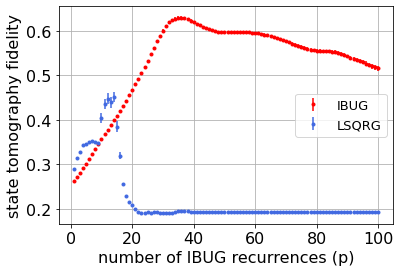

In [12]:
# plotting the 100 state tomography fidelity values for LSQRG
xvals  = list(range(1,101))

fig=plt.figure()
plt.xlabel('number of IBUG recurrences (p)')
plt.ylabel('state tomography fidelity')
plt.grid()

plt.errorbar(xvals,fids_mean_ibug,fids_std_ibug/np.sqrt(len(fids_std_ibug)),linestyle='none',marker='.',color='red',label='IBUG')#r'\mathcal{R}_2')
plt.errorbar(xvals,fids_mean_lsqrg,fids_std_lsqrg/np.sqrt(len(fids_std_lsqrg)),linestyle='none',marker='.',color='royalblue',label='LSQRG')#r'\mathcal{R}_1')
plt.legend(fontsize=13)
fig.savefig('ibug_lsqrg.pdf',bbox_inches='tight')
plt.show()

## $Some\:ibmq\_jakarta\:Properties$

In [7]:
config = jakarta.configuration()
# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,config.backend_version,config.n_qubits,'' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',config.basis_gates))

This backend is called ibmq_jakarta, and is on version 1.0.37. It has 7 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].


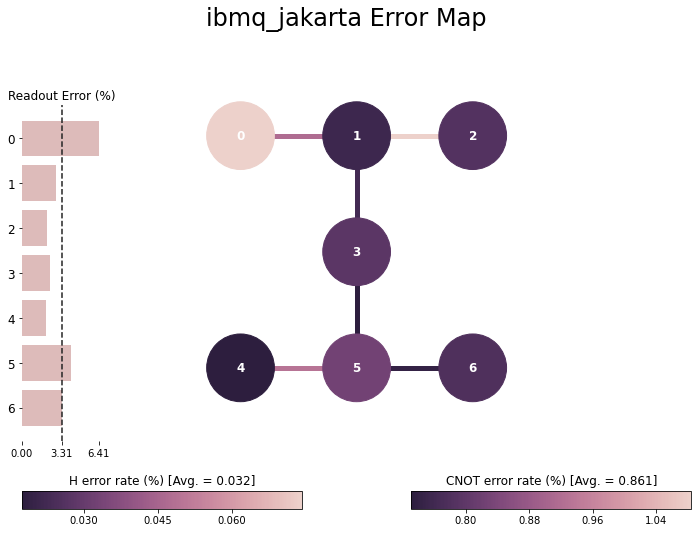

In [5]:
from qiskit.visualization import plot_error_map
plot_error_map(jakarta)

In [25]:
import qiskit.tools.jupyter
%qiskit_version_table